In [1]:
# %load_ext rpy2.ipython

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from cigma import util, plot

# Main

In [3]:
# genomic feature
## par 
out_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.jk.npy'
trans_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/he.jk.npy'
ctp_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ctp.final.gz'
op_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/op.rmid.gz'
P_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz'
eds_f = '../../analysis/yazar/eds.txt'
gcta_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/gcta/op.greml'
location_f = '../../data/Yazar2022Science/gene_location.txt'
GO_f = '../../data/GO.txt'

# MHC
MHC_chr = 6
MHC_start = 28477797
MHC_end = 33448354

## load data
out = np.load(out_f, allow_pickle=True).item()
trans_out = np.load(trans_f, allow_pickle=True).item()
eds = pd.read_table(eds_f)
print(eds.shape, eds['combined_connected_rank'].isna().sum())
P = pd.read_table(P_f, index_col=0)
cts = P.columns.tolist()
gcta = pd.read_table(gcta_f)
GO = pd.read_table(GO_f, index_col=(0)).rename(columns={'Unnamed: 1': 'GO term'})

# use gene length from gene location file
location = pd.read_table(location_f)
location['gene_length'] = location['end'] - location['start']
location['gene_length (kb)'] = location['gene_length'] / 1e3
eds = eds.drop('gene_length', axis=1)
eds = eds.merge(location[['feature', 'gene_length (kb)']], left_on='gene_id', right_on='feature')
eds = eds.drop('feature', axis=1)
eds = eds.rename(columns={'gene_id': 'gene'})
print(eds.shape, eds['gene_length (kb)'].isna().sum())

## collect data
gene_feature = {'gene': out['gene'], 'shared_h2': out['free']['shared_h2'], 'ct_h2': out['free']['specific_h2'],
        'hom_g2': out['free']['hom_g2'], 'V': np.diagonal(out['free']['V'], axis1=1, axis2=2).mean(axis=1), 
        'hom_e2': out['free']['hom_e2'], 'W': np.diagonal(out['free']['W'], axis1=1, axis2=2).mean(axis=1), 
        'var_beta': out['free']['ct_beta'].var(axis=1), 'p_V': out['p']['free']['V'],
        'p_hom_g2': out['p']['free']['hom_g2'],
        'std_specificity': np.sqrt(out['p']['free']['var_specificity'])
        }

gf = pd.DataFrame(gene_feature)

gf['g'] = gf['V'] + gf['hom_g2']
gf['specificity'] = gf['V'] / gf['g']
gf['e'] = gf['W'] + gf['hom_e2']
gf['e_specificity'] = gf['W'] / gf['e']
gf['std_beta'] = np.sqrt(gf['var_beta'])

p_cut = 0.05 / gf.shape[0]
# print(p_cut, gf.shape[0])

## merge with eds
print(gf.shape)
gf = gf.merge(eds, on='gene')
print(gf.shape, gf['gene'].nunique(), gf[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].dropna(how='all').shape, (~gf['LOEUF'].isna()).sum(), (~gf['ActivityLinking_EnhancerNumber'].isna()).sum(), (~gf['combined_connected_rank'].isna()).sum())

## add OP
op = pd.read_table(op_f, index_col=0).mean(axis=0)
op.name = 'mean_expr'
op = op.reset_index().rename(columns={'index': 'gene'})

gf = gf.merge(op, on='gene')

(20125, 16) 10710
(18348, 16) 0
(10288, 16)
(10037, 31) 10037 (10035, 3) 9970 10017 5523


In [4]:
# LDSC
## data
neg_traits = ['Height', 'CAD', 'SCZ']
pos_traits = ['UC', 'RA', 'PBC', 'MS', 'Crohns', 'Celiac', 'Lupus']
raw_traits = neg_traits + pos_traits
pos_traits[pos_traits.index('Lupus')] = 'SLE'

ldscs = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_200/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

ldsc_data = []
for stacked_f, trait in zip(ldscs, raw_traits):
    tmp = pd.read_table(stacked_f)
    if trait == 'Lupus':
        trait = 'SLE'
    tmp['trait'] = trait
    ldsc_data.append(tmp)

ldsc_data = pd.concat(ldsc_data, ignore_index=True)

# change lupus to SLE
traits = raw_traits.copy()
traits[traits.index('Lupus')] = 'SLE'

# random gene sets matching
LDSCRANDOM = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldscrandom/cell_type_results.txt')
LDSCRANDOM = LDSCRANDOM.loc[LDSCRANDOM['set'] != np.unique(LDSCRANDOM['set'])[-1]].reset_index(drop=True)  # remove one extra set
LDSCRANDOM['gwas'] = LDSCRANDOM['gwas'].replace({'Lupus': 'SLE'})
LDSCRANDOM_MAIN = LDSCRANDOM.loc[(LDSCRANDOM['ngene'] == 200) & (LDSCRANDOM['binsize'] == 500) & (LDSCRANDOM['nearbywindow'] == 500000)]
LDSCRANDOM_POS_MAIN = LDSCRANDOM.loc[(LDSCRANDOM['ngene'] == 200) & (LDSCRANDOM['binsize'] == 500) & (LDSCRANDOM['nearbywindow'] == 500000) & (LDSCRANDOM['gwas'].isin(pos_traits))]

def calculate_empirical_p(row, ldscrandom_data):
    trait = row['trait']
    gset = row['Name']
    real_p = row['Coefficient_P_value']
    trait_data = ldscrandom_data.loc[(ldscrandom_data['gwas'] == trait) & (ldscrandom_data['gset'] == gset)]
    assert trait_data.shape[0] > 0, f"No data for trait {trait} and gset {gset}"
    empirical_p = (trait_data.loc[trait_data['Coefficient_P_value'] <= real_p].shape[0] + 1) / (trait_data.shape[0] + 1)
    return empirical_p

ldsc_data['empirical_p'] = ldsc_data.apply(lambda row: calculate_empirical_p(row, LDSCRANDOM_MAIN), axis=1)

(7043, 32)
(7042, 32) 6996 7028 3828
1.9146197113857708
TtestResult(statistic=np.float64(6.546246535411452), pvalue=np.float64(6.683172692068267e-11), df=np.float64(3826.0))
LOEUF
Mega regression of hom_g2:
 const    0.017303
LOEUF    0.027761
dtype: float64 
 const    1.258072e-11
LOEUF    3.754301e-26
dtype: float64
Mega regression of V:
 const    0.016002
LOEUF    0.016519
dtype: float64 
 const    0.000005
LOEUF    0.000005
dtype: float64
Mega regression of specificity:
 const    1.799741
LOEUF   -1.398515
dtype: float64 
 const    0.227363
LOEUF    0.360035
dtype: float64


[2025-11-23 13:14:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Mega regression of specificity rank:
 const    3736.840937
LOEUF    -281.506232
dtype: float64 
 const    0.000000e+00
LOEUF    1.518139e-08
dtype: float64


[2025-11-23 13:14:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber
Mega regression of hom_g2:
 const                             0.043114
ActivityLinking_EnhancerNumber   -0.000122
dtype: float64 
 const                             1.757627e-106
ActivityLinking_EnhancerNumber     1.516531e-01
dtype: float64
Mega regression of V:
 const                             0.019624
ActivityLinking_EnhancerNumber    0.000603
dtype: float64 
 const                             9.398064e-14
ActivityLinking_EnhancerNumber    1.774408e-07
dtype: float64
Mega regression of specificity:
 const                             0.949858
ActivityLinking_EnhancerNumber   -0.019735
dtype: float64 
 const                             0.394288
ActivityLinking_EnhancerNumber    0.686895
dtype: float64
Mega regression of specificity rank:
 const                             3375.907401
ActivityLinking_EnhancerNumber       8.115351
dtype: float64 
 const                             0.000000e+00
ActivityLinking_EnhancerNumber    4.287342e-07
dtype: float64

[2025-11-23 13:14:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank
Mega regression of hom_g2:
 const                      0.023714
combined_connected_rank    0.000005
dtype: float64 
 const                      3.146477e-20
combined_connected_rank    1.904947e-05
dtype: float64
Mega regression of V:
 const                      0.036816
combined_connected_rank   -0.000003
dtype: float64 
 const                      1.101953e-19
combined_connected_rank    1.437360e-01
dtype: float64
Mega regression of specificity:
 const                     -0.034664
combined_connected_rank    0.000553
dtype: float64 
 const                      0.989780
combined_connected_rank    0.651392
dtype: float64
Mega regression of specificity rank:
 const                      1935.376263
combined_connected_rank      -0.010904
dtype: float64 
 const                      0.000000
combined_connected_rank    0.500021
dtype: float64


[2025-11-23 13:14:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-23 13:14:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


      Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait  \
0   shared  4.266588e-09           9.209898e-09             0.321589  Height   
1      var  2.539260e-09           9.263084e-09             0.391994  Height   
2     gcta -2.659591e-09           5.764795e-09             0.677726  Height   
3     mean -1.126715e-08           6.078901e-09             0.968094  Height   
4   shared  4.491146e-09           4.678503e-09             0.168539     CAD   
5      var  4.405140e-09           4.602517e-09             0.169255     CAD   
6     gcta  4.217472e-09           4.539642e-09             0.176436     CAD   
7     mean  1.641685e-09           4.748672e-09             0.364779     CAD   
8     gcta -2.949876e-09           7.053814e-09             0.662098     SCZ   
9      var -4.844143e-09           7.151166e-09             0.750921     SCZ   
10  shared -1.100802e-08           8.527299e-09             0.901633     SCZ   
11    mean -1.005700e-08           7.570

/tmp/ipykernel_552078/2555683346.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


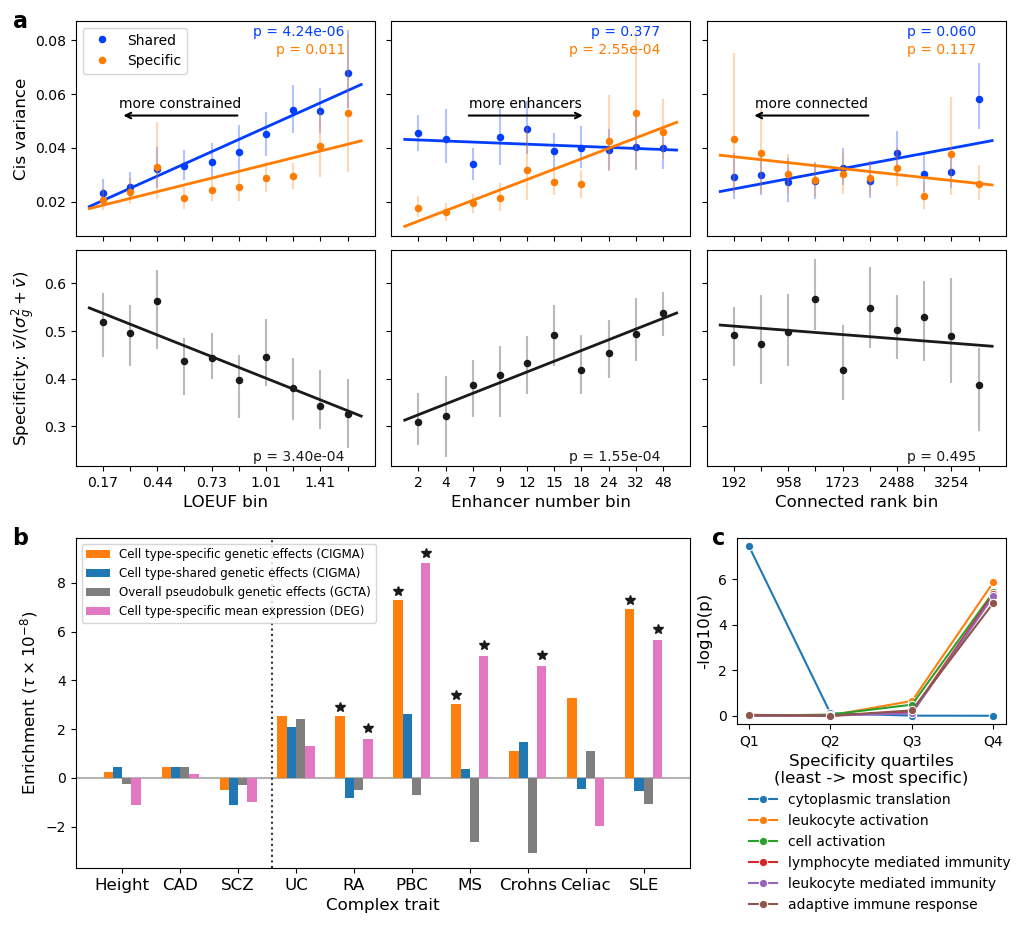

In [4]:
# Fig 4
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')
fig = plt.figure(1, figsize=(12, 11))
gs = gridspec.GridSpec(30, 62, wspace=0.1, hspace=1)

# genomic feature
data = gf.copy()
data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
print(data.shape)
filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
data = data.loc[~filter]
print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# divide gene annotation into bins
annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)

# t test for combined connectivity
connectivity_data = data[['hom_g2', 'combined_connected_rank', 'combined_connected_rank_bin']].dropna()
least_connected_bin = connectivity_data['combined_connected_rank_bin'].max()
least_connected = connectivity_data.loc[connectivity_data['combined_connected_rank_bin'] == least_connected_bin]
other_connected = connectivity_data.loc[connectivity_data['combined_connected_rank_bin'] != least_connected_bin]
print(least_connected['hom_g2'].mean() / other_connected['hom_g2'].mean())
print(stats.ttest_ind(least_connected['hom_g2'], other_connected['hom_g2']))


# arrange axes
ax11 = fig.add_subplot(gs[:8, :20])
ax12 = fig.add_subplot(gs[:8, 21:41], sharey=ax11)
ax13 = fig.add_subplot(gs[:8, 42:], sharey=ax11)
ax21 = fig.add_subplot(gs[8:16, :20], sharex=ax11)
ax22 = fig.add_subplot(gs[8:16, 21:41], sharex=ax12, sharey=ax21)
ax23 = fig.add_subplot(gs[8:16, 42:], sharex=ax13, sharey=ax21)
axes = np.array([[ax11, ax12, ax13],
                [ax21, ax22, ax23]])


for j, annotation in enumerate(annotations):
    print(annotation)
    # mega regression
    annotation_data = data[['hom_g2', 'V', 'specificity', annotation]].dropna()
    X = sm.add_constant(annotation_data[annotation])
    for y in ['hom_g2', 'V', 'specificity']:
        model = sm.OLS(annotation_data[y], X).fit()
        print(f'Mega regression of {y}:\n', model.params, '\n', model.pvalues)
        # print(model.summary())
    model = sm.OLS(annotation_data['specificity'].rank(), X).fit()
    print(f'Mega regression of specificity rank:\n', model.params, '\n', model.pvalues)

    # meta-regression
    grouped = data.groupby(annotation + '_bin', observed=True)

    line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

    ax = axes[0, j]
    # point plot
    sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)

    # add p values
    x = 0.9
    y = 0.98
    ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
    y -= .08
    ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


    ax2 = axes[1, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    # pointplot
    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                    markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
    xs = np.array(ax2.get_xlim())
    ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

    ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

    xlabel = re.sub('_', ' ', annotation + '_bin')
    if annotation == 'ActivityLinking_EnhancerNumber':
        xlabel = 'Enhancer number bin'
    elif annotation == 'combined_connected_rank':
        xlabel = 'Connected rank bin'

    if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
        # set x tick labels
        xticklabels = []
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 2 == 0:
                xticklabels.append(label.get_text())
            else:
                xticklabels.append('')
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(xticklabels)

    ax2.set_xlabel(xlabel, fontsize=fs)

    if j == 0:
        ax.set_ylabel('Cis variance', fontsize=fs)
        ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs)
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax2.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        ax2.set_ylabel('')
    
    if j != 0:
        ax.legend().set_visible(False)
    else:
        ax.legend(loc='upper left', fontsize=fs-2)

# add arrow
arrow_position = (0.55, 0.56)
axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(0.35, 0.58, 'more constrained', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 0].transAxes)

axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(0.35, 0.58, 'more connected', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 2].transAxes)

axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(0.45, 0.58, 'more enhancers', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 1].transAxes)


# # add a star to connectedness vs shared # TODO
# axes[0, 2].plot(9, data.loc[data['combined_connected_rank_bin'] == data['combined_connected_rank_bin'].max(), 'hom_g2'].mean(), marker='*', color=colors[0], markersize=10, zorder=10)


## LDSC
ax = fig.add_subplot(gs[18:, :41])
gene_set_order = ['var', 'shared', 'gcta', 'mean' ]

x = np.arange(ldsc_data['trait'].nunique())
width = 0.16
# width = 0.32
ldsc_colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[7], sns.color_palette()[6]]
# colors = [sns.color_palette()[2], sns.color_palette()[1]] + sns.color_palette()[3:]
multiplier = -len(gene_set_order) / 2 + 0.5
print(ldsc_data)

for i, gene_set in enumerate(gene_set_order):
    if gene_set == 'mean':
        label = 'Cell type-specific mean expression (DEG)'
    elif gene_set == 'var':
        label = 'Cell type-specific genetic effects (CIGMA)'
    elif gene_set =='shared':
        label = 'Cell type-shared genetic effects (CIGMA)'
    elif gene_set == 'gcta':
        label = 'Overall pseudobulk genetic effects (GCTA)'
    offset = width * multiplier
    set_data = ldsc_data.loc[ldsc_data['Name'] == gene_set]
    set_data = set_data.set_index('trait')
    # ys = np.log10(set_data['Coefficient_P_value'][traits]) * (-1)
    ys = set_data['Coefficient'][traits] * 1e8
    rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=ldsc_colors[i])
    # add star
    # for p, rect in zip(set_data['Coefficient_P_value'][traits], rects):
    for p, rect in zip(set_data['empirical_p'][traits], rects):
        if p <= 0.05:
            ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                    color='0.1', markersize=7)

    multiplier += 1
ax.set_ylabel(r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs)
# ax.set_ylabel(r'Regression coefficient, $\tau$ ($\times 10^{-8}$)', fontsize=fs)
ax.set_xlabel('Complex trait', fontsize=fs)

ax.set_xticks(x, traits, fontsize=fs)
ax.legend(loc='upper left', fontsize=fs-3.5)
ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
ax.axhline(0, linestyle='-', color='0.7', zorder=0)
# ax.axhline(-np.log10(0.05), linestyle=(0, (6, 6)), color='0.7', zorder=0)


# GO enrichment
ax = fig.add_subplot(gs[18:25, 44:])
tmp_go = GO.copy().melt(id_vars=['GO term'], var_name='Specificity', value_name='p')
print(tmp_go)
tmp_go['neg_log10_p'] = -np.log10(tmp_go['p'])
# tmp_go.loc[tmp_go['Specificity'] == 'Q1', 'Specificity'] = 'Q1 (least specific)'
sns.lineplot(data=tmp_go, x='Specificity', y='neg_log10_p', hue='GO term', marker='o', ax=ax, )
ax.set_xlabel('Specificity quartiles\n(least -> most specific)', fontsize=fs)
ax.set_ylabel('-log10(p)', fontsize=fs)
ax.legend(loc='upper left', bbox_to_anchor=(.0, -0.3), frameon=False, ncols=1,
          title='', fontsize=fs-2, title_fontsize=fs-1)

fig.text(0.085, .89, 'a', fontsize=fs + 4, fontweight='bold', va='top', ha='right')
fig.text(0.085, .42, 'b', fontsize=fs + 4, fontweight='bold', va='top', ha='right')
fig.text(0.666, .42, 'c', fontsize=fs + 4, fontweight='bold', va='top', ha='right')


fig.tight_layout()

# Supp fig: association with gene length, mean expression, and var_beta

[2025-11-20 13:19:38 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:38 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7042, 32)
gene_length (kb)


[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

mean_expr


[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:39 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:40 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:40 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:40 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

var_beta


[2025-11-20 13:19:41 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:41 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:41 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:41 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


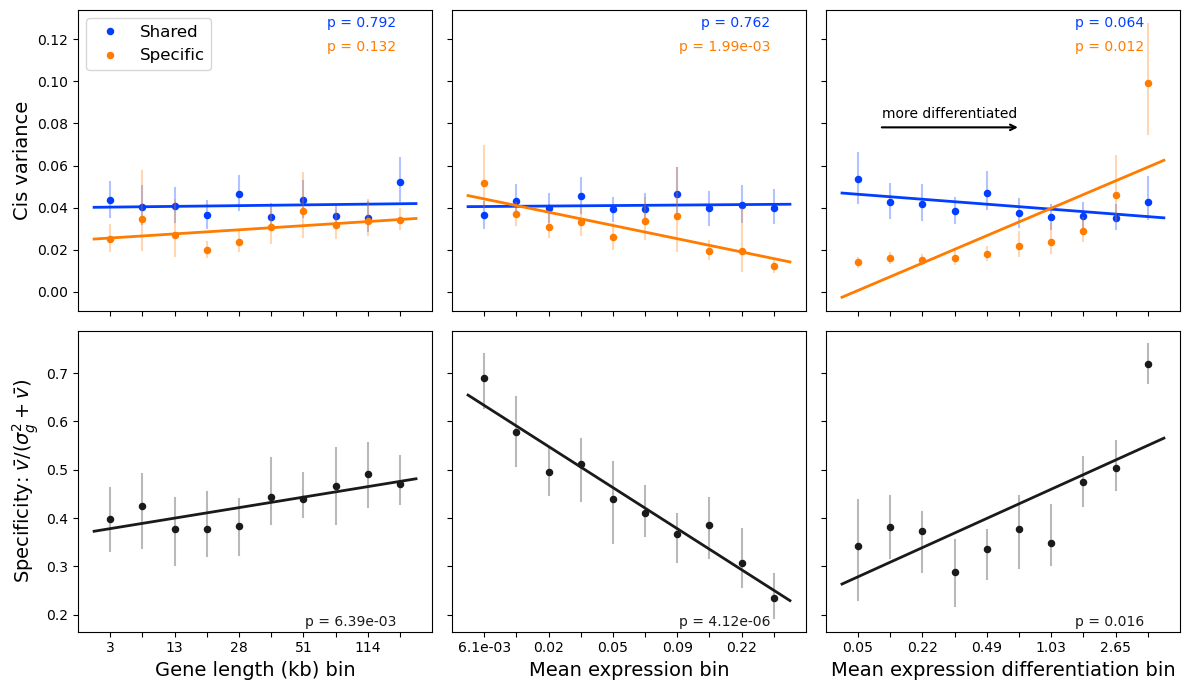

In [6]:
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
colors = sns.color_palette('bright')


# genomic feature
data = gf.copy()
data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
data = data.loc[~filter]

print(data.shape)

# divide gene annotation into bins
annotations = ['gene_length (kb)', 'mean_expr', 'var_beta']
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)


# arrange axes
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey='row', sharex='col')


for j, annotation in enumerate(annotations):
    print(annotation)

    # meta-regression
    grouped = data.groupby(annotation + '_bin', observed=True)

    line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

    ax = axes[0, j]
    # point plot
    sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)

    # add p values
    x = 0.9
    y = 0.98
    ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
    y -= .08
    ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


    ax2 = axes[1, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    # pointplot
    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                    markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
    xs = np.array(ax2.get_xlim())
    ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

    ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

    xlabel = re.sub('_', ' ', annotation + '_bin')
    if annotation == 'mean_expr':
        xlabel = 'Mean expression bin'
    elif annotation == 'var_beta':
        xlabel = 'Mean expression differentiation bin'
    elif annotation == 'gene_length (kb)':
        xlabel = 'Gene length (kb) bin'

    # set x tick labels
    xticklabels = []
    for i, label in enumerate(ax2.get_xticklabels()):
        if i % 2 == 0:
            xticklabels.append(label.get_text())
        else:
            xticklabels.append('')
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels(xticklabels)

    ax2.set_xlabel(xlabel, fontsize=fs+2)

    if j == 0:
        ax.set_ylabel('Cis variance', fontsize=fs+2)
        ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs+2)
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax2.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        ax2.set_ylabel('')
    
    if j != 0:
        ax.legend().set_visible(False)
    else:
        ax.legend(loc='upper left', fontsize=fs)

# add arrow
y = 0.61
arrow_position = (0.15, y)
# axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
#             arrowprops=dict(arrowstyle='->', lw=1.5),
#             fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
# axes[0, 0].text(0.35, y + .02, 'more constrained', ha='center', va='bottom', 
#                 fontsize=fs-2, transform=axes[0, 0].transAxes)

# axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
#             arrowprops=dict(arrowstyle='->', lw=1.5),
#             fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
# axes[0, 1].text(0.45, y + .02, 'more enhancers', ha='center', va='bottom', 
#                 fontsize=fs-2, transform=axes[0, 1].transAxes)

axes[0, 2].annotate('', xy=(arrow_position[0] + 0.40, arrow_position[1]), xytext=arrow_position,
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(0.35, y + .02, 'more differentiated', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 2].transAxes)


fig.tight_layout()

# correct for gene length and mean expression

In [7]:
# fs = 12
# lw = 2
# alpha = 0.3
# format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

# # genomic feature
# data = gf.copy()
# data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
# filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
# data = data.loc[~filter]
# print(data.shape, (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# # rerank connectness
# data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# # correct for gene length and mean expression
# X = sm.add_constant(data[['gene_length (kb)', 'mean_expr']])
# for y in ['hom_g2', 'V', 'specificity']:
#     model = sm.OLS(data[y], X).fit()
#     data[y] = model.resid


# # divide gene annotation into bins
# annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
# for annotation in annotations:
#     if annotation == 'combined_connected_rank':
#         data = plot.bin_gene_annotation(data, annotation, 10)
#     else:
#         data = plot.bin_gene_annotation(data, annotation, 10)


# # arrange axes
# fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey='row', sharex='col')

# for j, annotation in enumerate(annotations):
#     print(annotation)

#     # meta-regression
#     grouped = data.groupby(annotation + '_bin', observed=True)

#     line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
#     line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

#     ax = axes[0, j]
#     # point plot
#     sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
#                 markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 label=r'Shared', ax=ax)
#     xs = np.array(ax.get_xlim())
#     ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
#     sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
#                 markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 label=r'Specific', ax=ax)
#     ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
#     ax.set_xlabel('')
#     ax.tick_params(axis='x', labelbottom=False)

#     # add p values
#     x = 0.9
#     y = 0.98
#     ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
#     y -= .08
#     ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


#     ax2 = axes[1, j]
#     line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

#     # pointplot
#     sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
#                     markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
#     xs = np.array(ax2.get_xlim())
#     ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

#     ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

#     xlabel = re.sub('_', ' ', annotation + '_bin')
#     if annotation == 'ActivityLinking_EnhancerNumber':
#         xlabel = 'Enhancer number bin'
#     elif annotation == 'combined_connected_rank':
#         xlabel = 'Connected rank bin'

#     if annotation in ['LOEUF', 'EDS', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr']:
#         # set x tick labels
#         xticklabels = []
#         for i, label in enumerate(ax2.get_xticklabels()):
#             if i % 2 == 0:
#                 xticklabels.append(label.get_text())
#             else:
#                 xticklabels.append('')
#         ax2.set_xticks(ax.get_xticks())
#         ax2.set_xticklabels(xticklabels)

#     ax2.set_xlabel(xlabel, fontsize=fs)

#     if j == 0:
#         ax.set_ylabel('Cis variance', fontsize=fs)
#         ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs)
#     else:
#         ax.tick_params(axis='y', labelleft=False)
#         ax2.tick_params(axis='y', labelleft=False)
#         ax.set_ylabel('')
#         ax2.set_ylabel('')
    
#     if j != 0:
#         ax.legend().set_visible(False)
#     else:
#         ax.legend(loc='upper left', fontsize=fs-2)

# # add arrow
# arrow_position = (0.55, 0.56)
# axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
#             arrowprops=dict(arrowstyle='->', lw=1.5),
#             fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
# axes[0, 0].text(0.35, 0.58, 'more constrained', ha='center', va='bottom', 
#                 fontsize=fs-2, transform=axes[0, 0].transAxes)

# axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
#         arrowprops=dict(arrowstyle='->', lw=1.5),
#         fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
# axes[0, 2].text(0.35, 0.58, 'more connected', ha='center', va='bottom', 
#                 fontsize=fs-2, transform=axes[0, 2].transAxes)

# axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
#             arrowprops=dict(arrowstyle='->', lw=1.5),
#             fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
# axes[0, 1].text(0.45, 0.58, 'more enhancers', ha='center', va='bottom', 
#                 fontsize=fs-2, transform=axes[0, 1].transAxes)
# fig.tight_layout()

# Supp fig: correct for gene length, meane expresion and var(beta)

[2025-11-20 13:19:42 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:42 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7042, 32)
[-1393.12637965 -1043.56809193  -145.78241688  -144.7774344
  -103.45457078   -73.88138841   -61.83905794   -58.44640925
   -58.19838454   -57.82954307] [  27.50802993   27.57877847   31.18960236   31.56186466   39.87132199
   40.96182141   46.02707775   62.75582528  328.98362086 4856.92418716]
(7042, 32) 6996 7028 3828
LOEUF


[2025-11-20 13:19:42 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:43 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:43 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:43 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:43 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-20 13:19:43 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-20 13:19:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


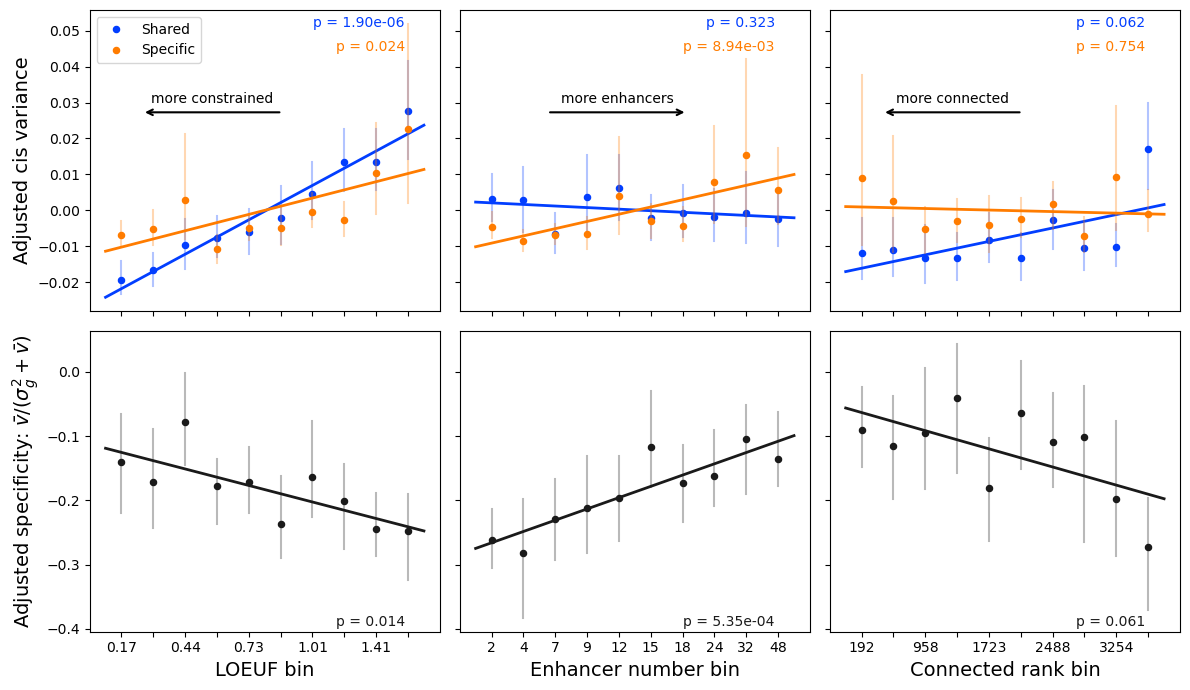

In [8]:
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
colors = sns.color_palette('bright')

# genomic feature
data = gf.copy()
data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
data = data.loc[~filter]
print(data.shape)
print(np.sort(data['specificity'])[:10], np.sort(data['specificity'])[-10:])
# data = data.loc[(data['specificity'] > -100) & (data['specificity'] < 100)]  # NOTE: remove outlier
print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# correct for gene length and mean expression
X = sm.add_constant(data[['gene_length (kb)', 'mean_expr', 'var_beta']])
for y in ['hom_g2', 'V', 'specificity']:
    model = sm.OLS(data[y], X).fit()
    data[y] = model.resid


# divide gene annotation into bins
annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
for annotation in annotations:
    if annotation == 'combined_connected_rank':
        data = plot.bin_gene_annotation(data, annotation, 10)
    else:
        data = plot.bin_gene_annotation(data, annotation, 10)


# arrange axes
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey='row', sharex='col')

for j, annotation in enumerate(annotations):
    print(annotation)

    # meta-regression
    grouped = data.groupby(annotation + '_bin', observed=True)

    line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

    ax = axes[0, j]
    # point plot
    sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)

    # add p values
    x = 0.9
    y = 0.98
    ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
    y -= .08
    ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


    ax2 = axes[1, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    # pointplot
    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                    markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
    xs = np.array(ax2.get_xlim())
    ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

    ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

    xlabel = re.sub('_', ' ', annotation + '_bin')
    if annotation == 'ActivityLinking_EnhancerNumber':
        xlabel = 'Enhancer number bin'
    elif annotation == 'combined_connected_rank':
        xlabel = 'Connected rank bin'

    if annotation in ['LOEUF', 'EDS', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr']:
        # set x tick labels
        xticklabels = []
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 2 == 0:
                xticklabels.append(label.get_text())
            else:
                xticklabels.append('')
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(xticklabels)

    ax2.set_xlabel(xlabel, fontsize=fs+2)

    if j == 0:
        ax.set_ylabel('Adjusted cis variance', fontsize=fs+2 )
        ax2.set_ylabel('Adjusted specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs+2)
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax2.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        ax2.set_ylabel('')
    
    if j != 0:
        ax.legend().set_visible(False)
    else:
        ax.legend(loc='upper left', fontsize=fs-2)

# add arrow
x = 0.55
y = 0.66
arrow_position = (x, y)
axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(0.35, y + .02, 'more constrained', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 0].transAxes)

axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(0.35, y + .02, 'more connected', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 2].transAxes)

axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(0.45, y + .02, 'more enhancers', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 1].transAxes)
fig.tight_layout()

# Supp fig: Env specificity

[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(8627, 32)
(8626, 32) 8569 8613 4714
LOEUF


[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-20 13:19:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


LOEUF


[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:49 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:49 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:49 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-20 13:19:49 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:49 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:50 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:50 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:51 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-20 13:19:51 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:51 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

gene_length (kb)


[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:52 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

mean_expr


[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

var_beta


[2025-11-20 13:19:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:19:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


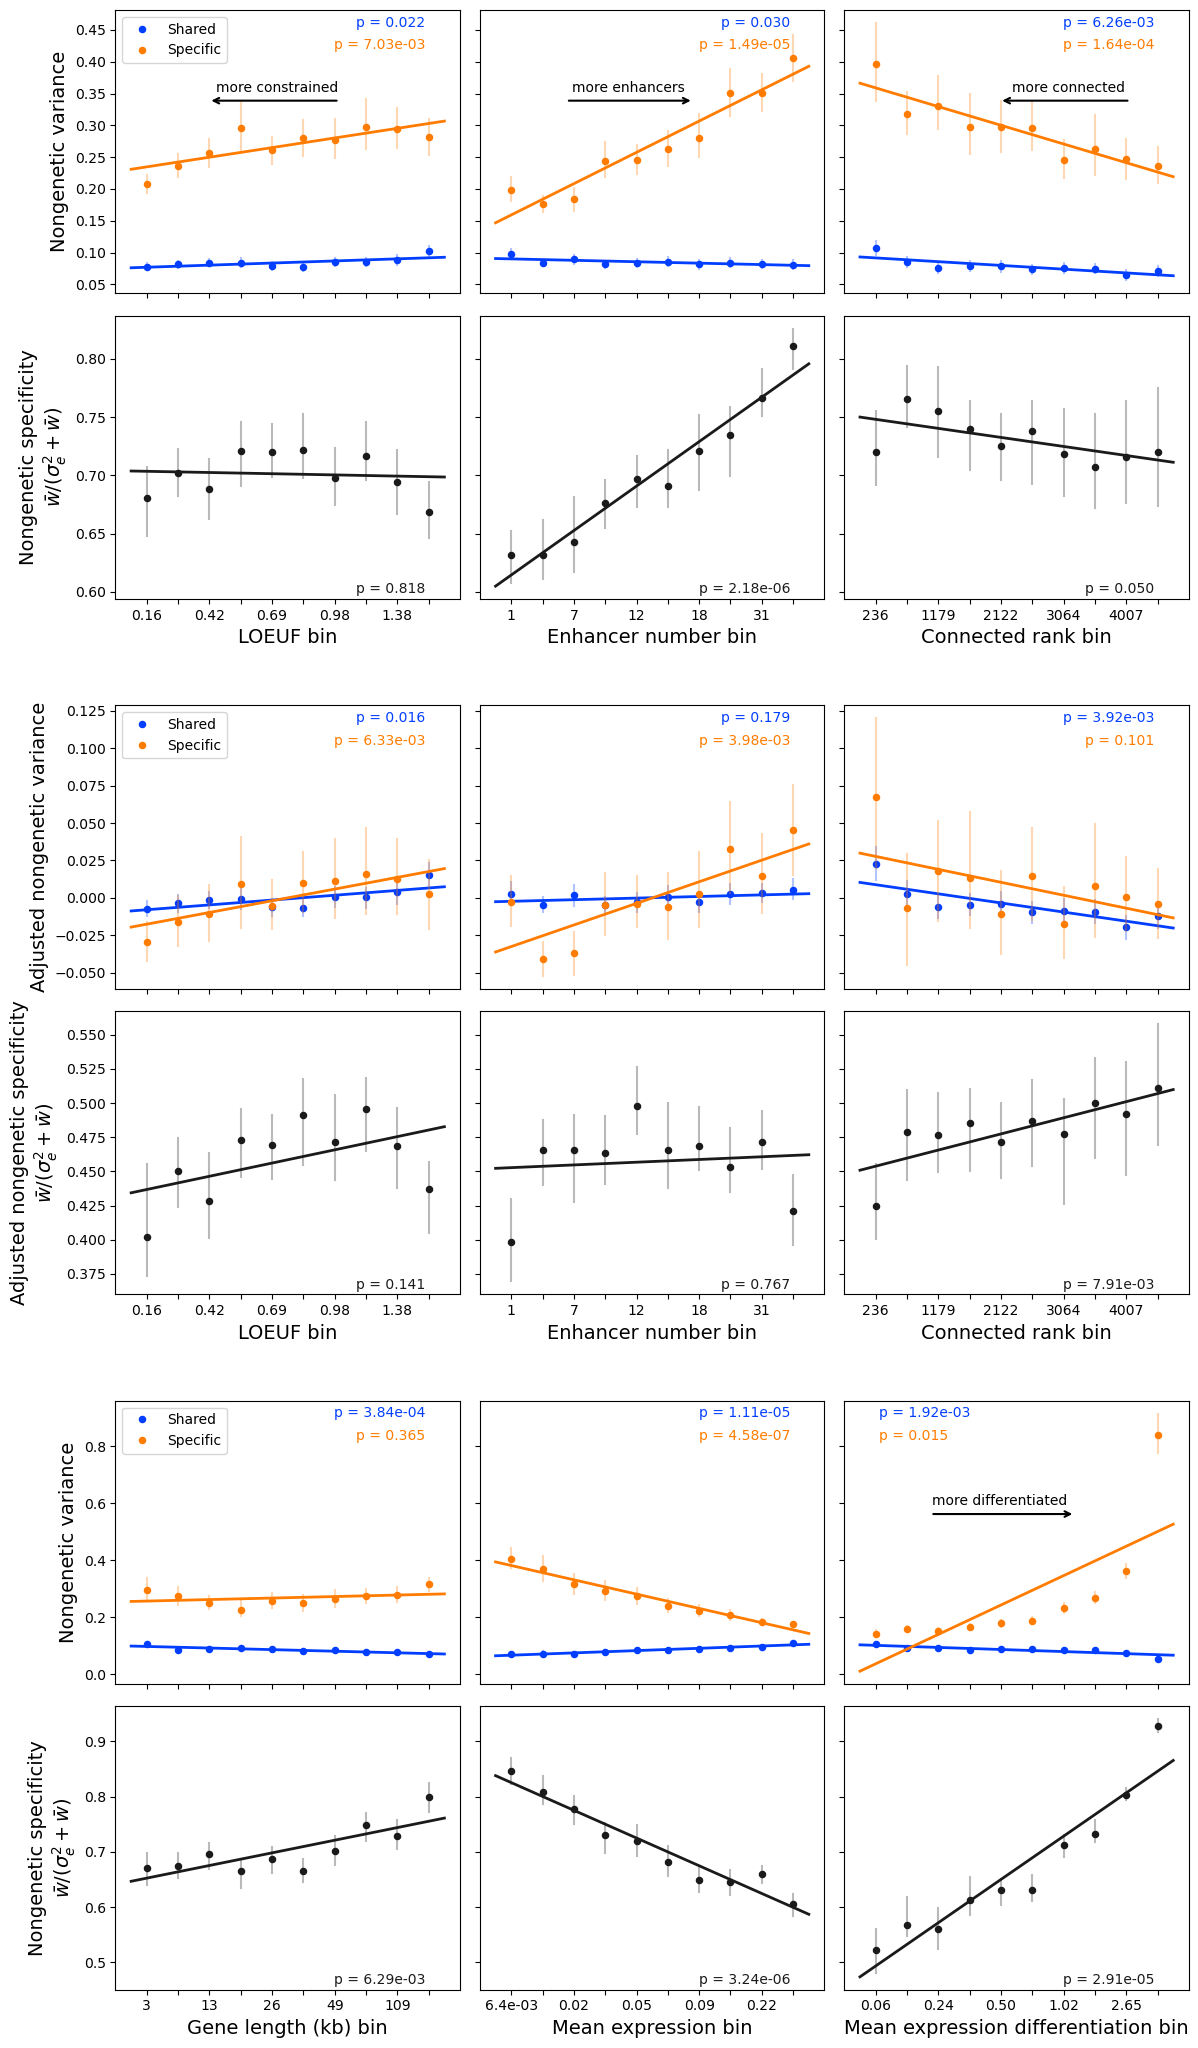

In [9]:
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
colors = sns.color_palette('bright')

# genomic feature
data = gf.copy()
data = data.loc[data['e'] > 0]  # NOTE: removed negative gen variance
filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
data = data.loc[~filter]
print(data.shape)
# print(np.sort(data['e_specificity'])[:10], np.sort(data['e_specificity'])[-10:])
data = data.loc[(data['e_specificity'] > -10000)] # NOTE: remove outlier
print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# correct for gene length and mean expression
X = sm.add_constant(data[['gene_length (kb)', 'mean_expr', 'var_beta']])
for y in ['hom_e2', 'W', 'e_specificity']:
    model = sm.OLS(data[y], X).fit()
    data[y + '_resid'] = model.resid


# divide gene annotation into bins
annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr', 'var_beta']
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)


fig, axes = plt.subplots(6, 3, figsize=(12, 21), sharey='row')

annotation_sets = [['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank'],
                   ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank'],
                   ['gene_length (kb)', 'mean_expr', 'var_beta']
                   ]
analyses = ['', '_resid', '']
for k, annotation_set, analysis in zip(range(3), annotation_sets, analyses):
    r = k * 2
    hom = 'hom_e2' + analysis
    spec = 'W' + analysis
    specificity = 'e_specificity' + analysis

    for j, annotation in enumerate(annotation_set):
        print(annotation)
        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, hom, 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, spec, 'mean', return_params=True)

        ax = axes[r, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y=hom, estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y=spec, estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        if k == 2 and j == 2:
            x = 0.1
            ha = 'left'
        else:
            x = 0.9
            ha = 'right'
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha=ha, va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha=ha, va='top', transform=ax.transAxes)

        x = 0.9
        ax2 = axes[r+1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, specificity, 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y=specificity, err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'
        elif annotation == 'mean_expr':
            xlabel = 'Mean expression bin'
        elif annotation == 'var_beta':
            xlabel = 'Mean expression differentiation bin'
        elif annotation == 'gene_length (kb)':
            xlabel = 'Gene length (kb) bin'


        # set x tick labels
        xticklabels = []
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 2 == 0:
                xticklabels.append(label.get_text())
            else:
                xticklabels.append('')
        ax2.set_xticks(ax2.get_xticks())
        ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs+2)

        if j == 0:
            if k == 1:
                ax.set_ylabel('Adjusted nongenetic variance', fontsize=fs+2)
                ax2.set_ylabel('Adjusted nongenetic specificity\n' + r'$\bar{w}/(\sigma_e^2 + \bar{w})$', fontsize=fs+2)
            else:
                ax.set_ylabel('Nongenetic variance', fontsize=fs+2)
                ax2.set_ylabel('Nongenetic specificity\n' + r'$\bar{w}/(\sigma_e^2 + \bar{w})$', fontsize=fs+2)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if j != 0:
            ax.legend().set_visible(False)
        else:
            ax.legend(loc='upper left', fontsize=fs-2)

# add arrow
y = 0.68
x = 0.65
axes[0, 0].annotate('', xy=(x - 0.38, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(x - .18, y + 0.02, 'more constrained', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 0].transAxes)

x = 0.25
axes[0, 1].annotate('', xy=(x + 0.37, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(x + 0.18, y + 0.02, 'more enhancers', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 1].transAxes)

x = 0.83
axes[0, 2].annotate('', xy=(x - 0.38, y), xytext=(x, y),
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(x - .18, y + 0.02, 'more connected', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 2].transAxes)


y = 0.6
x = 0.25
axes[4, 2].annotate('', xy=(x + 0.42, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[4, 2].transAxes)
axes[4, 2].text(x + .2, y + 0.02, 'more differentiated', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[4, 2].transAxes)

fig.tight_layout()

for ax in np.concatenate([axes[1], axes[3], axes[5]]):
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])


In [10]:
# # robust test: without excluding outlier specificity
# fs = 12
# lw = 2
# alpha = 0.3
# format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
# colors = sns.color_palette('bright')

# # genomic feature
# data = gf.copy()
# data = data.loc[data['e'] > 0]  # NOTE: removed negative gen variance
# filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
# data = data.loc[~filter]
# print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# # data = data.loc[(data['e_specificity'] < 10) & (data['e_specificity'] > -10)] # NOTE: remove outlier
# print(data.shape)
# # rerank connectness
# data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# # correct for gene length and mean expression
# X = sm.add_constant(data[['gene_length (kb)', 'mean_expr', 'var_beta']])
# for y in ['hom_e2', 'W', 'e_specificity']:
#     model = sm.OLS(data[y], X).fit()
#     data[y + '_resid'] = model.resid


# # divide gene annotation into bins
# annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr', 'var_beta']
# for annotation in annotations:
#     data = plot.bin_gene_annotation(data, annotation, 10)


# fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey='row')

# annotation_set = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
# analysis = '_resid'
# hom = 'hom_e2' + analysis
# spec = 'W' + analysis
# specificity = 'e_specificity' + analysis

# for j, annotation in enumerate(annotation_set):
#     print(annotation)
#     # meta-regression
#     grouped = data.groupby(annotation + '_bin', observed=True)

#     line1, p1, slope1, intercept1 = plot.meta_regression(grouped, hom, 'mean', return_params=True)
#     line2, p2, slope2, intercept2 = plot.meta_regression(grouped, spec, 'mean', return_params=True)

#     ax = axes[0, j]
#     # point plot
#     sns.pointplot(data=data, x=annotation + '_bin', y=hom, estimator='mean',
#                 markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 label=r'Shared', ax=ax)
#     xs = np.array(ax.get_xlim())
#     ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
#     sns.pointplot(data=data, x=annotation + '_bin', y=spec, estimator='mean',
#                 markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 label=r'Specific', ax=ax)
#     ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
#     ax.set_xlabel('')
#     ax.tick_params(axis='x', labelbottom=False)

#     # add p values
#     x = 0.9
#     ha = 'right'
#     y = 0.98
#     ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha=ha, va='top', transform=ax.transAxes)
#     y -= .08
#     ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha=ha, va='top', transform=ax.transAxes)



#     x = 0.9
#     ax2 = axes[1, j]
#     line, p, slope, intercept = plot.meta_regression(grouped, specificity, 'median', return_params=True)

#     # pointplot
#     sns.pointplot(data=data, x=annotation + '_bin', y=specificity, err_kws={'alpha': alpha, 'linewidth': 1.5},
#                     markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
#     xs = np.array(ax2.get_xlim())
#     ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

#     ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

#     xlabel = re.sub('_', ' ', annotation + '_bin')
#     if annotation == 'ActivityLinking_EnhancerNumber':
#         xlabel = 'Enhancer number bin'
#     elif annotation == 'combined_connected_rank':
#         xlabel = 'Connected rank bin'
#     elif annotation == 'mean_expr':
#         xlabel = 'Mean expression bin'
#     elif annotation == 'var_beta':
#         xlabel = 'Mean expression differentiation bin'
#     elif annotation == 'gene_length (kb)':
#         xlabel = 'Gene length (kb) bin'


#     # set x tick labels
#     xticklabels = []
#     for i, label in enumerate(ax2.get_xticklabels()):
#         if i % 2 == 0:
#             xticklabels.append(label.get_text())
#         else:
#             xticklabels.append('')
#     ax2.set_xticks(ax2.get_xticks())
#     ax2.set_xticklabels(xticklabels)

#     ax2.set_xlabel(xlabel, fontsize=fs)

# fig.tight_layout()

# Trans specificity

In [11]:
# collect data
df = util.read_out(trans_out, ['gene', 'free:hom_g2', 'free:hom_e2', 'free:v', 'free:w', 'free:hom_g2_b', 'free:v_b'])

df['g'] = df['free:v'] + df['free:hom_g2']
df['specificity'] = df['free:v'] / df['g']
df['g_b'] = df['free:v_b'] + df['free:hom_g2_b']
df['specificity_b'] = df['free:v_b'] / df['g_b']
df['e'] = df['free:w'] + df['free:hom_e2']
df['e_specificity'] = df['free:w'] / df['e']

-0.9795261436351821
-0.9533068801705142


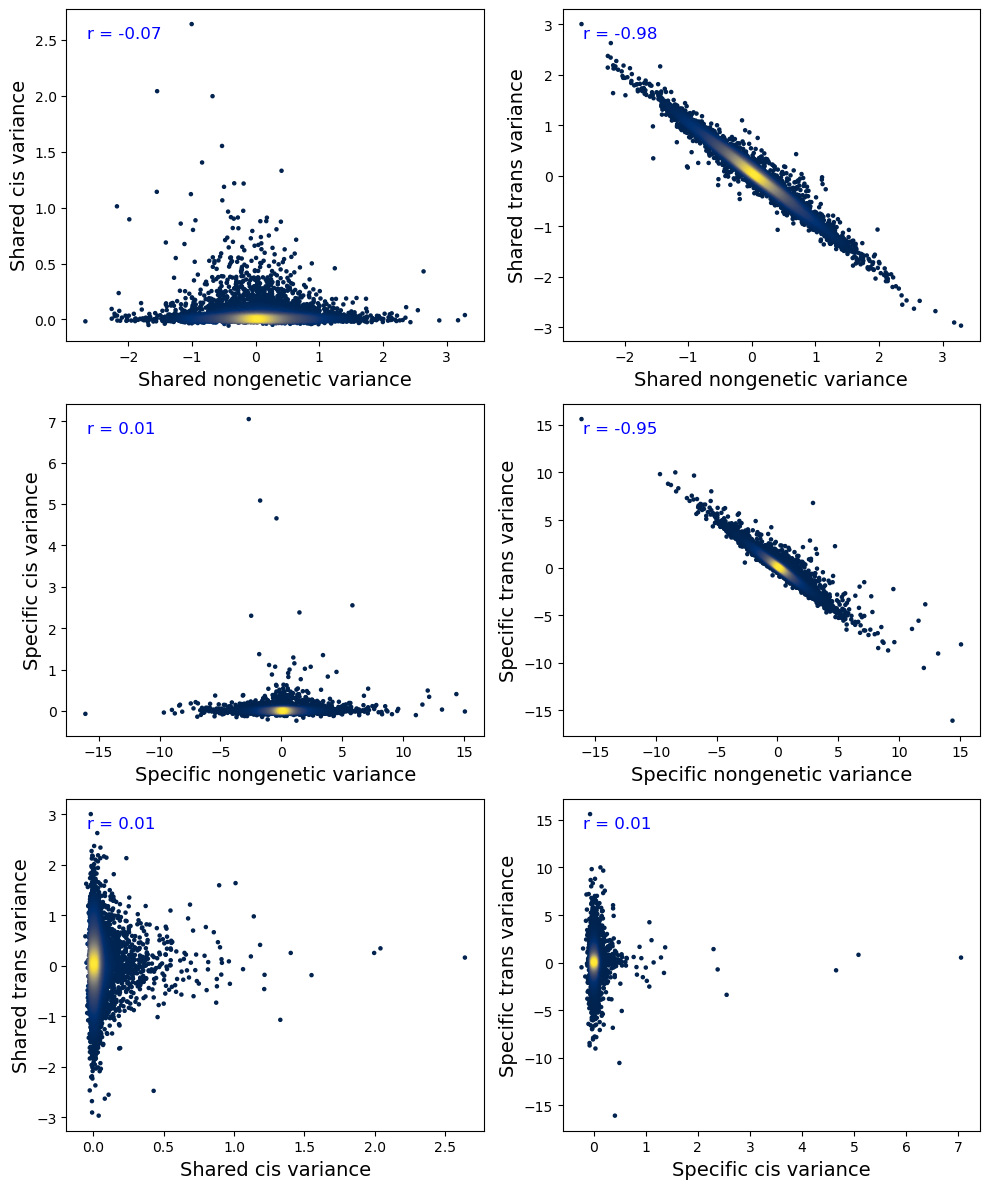

In [12]:
# env specificity vs trans specificity
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# cis
plot.scatter(df['free:hom_e2'], df['free:hom_g2'], s=5, heatscatter=True, ax=axes[0, 0])
# axes[0, 0].scatter(df['free:hom_e2'], df['free:hom_g2'], alpha=0.3, s=5, color='0.1')
axes[0, 0].set_xlabel('Shared nongenetic variance', fontsize=14)
axes[0, 0].set_ylabel('Shared cis variance', fontsize=14)
corr = np.corrcoef(df['free:hom_e2'], df['free:hom_g2'])[0, 1]
axes[0, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[0, 0].transAxes, fontsize=12, color='b')

plot.scatter(df['free:w'], df['free:v'], s=5, heatscatter=True, ax=axes[1, 0])
# axes[1, 0].scatter(df['free:w'], df['free:v'], alpha=0.3, s=5, color='0.1')
axes[1, 0].set_xlabel('Specific nongenetic variance', fontsize=14)
axes[1, 0].set_ylabel('Specific cis variance', fontsize=14)
corr = np.corrcoef(df['free:w'], df['free:v'])[0, 1]
axes[1, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[1, 0].transAxes, fontsize=12, color='b')

plot.scatter(df['free:hom_g2'], df['free:hom_g2_b'], s=5, heatscatter=True, ax=axes[2, 0])
# axes[2, 0].scatter(df['free:hom_g2'], df['free:hom_g2_b'], alpha=0.3, s=5, color='0.1')
axes[2, 0].set_xlabel('Shared cis variance', fontsize=14)
axes[2, 0].set_ylabel('Shared trans variance', fontsize=14)
corr = np.corrcoef(df['free:hom_g2'], df['free:hom_g2_b'])[0, 1]
axes[2, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[2, 0].transAxes, fontsize=12, color='b')

# trans
plot.scatter(df['free:hom_e2'], df['free:hom_g2_b'], s=5, heatscatter=True, ax=axes[0, 1])
# axes[0, 1].scatter(df['free:hom_e2'], df['free:hom_g2_b'], alpha=0.3, s=5, color='0.1')
axes[0, 1].set_xlabel('Shared nongenetic variance', fontsize=14)
axes[0, 1].set_ylabel('Shared trans variance', fontsize=14)
corr = np.corrcoef(df['free:hom_e2'], df['free:hom_g2_b'])[0, 1]
print(corr)
axes[0, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[0, 1].transAxes, fontsize=12, color='b')

plot.scatter(df['free:w'], df['free:v_b'], s=5, heatscatter=True, ax=axes[1, 1])
# axes[1, 1].scatter(df['free:w'], df['free:v_b'], alpha=0.3, s=5, color='0.1')
axes[1, 1].set_xlabel('Specific nongenetic variance', fontsize=14)
axes[1, 1].set_ylabel('Specific trans variance', fontsize=14)
corr = np.corrcoef(df['free:w'], df['free:v_b'])[0, 1]
print(corr)
axes[1, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[1, 1].transAxes, fontsize=12, color='b')

plot.scatter(df['free:v'], df['free:v_b'], s=5, heatscatter=True, ax=axes[2, 1])
# axes[2, 1].scatter(df['free:v'], df['free:v_b'], alpha=0.3, s=5, color='0.1')
axes[2, 1].set_xlabel('Specific cis variance', fontsize=14)
axes[2, 1].set_ylabel('Specific trans variance', fontsize=14)
corr = np.corrcoef(df['free:v'], df['free:v_b'])[0, 1]
axes[2, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[2, 1].transAxes, fontsize=12, color='b')


fig.tight_layout()

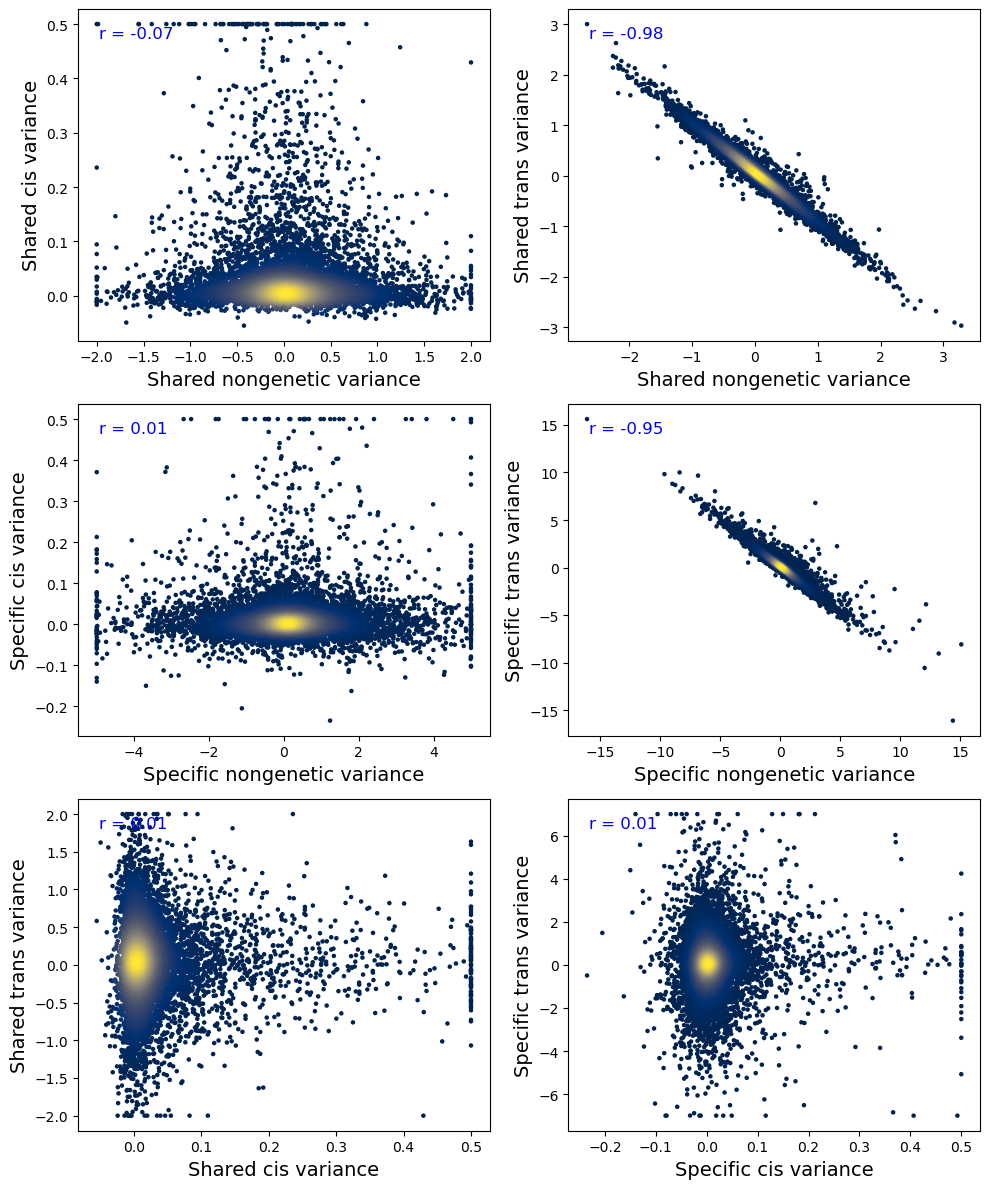

In [13]:
# env specificity vs trans specificity: zoom in
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# cis
plot.scatter(df['free:hom_e2'].clip(-2, 2), df['free:hom_g2'].clip(None, .5), s=5, heatscatter=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('Shared nongenetic variance', fontsize=14)
axes[0, 0].set_ylabel('Shared cis variance', fontsize=14)
corr = np.corrcoef(df['free:hom_e2'], df['free:hom_g2'])[0, 1]
axes[0, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[0, 0].transAxes, fontsize=12, color='b')

plot.scatter(df['free:w'].clip(-5, 5), df['free:v'].clip(None, .5), s=5, heatscatter=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Specific nongenetic variance', fontsize=14)
axes[1, 0].set_ylabel('Specific cis variance', fontsize=14)
corr = np.corrcoef(df['free:w'], df['free:v'])[0, 1]
axes[1, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[1, 0].transAxes, fontsize=12, color='b')

plot.scatter(df['free:hom_g2'].clip(None, .5), df['free:hom_g2_b'].clip(-2, 2), s=5, heatscatter=True, ax=axes[2, 0])
axes[2, 0].set_xlabel('Shared cis variance', fontsize=14)
axes[2, 0].set_ylabel('Shared trans variance', fontsize=14)
corr = np.corrcoef(df['free:hom_g2'], df['free:hom_g2_b'])[0, 1]
axes[2, 0].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[2, 0].transAxes, fontsize=12, color='b')

# trans
plot.scatter(df['free:hom_e2'], df['free:hom_g2_b'], s=5, heatscatter=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Shared nongenetic variance', fontsize=14)
axes[0, 1].set_ylabel('Shared trans variance', fontsize=14)
corr = np.corrcoef(df['free:hom_e2'], df['free:hom_g2_b'])[0, 1]
axes[0, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[0, 1].transAxes, fontsize=12, color='b')

plot.scatter(df['free:w'], df['free:v_b'], s=5, heatscatter=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Specific nongenetic variance', fontsize=14)
axes[1, 1].set_ylabel('Specific trans variance', fontsize=14)
corr = np.corrcoef(df['free:w'], df['free:v_b'])[0, 1]
axes[1, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[1, 1].transAxes, fontsize=12, color='b')

plot.scatter(df['free:v'].clip(None, .5), df['free:v_b'].clip(-7, 7), s=5, heatscatter=True, ax=axes[2, 1])
axes[2, 1].set_xlabel('Specific cis variance', fontsize=14)
axes[2, 1].set_ylabel('Specific trans variance', fontsize=14)
corr = np.corrcoef(df['free:v'], df['free:v_b'])[0, 1]
axes[2, 1].text(0.05, 0.95, f'r = {corr:.2f}', ha='left', va='top', transform=axes[2, 1].transAxes, fontsize=12, color='b')

fig.tight_layout()

[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


10288 10037 10037
(5623, 19) 5589 5613 3140
LOEUF


[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-20 13:20:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

LOEUF


[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-20 13:20:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

gene_length (kb)


[2025-11-20 13:20:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

mean_expr


[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:24 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:25 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:25 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:25 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

var_beta


[2025-11-20 13:20:25 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:25 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


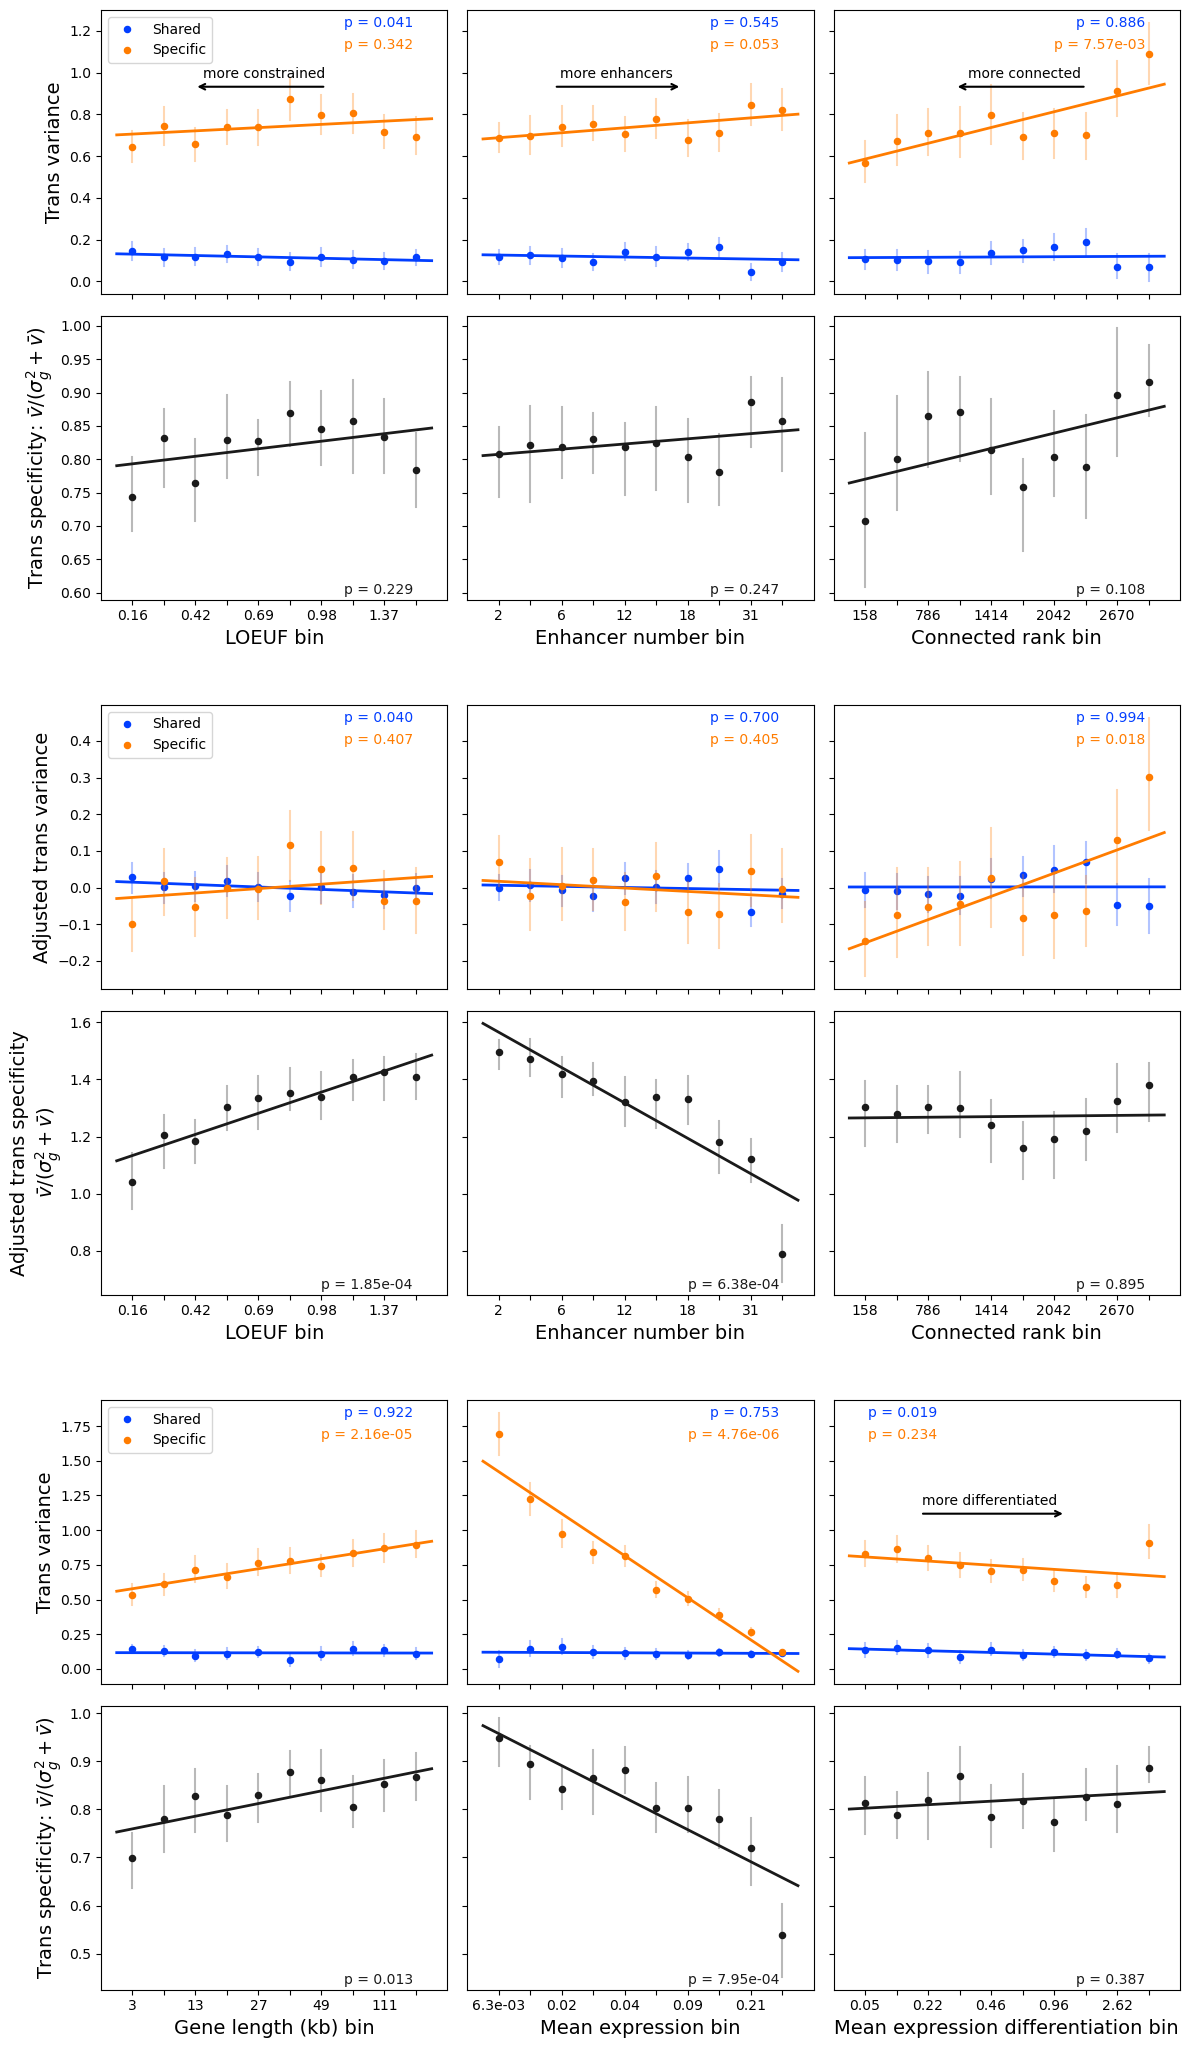

In [14]:
gf_df = df.merge(gf[['gene', 'LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr', 'var_beta']], on='gene')
print(df.shape[0], gf.shape[0], gf_df.shape[0])


fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
colors = sns.color_palette('bright')

# genomic feature
data = gf_df.copy()
data = data.rename(columns={'free:hom_g2_b': 'hom_g2_b', 'free:v_b': 'v_b'})
data = data.loc[data['g_b'] > 0]  # NOTE: removed negative gen variance
filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
data = data.loc[~filter]
# print(data.shape)
# print(np.sort(data['specificity_b'])[:10], np.sort(data['specificity_b'])[-10:])
# data = data.loc[(data['e_specificity'] > -10000)] # NOTE: remove outlier
print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# correct for gene length and mean expression
X = sm.add_constant(data[['gene_length (kb)', 'mean_expr', 'var_beta']])
for y in ['hom_g2_b', 'v_b', 'specificity_b']:
    model = sm.OLS(data[y], X).fit()
    data[y + '_resid'] = model.resid


# divide gene annotation into bins
annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank', 'gene_length (kb)', 'mean_expr', 'var_beta']
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)


fig, axes = plt.subplots(6, 3, figsize=(12, 21), sharey='row')

annotation_sets = [['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank'],
                   ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank'],
                   ['gene_length (kb)', 'mean_expr', 'var_beta']
                   ]
analyses = ['', '_resid', '']
for k, annotation_set, analysis in zip(range(3), annotation_sets, analyses):
    r = k * 2
    hom = 'hom_g2_b' + analysis
    spec = 'v_b' + analysis
    specificity = 'specificity_b' + analysis

    for j, annotation in enumerate(annotation_set):
        print(annotation)
        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, hom, 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, spec, 'mean', return_params=True)

        ax = axes[r, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y=hom, estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y=spec, estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        if k == 2 and j == 2:
            x = 0.1
            ha = 'left'
        else:
            x = 0.9
            ha = 'right'
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha=ha, va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha=ha, va='top', transform=ax.transAxes)

        x = 0.9
        ax2 = axes[r+1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, specificity, 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y=specificity, err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'
        elif annotation == 'mean_expr':
            xlabel = 'Mean expression bin'
        elif annotation == 'var_beta':
            xlabel = 'Mean expression differentiation bin'
        elif annotation == 'gene_length (kb)':
            xlabel = 'Gene length (kb) bin'


        # set x tick labels
        xticklabels = []
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 2 == 0:
                xticklabels.append(label.get_text())
            else:
                xticklabels.append('')
        ax2.set_xticks(ax2.get_xticks())
        ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs + 2)

        if j == 0:
            if k == 1:
                ax.set_ylabel('Adjusted trans variance', fontsize=fs+2)
                ax2.set_ylabel('Adjusted trans specificity\n' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs+2)
            else:
                ax.set_ylabel('Trans variance', fontsize=fs+2)
                ax2.set_ylabel('Trans specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs+2)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if j != 0:
            ax.legend().set_visible(False)
        else:
            ax.legend(loc='upper left', fontsize=fs-2)

# add arrow
y = 0.73
x = 0.65
axes[0, 0].annotate('', xy=(x - 0.38, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(x - .18, y + 0.02, 'more constrained', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 0].transAxes)

x = 0.25
axes[0, 1].annotate('', xy=(x + 0.37, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(x + 0.18, y + 0.02, 'more enhancers', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 1].transAxes)

x = 0.73
axes[0, 2].annotate('', xy=(x - 0.38, y), xytext=(x, y),
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(x - .18, y + 0.02, 'more connected', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[0, 2].transAxes)


y = 0.6
x = 0.25
axes[4, 2].annotate('', xy=(x + 0.42, y), xytext=(x, y),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[4, 2].transAxes)
axes[4, 2].text(x + .2, y + 0.02, 'more differentiated', ha='center', va='bottom',
                fontsize=fs-2, transform=axes[4, 2].transAxes)

fig.tight_layout()

for ax in np.concatenate([axes[1], axes[3], axes[5]]):
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])


# For figure 1

[2025-11-20 13:20:26 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-20 13:20:26 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


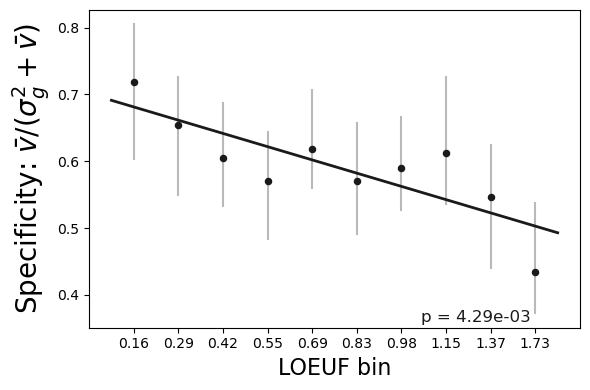

In [15]:
# Fig1 specificity vs loeuf
annotation = 'LOEUF'
grouped = data.groupby(annotation + '_bin', observed=True)

fig, ax = plt.subplots(figsize=(6, 4))

line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

# pointplot
sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                markers='.', estimator='median', linestyles='none', color='0.1', ax=ax)
xs = np.array(ax.get_xlim())
ax.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

ax.text(0.9, 0.01, f'p = {format_p(p)}', fontsize=fs, color='0.1', ha='right', va='bottom', transform=ax.transAxes)

ax.set_xlabel('LOEUF bin', fontsize=fs + 4)
ax.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs + 8)

fig.tight_layout()

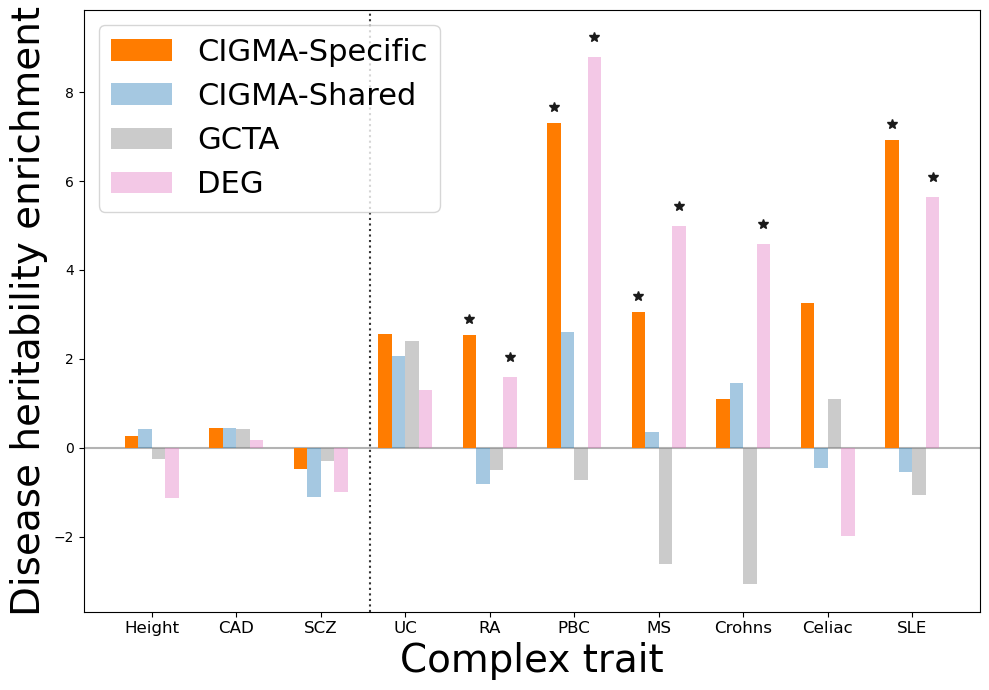

In [16]:
# Fig 1 LDSC
from matplotlib.colors import to_rgba

gene_set_order = ['var', 'shared', 'gcta', 'mean' ]

x = np.arange(ldsc_data['trait'].nunique())
width = 0.16
colors = [sns.color_palette('bright')[1], to_rgba(sns.color_palette()[0], alpha=.4), to_rgba(sns.color_palette()[7], alpha=.4), to_rgba(sns.color_palette()[6], alpha=.4)]
multiplier = -len(gene_set_order) / 2 + 0.5

fig, ax = plt.subplots(figsize=(10, 7))
for i, gene_set in enumerate(gene_set_order):
    if gene_set == 'mean':
        label = 'DEG'
    elif gene_set == 'var':
        label = 'CIGMA-Specific'
    elif gene_set =='shared':
        label = 'CIGMA-Shared'
    elif gene_set == 'gcta':
        label = 'GCTA'
    offset = width * multiplier
    set_data = ldsc_data.loc[ldsc_data['Name'] == gene_set]
    set_data = set_data.set_index('trait')
    # ys = np.log10(set_data['Coefficient_P_value'][traits]) * (-1)
    ys = set_data['Coefficient'][traits] * 1e8
    rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=colors[i])

    # add star
    for p, rect in zip(set_data['empirical_p'][traits], rects):
        if p <= 0.05:
            ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                    color='0.1', markersize=7)

    multiplier += 1
# ax.set_ylabel('$-log_{10}(p)$ for enrichment', fontsize=fs + 18)
ax.set_ylabel('Disease heritability enrichment', fontsize=fs+16)
ax.set_xlabel('Complex trait', fontsize=fs + 16)
# ax.set_title('LDSC', fontsize=fs + 22, fontweight='bold')

ax.set_xticks(x, traits, fontsize=fs)
ax.legend(loc='upper left', fontsize=fs + 10)
ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
# ax.axhline(-np.log10(0.05), linestyle=(0, (6, 6)), color='0.7', zorder=0)
ax.axhline(0, linestyle='-', color='0.7', zorder=0)

fig.tight_layout()

# Supp adjust for mean genes

In [18]:
# LDSC
## data
demeaned_ldscs = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_200/window_500000/he.{gwas}.controlmean.cell_type_results.txt'
                    for gwas in raw_traits] 

demeaned_ldsc_data = []
for stacked_f, trait in zip(demeaned_ldscs, raw_traits):
    tmp = pd.read_table(stacked_f)
    if trait == 'Lupus':
        trait = 'SLE'
    tmp['trait'] = trait
    demeaned_ldsc_data.append(tmp)

demeaned_ldsc_data = pd.concat(demeaned_ldsc_data, ignore_index=True)

[2025-11-11 10:39:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7043, 31) (7042, 3) 6996 7028 3828
(3828, 3)
Mega regression:
 const                      2.704437e-11
combined_connected_rank    2.813007e-05
dtype: float64
-1.6132087878701145
TtestResult(statistic=np.float64(6.498648728975455), pvalue=np.float64(9.148060092526098e-11), df=np.float64(3826.0))
LOEUF


[2025-11-11 10:39:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 10:39:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:46 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 10:39:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_539401/3786561555.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


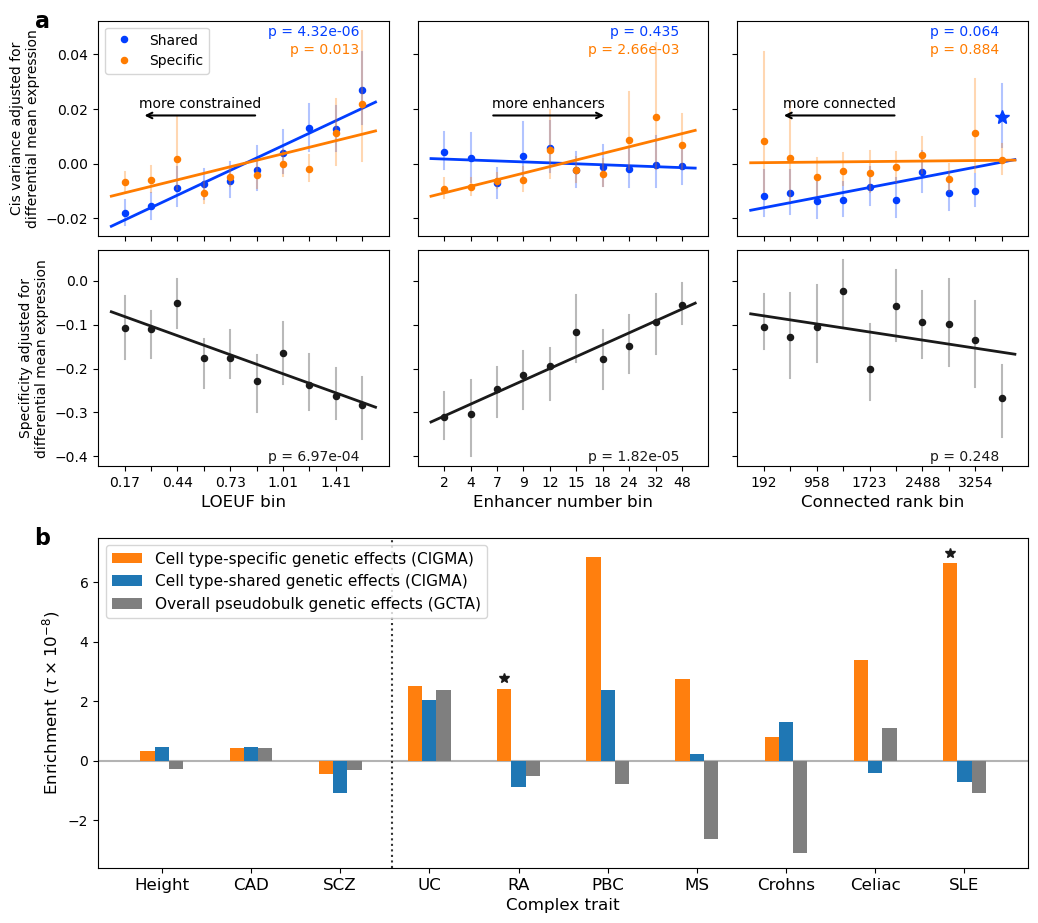

In [19]:
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')
fig = plt.figure(1, figsize=(12, 11))
gs = gridspec.GridSpec(30, 3, wspace=0.1, hspace=1)

# genomic feature
data = gf.copy()
data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
print(data.shape, data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].dropna(how='all').shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

# adjust DEG
ys = ['hom_g2', 'V', 'specificity']
for y in ys:
    X = sm.add_constant(data['var_beta'])
    model = sm.OLS(data[y], X).fit()
    data[y] = model.resid

# divide gene annotation into bins
annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)

# mega regression for combined connectivity
connectivity_data = data[['hom_g2', 'combined_connected_rank', 'combined_connected_rank_bin']].dropna()
print(connectivity_data.shape)
X = sm.add_constant(connectivity_data['combined_connected_rank'])
model = sm.OLS(connectivity_data['hom_g2'], X).fit()
# print(model.summary())
print('Mega regression:\n', model.pvalues)


# t test
least_connected_bin = connectivity_data['combined_connected_rank_bin'].max()
least_connected = connectivity_data.loc[connectivity_data['combined_connected_rank_bin'] == least_connected_bin]
other_connected = connectivity_data.loc[connectivity_data['combined_connected_rank_bin'] != least_connected_bin]
print(least_connected['hom_g2'].mean() / other_connected['hom_g2'].mean())
print(stats.ttest_ind(least_connected['hom_g2'], other_connected['hom_g2']))


ax11 = fig.add_subplot(gs[:8, 0])
ax12 = fig.add_subplot(gs[:8, 1], sharey=ax11)
ax13 = fig.add_subplot(gs[:8, 2], sharey=ax11)
ax21 = fig.add_subplot(gs[8:16, 0], sharex=ax11)
ax22 = fig.add_subplot(gs[8:16, 1], sharex=ax12, sharey=ax21)
ax23 = fig.add_subplot(gs[8:16, 2], sharex=ax13, sharey=ax21)
axes = np.array([[ax11, ax12, ax13],
                [ax21, ax22, ax23]])


for j, annotation in enumerate(annotations):
    print(annotation)
    grouped = data.groupby(annotation + '_bin', observed=True)

    line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

    ax = axes[0, j]
    # point plot
    sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)

    # add p values
    x = 0.9
    y = 0.98
    ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
    y -= .08
    ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


    ax2 = axes[1, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    # pointplot
    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                    markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
    xs = np.array(ax2.get_xlim())
    ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

    ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

    xlabel = re.sub('_', ' ', annotation + '_bin')
    if annotation == 'ActivityLinking_EnhancerNumber':
        xlabel = 'Enhancer number bin'
    elif annotation == 'combined_connected_rank':
        xlabel = 'Connected rank bin'

    if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
        # set x tick labels
        xticklabels = []
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 2 == 0:
                xticklabels.append(label.get_text())
            else:
                xticklabels.append('')
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(xticklabels)

    ax2.set_xlabel(xlabel, fontsize=fs)

    if j == 0:
        ax.set_ylabel('Cis variance adjusted for\ndifferential mean expression', fontsize=fs-2)
        ax2.set_ylabel('Specificity adjusted for\ndifferential mean expression', fontsize=fs-2)
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax2.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        ax2.set_ylabel('')
    
    if j != 0:
        ax.legend().set_visible(False)
    else:
        ax.legend(loc='upper left', fontsize=fs-2)

# add arrow
arrow_position = (0.55, 0.56)
axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(0.35, 0.58, 'more constrained', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 0].transAxes)

axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
        arrowprops=dict(arrowstyle='->', lw=1.5),
        fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
axes[0, 2].text(0.35, 0.58, 'more connected', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 2].transAxes)

axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(0.45, 0.58, 'more enhancers', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 1].transAxes)


# add a star to connectedness vs shared
# print(data.head())
# print(axes[0, 2].get_xlim())
axes[0, 2].plot(9, data.loc[data['combined_connected_rank_bin'] == data['combined_connected_rank_bin'].max(), 'hom_g2'].mean(), marker='*', color=colors[0], markersize=10, zorder=10)


## LDSC
# ax = fig.add_subplot(gs[18:, 0])
ax = fig.add_subplot(gs[18:, :])
demeaned_gene_set_order = ['var', 'shared', 'gcta']

x = np.arange(demeaned_ldsc_data['trait'].nunique())
width = 0.16
colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[7], sns.color_palette()[6]]
multiplier = -len(demeaned_gene_set_order) / 2 + 0.5
# print(demeaned_ldsc_data.head())

for i, gene_set in enumerate(demeaned_gene_set_order):
    if gene_set == 'mean':
        label = 'Cell type-specific mean expression (DEG)'
    elif gene_set == 'var':
        label = 'Cell type-specific genetic effects (CIGMA)'
    elif gene_set =='shared':
        label = 'Cell type-shared genetic effects (CIGMA)'
    elif gene_set == 'gcta':
        label = 'Overall pseudobulk genetic effects (GCTA)'
    offset = width * multiplier
    set_data = demeaned_ldsc_data.loc[demeaned_ldsc_data['Name'] == gene_set]
    set_data = set_data.set_index('trait')
    # ys = np.log10(set_data['Coefficient_P_value'][traits]) * (-1)
    ys = set_data['Coefficient'][traits] * 1e8
    rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=colors[i])
    # add star
    for p, rect in zip(set_data['Coefficient_P_value'][traits], rects):
        if p < 0.05:
            ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                    color='0.1', markersize=7)

    multiplier += 1
ax.set_ylabel(r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs)
ax.set_xlabel('Complex trait', fontsize=fs)

ax.set_xticks(x, traits, fontsize=fs)
ax.legend(loc='upper left', fontsize=fs-1)
ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
ax.axhline(0, linestyle='-', color='0.7', zorder=0)

fig.text(0.085, .89, 'a', fontsize=fs + 4, fontweight='bold', va='top', ha='right')
fig.text(0.085, .42, 'b', fontsize=fs + 4, fontweight='bold', va='top', ha='right')

fig.tight_layout()

# Supp Gene features

[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(10035, 3) 9970 10017 5523
(6578, 3) 6532 6565 3558


[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:39:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

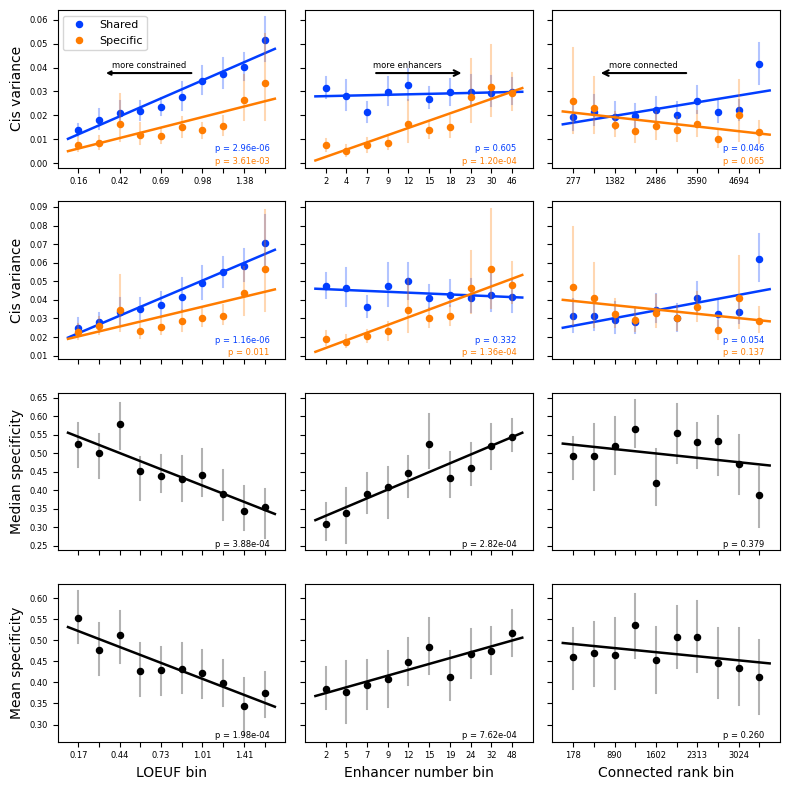

In [20]:
# par
fs = 8
lw = 1.8
s = 4
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

data = gf.copy()
data2 = gf.copy()
data = data.loc[data['g'] > 0]  # remove negative genes
data = data.loc[data['std_specificity'] < 100]  # remove outlier genes
# rerank connectness
data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')
data2['combined_connected_rank'] = data2['combined_connected_rank'].rank(method='first')

annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
print(data2[annotations].dropna(how='all').shape, (~data2['LOEUF'].isna()).sum(), (~data2['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data2['combined_connected_rank'].isna()).sum())
print(data[annotations].dropna(how='all').shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())

# divide gene annotation into bins
for annotation in annotations:
    data = plot.bin_gene_annotation(data, annotation, 10)
    data2 = plot.bin_gene_annotation(data2, annotation, 10)

# plot
colors = sns.color_palette('bright')
fig, axes = plt.subplots(nrows=4, ncols=len(annotations), figsize=(8, 8), sharey='row')

for j, annotation in enumerate(annotations):
    grouped = data.groupby(annotation + '_bin', observed=True)
    grouped2 = data2.groupby(annotation + '_bin', observed=True)

    # all genes
    line1, p1, slope1, intercept1 = plot.meta_regression(grouped2, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped2, 'V', 'mean', return_params=True)

    ax = axes[0, j]
    
    sns.pointplot(data=data2, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data2, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')

    ax.set_ylabel('Cis variance')
    ax.set_xlabel('')

    # add p values
    y = 0.01
    ax.text(0.93, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='bottom', transform=ax.transAxes)
    y += .08
    ax.text(0.93, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='bottom', transform=ax.transAxes)


    # filtered genes
    line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
    line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

    ax = axes[1, j]

    sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Shared', ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
    sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                label=r'Specific', ax=ax)
    ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')

    ax.set_ylabel('Cis variance')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)

    # add p values
    y = 0.01
    ax.text(0.93, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='bottom', transform=ax.transAxes)
    y += .08
    ax.text(0.93, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='bottom', transform=ax.transAxes)


    ax = axes[2, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', estimator='median',
                markers='.', linestyles='none', color='k', err_kws={'alpha': alpha, 'linewidth': 1.5}, ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope * xs + intercept, color='k', lw=lw, linestyle='-')

    ax.set_ylabel('Median specificity')

    ax.text(0.93, .01, f'p = {format_p(p)}', fontsize=fs-2, color='k', ha='right', va='bottom', transform=ax.transAxes)
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_xlabel('')


    ax = axes[3, j]
    line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'mean', return_params=True)

    sns.pointplot(data=data, x=annotation + '_bin', y='specificity', estimator='mean',
                markers='.', linestyles='none', color='k', err_kws={'alpha': alpha, 'linewidth': 1.5}, ax=ax)
    xs = np.array(ax.get_xlim())
    ax.plot(xs, slope * xs + intercept, color='k', lw=lw, linestyle='-')

    ax.set_ylabel('Mean specificity')

    ax.text(0.93, .01, f'p = {format_p(p)}', fontsize=fs-2, color='k', ha='right', va='bottom', transform=ax.transAxes)

    # set x label
    xlabel = re.sub('_', ' ', annotation + '_bin')
    if annotation == 'ActivityLinking_EnhancerNumber':
        xlabel = 'Enhancer number bin'
    elif annotation == 'combined_connected_rank':
        xlabel = 'Connected rank bin'
    ax.set_xlabel(xlabel)

    # set x tick labels
    if annotation in ['LOEUF', 'combined_connected_rank']:
        for ax in [axes[0, j], axes[3, j]]:
            xticklabels = []
            for i, label in enumerate(ax.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(xticklabels)


# legend
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.legend(loc='upper left', fontsize=fs)
    else:
        ax.legend().set_visible(False)
    ax.tick_params(axis='both', labelsize=fs-2)


# add arrow
x, y = 0.6, 0.6
arrow_position = (x, y)
length = 0.4
axes[0, 0].annotate('', xy=(arrow_position[0] - length, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=fs-2, ha='center', va='center', xycoords=axes[0, 0].transAxes)
axes[0, 0].text(0.4, 0.62, 'more constrained', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 0].transAxes)

axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - length + 0.1, arrow_position[1]),
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
axes[0, 1].text(0.45, 0.62, 'more enhancers', ha='center', va='bottom', 
                fontsize=fs-2, transform=axes[0, 1].transAxes)

if 'combined_connected_rank' in annotations:
    axes[0, 2].annotate('', xy=(arrow_position[0] - length, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.4, 0.62, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

fig.tight_layout()

# LDSC random genes

In [10]:
ldscrandom = LDSCRANDOM.copy()
ldscrandom_pos = ldscrandom.loc[ldscrandom['gwas'].isin(pos_traits)]
ldscrandom_main = LDSCRANDOM_MAIN.copy()
ldscrandom_pos_main = LDSCRANDOM_POS_MAIN.copy()
ngenes = ldscrandom['ngene'].unique()
binsizes = ldscrandom['binsize'].unique()
nearbywindows = ldscrandom['nearbywindow'].unique()
gsets = ldscrandom['gset'].unique()

In [6]:
print(ldscrandom_pos_main['gwas'].unique())

['UC' 'RA' 'PBC' 'MS' 'Crohns' 'Celiac' 'SLE']


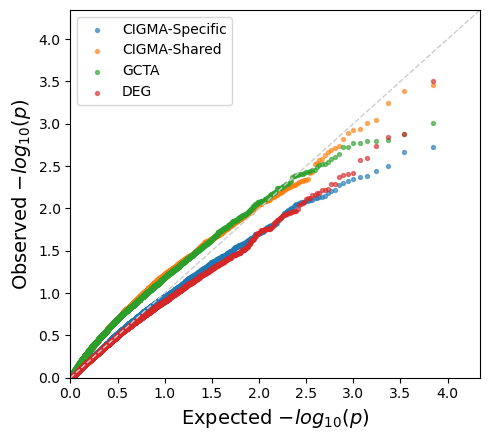

In [11]:
# Q-Q plot
fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))

for i, gset in enumerate(['var', 'shared', 'gcta', 'mean']):
    group = ldscrandom_pos_main.loc[ldscrandom_pos_main['gset'] == gset]
    if gset == 'var':
        gset = 'CIGMA-Specific'
    elif gset == 'mean':
        gset = 'DEG'
    elif gset == 'shared':
        gset = 'CIGMA-Shared'
    elif gset == 'gcta':
        gset = 'GCTA'

    # QQ plot
    observed = -np.log10(np.sort(group['Coefficient_P_value'].values))
    expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
    ax.scatter(expected, observed, s=8, alpha=0.6, label=gset, color=sns.color_palette()[i])
maxval = max(observed.max(), expected.max()) + 0.5
ax.plot([0, maxval], [0, maxval], color='0.8', linestyle='--', lw=1)
ax.set_xlim(0, maxval)
ax.set_ylim(0, maxval)
ax.legend()

ax.set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
ax.set_ylabel(r'Observed $-log_{10}(p)$', fontsize=fs+2)
fig.tight_layout()

In [7]:
print(-np.log10(1 / (7 * 999)))
print(-np.log10(1 / (6 * 999)))

3.8446635282402393
3.7777167386096258


In [102]:
# # Q-Q plot
# fs = 12

# fig, axes = plt.subplots(2, 2, figsize=(9, 8), sharex=True, sharey=True)

# for i, gset in enumerate(['var', 'shared', 'gcta', 'mean']):
#     group = ldscrandom_pos_main.loc[ldscrandom_pos_main['gset'] == gset]
#     if gset == 'var':
#         gset = 'CIGMA-Specific'
#     elif gset == 'mean':
#         gset = 'DEG'
#     elif gset == 'shared':
#         gset = 'CIGMA-Shared'
#     elif gset == 'gcta':
#         gset = 'GCTA'
#     ax1 = axes.flatten()[i]
#     # ax2 = axes[i, 1]
#     # QQ plot
#     observed = -np.log10(np.sort(group['Coefficient_P_value'].values))
#     expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
#     ax1.scatter(expected, observed, s=8, color='0.1', alpha=0.6)
#     maxval = max(observed.max(), expected.max()) + 0.5
#     ax1.plot([0, maxval], [0, maxval], color='0.8', linestyle='--', lw=1)
#     ax1.set_xlim(0, maxval)
#     ax1.set_ylim(0, maxval)
#     ax1.set_ylabel(r'Observed $-log_{10}(p)$' f' for\n{gset} matched genes', fontsize=fs+2)
#     # ax1.set_title(f'Control genes matching {gset}', fontsize=fs+2)

#     # # QQ for each trait
#     # ax = ax2
#     # for trait in pos_traits:
#     #     trait_data = group.loc[group['gwas'] == trait]
#     #     # print(trait_data.shape)
#     #     observed = -np.log10(np.sort(trait_data['Coefficient_P_value'].values))
#     #     expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
#     #     ax.scatter(expected, observed, s=6, alpha=0.6, label=trait)

#     # maxval = max(-np.log10(ldscrandom_pos_main['Coefficient_P_value'].values.min()), expected.max()) + 0.5
#     # ax.plot([0, maxval], [0, maxval], color='k', linestyle='--', lw=1)
#     # ax.set_xlim(0, maxval)
#     # ax.set_ylim(0, maxval)
#     # # ax.set_title(f'Control genes matching {gset}', fontsize=fs+2)

#     # if i == 0:
#     #     ax.legend(fontsize=fs-2, markerscale=2)

# axes[-1, 0].set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
# axes[-1, 1].set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
# fig.tight_layout()

In [103]:
# # Q-Q plot
# fs = 12

# fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharex='col', sharey='col')

# for i, gset in enumerate(['var', 'mean', 'shared', 'gcta']):
#     group = ldscrandom_pos_main.loc[ldscrandom_pos_main['gset'] == gset]
#     if gset == 'var':
#         gset = 'CIGMA-Specific'
#     elif gset == 'mean':
#         gset = 'DEG'
#     elif gset == 'shared':
#         gset = 'CIGMA-Shared'
#     elif gset == 'gcta':
#         gset = 'GCTA'
#     ax1 = axes[i, 0]
#     ax2 = axes[i, 1]
#     # QQ plot
#     observed = -np.log10(np.sort(group['Coefficient_P_value'].values))
#     expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
#     ax1.scatter(expected, observed, s=8, color='0.1', alpha=0.6)
#     maxval = max(observed.max(), expected.max()) + 0.5
#     ax1.plot([0, maxval], [0, maxval], color='0.8', linestyle='--', lw=1)
#     ax1.set_xlim(0, maxval)
#     ax1.set_ylim(0, maxval)
#     ax1.set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
#     ax1.set_ylabel(r'Observed $-log_{10}(p)$', fontsize=fs+2)
#     ax1.set_title(f'Control genes matching {gset}', fontsize=fs+2)
#     # ax1.axhline(-np.log10(0.001), linestyle=(0, (6, 6)), color='0.7', zorder=0)

#     # Histogram
#     # ax2.hist(group['Coefficient_P_value'].values, bins=np.arange(0, 0.01, 0.001), color='0.2', alpha=0.7)
#     ax2.hist(group['Coefficient_P_value'].values, bins=50, color='0.2', alpha=0.7)
#     ax2.set_xlabel('P-value', fontsize=fs+2)
#     ax2.set_ylabel('Count', fontsize=fs+2)
#     ax2.set_title(f'Control genes matching {gset}', fontsize=fs+2)

# fig.tight_layout()

In [104]:
# # QQ for each trait
# fs = 12
# fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

# for i, gset in enumerate(['var', 'mean', 'shared', 'gcta']):
#     group = ldscrandom_pos_main.loc[ldscrandom_pos_main['gset'] == gset]
#     if gset == 'var':
#         gset = 'CIGMA-Specific'
#     elif gset == 'mean':
#         gset = 'DEG'
#     elif gset == 'shared':
#         gset = 'CIGMA-Shared'
#     elif gset == 'gcta':
#         gset = 'GCTA'

#     ax = axes[i // 2, i % 2]
#     for trait in pos_traits:
#         trait_data = group.loc[group['gwas'] == trait]
#         observed = -np.log10(np.sort(trait_data['Coefficient_P_value'].values))
#         expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
#         ax.scatter(expected, observed, s=6, alpha=0.3, label=trait)
#     # for i, trait in enumerate(neg_traits):
#     #     trait_data = ldscrandom.loc[ldscrandom['gwas'] == trait]
#     #     observed = -np.log10(np.sort(trait_data['Coefficient_P_value'].values))
#     #     expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
#     #     ax.scatter(expected, observed, s=8, alpha=0.6, label=trait, color=f'{i/10 + 0.7}')

#     maxval = max(observed.max(), expected.max()) + 0.5
#     ax.plot([0, maxval], [0, maxval], color='k', linestyle='--', lw=1)
#     ax.set_xlim(0, maxval)
#     ax.set_ylim(0, maxval)
#     ax.set_title(f'Control genes matching {gset}', fontsize=fs)

#     if i == 0:
#         ax.legend(fontsize=fs-2)

# axes[1, 0].set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
# axes[1, 1].set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
# axes[0, 0].set_ylabel(r'Observed $-log_{10}(p)$', fontsize=fs+2)
# axes[1, 0].set_ylabel(r'Observed $-log_{10}(p)$', fontsize=fs+2)
# fig.tight_layout()

In [17]:
# empirical p values
# print(ldsc_data.loc[ldsc_data['Name'] == 'var'])

# compare p values
for ngene, binsize, nearbywindow in zip([200, 0, 200, 200], [500, 500, 500, 1000], [500000, 1000000, 1000000, 1000000]):
    print(ngene, binsize, nearbywindow)
    group = ldscrandom.loc[(ldscrandom['ngene'] == ngene) & (ldscrandom['binsize'] == binsize) & (ldscrandom['nearbywindow'] == nearbywindow)]
    print(group.shape)
    for gset in ['var', 'shared', 'gcta', 'mean']:
        print(gset)
        # for trait in pos_traits:
        for trait in raw_traits:
            trait_data = group.loc[(group['gwas'] == trait) & (group['gset'] == gset)]
            if trait == 'Lupus':
                trait = 'SLE'
            real_p = ldsc_data.loc[(ldsc_data['trait'] == trait) & (ldsc_data['Name'] == gset), 'Coefficient_P_value'].values[0]
            empirical_p = (trait_data.loc[trait_data['Coefficient_P_value'] <= real_p].shape[0] + 1) / (trait_data.shape[0] + 1)
            real_coef = ldsc_data.loc[(ldsc_data['trait'] == trait) & (ldsc_data['Name'] == gset), 'Coefficient'].values[0]
            empirical_p2 = (trait_data.loc[trait_data['Coefficient'] >= real_coef].shape[0] + 1) / (trait_data.shape[0] + 1)
            print(f'{trait}:\tldsc p-value = {real_p:.3f}\tp-value-based empirical p-value = {empirical_p:.3f}\tcoefficient-based empirical p-value = {empirical_p2:.3f}')


200 500 500000
(39960, 10)
var
Height:	ldsc p-value = 0.392	p-value-based empirical p-value = 0.421	coefficient-based empirical p-value = 0.381
CAD:	ldsc p-value = 0.169	p-value-based empirical p-value = 0.258	coefficient-based empirical p-value = 0.249
SCZ:	ldsc p-value = 0.751	p-value-based empirical p-value = 0.749	coefficient-based empirical p-value = 0.724
UC:	ldsc p-value = 0.090	p-value-based empirical p-value = 0.060	coefficient-based empirical p-value = 0.055
RA:	ldsc p-value = 0.020	p-value-based empirical p-value = 0.014	coefficient-based empirical p-value = 0.013
PBC:	ldsc p-value = 0.051	p-value-based empirical p-value = 0.050	coefficient-based empirical p-value = 0.021
MS:	ldsc p-value = 0.036	p-value-based empirical p-value = 0.030	coefficient-based empirical p-value = 0.029
Crohns:	ldsc p-value = 0.351	p-value-based empirical p-value = 0.449	coefficient-based empirical p-value = 0.439
Celiac:	ldsc p-value = 0.142	p-value-based empirical p-value = 0.094	coefficient-based

In [106]:
# %%R
# rm(list = ls())
# library('rmeta')

In [107]:
# %R -i ldsc_data

In [108]:
# %%R
# r_ldscrandom <- read.table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldscrandom/cell_type_results.txt', header=TRUE)
# # print(head(r_ldscrandom))
# r_ldscrandom_pos <- subset(r_ldscrandom, gwas %in% c('UC', 'RA', 'PBC', 'MS', 'Crohns', 'Celiac', 'Lupus', 'SLE'))

# n_set <- length(unique(r_ldscrandom$set))
# ps <- c(NA) * n_set
# for (i in 1:n_set) {
#     sub_df <- subset(r_ldscrandom_pos, set == as.character(i - 1))
#     ps[i] <- meta.summaries(sub_df$Coefficient, sub_df$Coefficient_std_error)$test[2]
# }

In [109]:
# %%R
# # print(ldsc_data)
# var_ldsc_data <- subset(ldsc_data, Name == 'var')
# var_ldsc_data_pos <- subset(var_ldsc_data, trait %in% c('UC', 'RA', 'PBC', 'MS', 'Crohns', 'Celiac', 'SLE'))
# print(var_ldsc_data_pos)
# var_ldsc_meta <- meta.summaries(var_ldsc_data$Coefficient, var_ldsc_data$Coefficient_std_error)
# real_p <- var_ldsc_meta$test[2]
# print(real_p)
# # print(str(var_ldsc_meta))

In [110]:
# from rpy2.robjects import r
# random_ps = np.array(r['ps'])
# real_p = r['real_p']

In [111]:
# # QQ plot
# fs = 12
# fig, ax = plt.subplots(figsize=(6, 5.5))
# observed = -np.log10(np.sort(random_ps))
# expected = -np.log10((np.arange(1, len(observed) + 1) / (len(observed) + 1)))
# ax.scatter(expected, observed, s=8, color='0.1', alpha=0.6)
# maxval = max(observed.max(), expected.max()) + 0.5
# ax.plot([0, maxval], [0, maxval], color='0.8', linestyle='--', lw=1)
# ax.set_xlim(0, maxval)
# ax.set_ylim(0, maxval)
# ax.set_xlabel(r'Expected $-log_{10}(p)$', fontsize=fs+2)
# ax.set_ylabel(r'Observed $-log_{10}(p)$', fontsize=fs+2)
# ax.axhline(-np.log10(real_p), color='r', linestyle=':', lw=1)
# fig.tight_layout()

# print(f'Empirical p-value from R: { (random_ps <= real_p).sum() / len(random_ps) }')

# LDSC replication

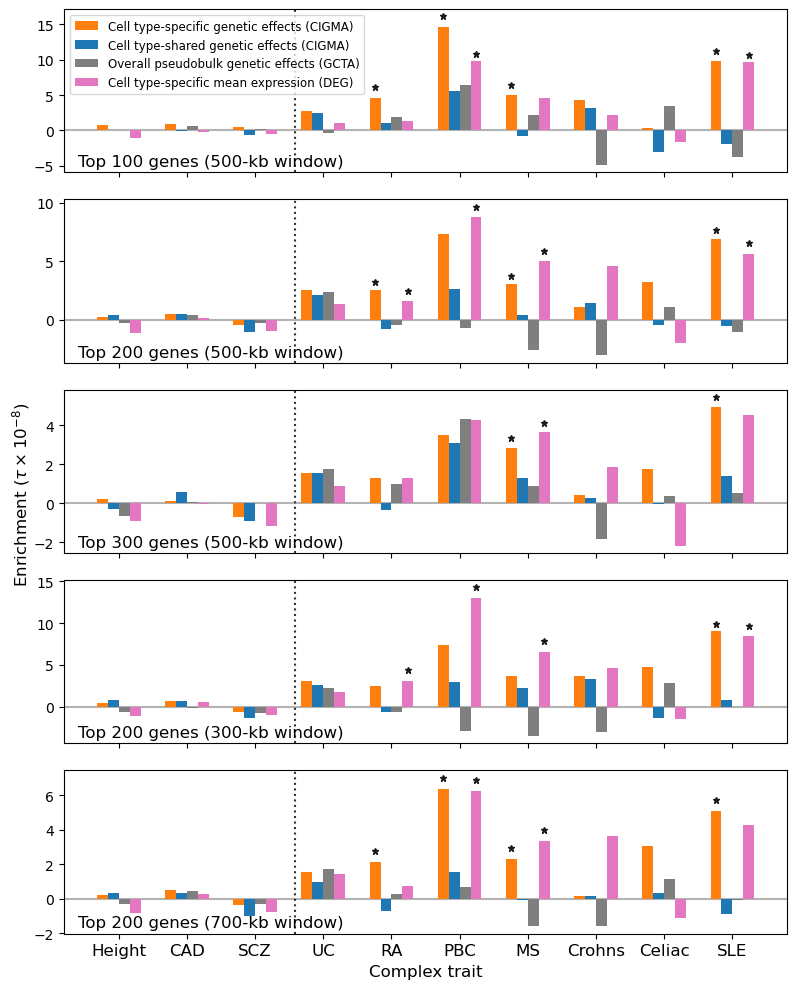

In [ ]:
# LDSC
fs = 12
## data
ldscs_window300k = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_200/window_300000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

ldscs_window700k = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_200/window_700000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

ldscs_top100 = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_100/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

ldscs_top200 = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_200/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

ldscs_top300 = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_300/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

# ldscs_top0 = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/top_0/window_500000/he.{gwas}.cell_type_results.txt'
#                     for gwas in traits] 


analyses = ['Top 100 genes (500-kb window)', 'Top 200 genes (500-kb window)', 'Top 300 genes (500-kb window)', 'Top 200 genes (300-kb window)', 'Top 200 genes (700-kb window)']
results = [ldscs_top100, ldscs_top200, ldscs_top300, ldscs_window300k, ldscs_window700k]
ldsc_rep_data = []
for analysis, ldsc_f in zip(analyses, results):
    for f, trait in zip(ldsc_f, traits):
        tmp = pd.read_table(f)
        if trait == 'Lupus':
            trait = 'SLE'
        tmp['trait'] = trait
        tmp['analysis'] = analysis
        ldsc_rep_data.append(tmp)

ldsc_rep_data = pd.concat(ldsc_rep_data, ignore_index=True)
# print(ldsc_rep_data.loc[ldsc_rep_data['analysis'] == 'Top 200 genes (300-kb window)'])
# update Lupus to SLE
index = traits.index('Lupus')
traits[index] = 'SLE'


# plot
gene_set_order = ['var', 'shared', 'gcta', 'mean' ]
fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=True, sharey=False)
# fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=True, sharey=True)

x = np.arange(ldsc_data['trait'].nunique())
width = 0.16
colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[7], sns.color_palette()[6]]

for ax, analysis in zip(axes, analyses):
    multiplier = -len(gene_set_order) / 2 + 0.5
    tmp_data = ldsc_rep_data.loc[ldsc_rep_data['analysis'] == analysis]
    for i, gene_set in enumerate(gene_set_order):
        if gene_set == 'mean':
            label = 'Cell type-specific mean expression (DEG)'
        elif gene_set == 'var':
            label = 'Cell type-specific genetic effects (CIGMA)'
        elif gene_set =='shared':
            label = 'Cell type-shared genetic effects (CIGMA)'
        elif gene_set == 'gcta':
            label = 'Overall pseudobulk genetic effects (GCTA)'
        offset = width * multiplier
        set_data = tmp_data.loc[tmp_data['Name'] == gene_set]
        set_data = set_data.set_index('trait')
        # ys = np.log10(set_data['Coefficient_P_value'][traits]) * (-1)
        ys = set_data['Coefficient'][traits] * 1e8
        rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=colors[i])

        # add star
        for p, rect in zip(set_data['Coefficient_P_value'][traits], rects):
            if p < 0.05:
                ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .1, '*', 
                        color='0.1', markersize=5)

        multiplier += 1
    ax.text(0.02, 0.02, analysis, ha='left', va='bottom', fontsize=fs, transform=ax.transAxes)
    # ax.text(0.99, 0.95, analysis, ha='right', va='top', fontsize=fs, transform=ax.transAxes)

axes[0].set_ylabel(' ')
# fig.text(0.01, 0.5, '$-log_{10}(p)$ for the enrichment of disease heritability', fontsize=fs, va='center', ha='left', rotation='vertical')
fig.text(0.01, 0.5, r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs, va='center', ha='left', rotation='vertical')
axes[-1].set_xlabel('Complex trait', fontsize=fs)


axes[0].legend(loc='upper left', fontsize=fs-3.5)
axes[-1].set_xticks(x, traits, fontsize=fs)
for ax in axes:
    ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
    # ax.axhline(-np.log10(0.05), linestyle=(0, (6, 6)), color='0.7', zorder=0)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)

fig.tight_layout()

# LDSC per cell type

In [113]:
# data
perct_traits = raw_traits.copy()

ldscpercts = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldscperct/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in perct_traits] 

ldscperct_data = []
for stacked_f, trait in zip(ldscpercts, perct_traits):
    tmp = pd.read_table(stacked_f)
    if trait == 'Lupus':
        trait = 'SLE'
    tmp['trait'] = trait
    ldscperct_data.append(tmp)

ldscperct_df = pd.concat(ldscperct_data, ignore_index=True)
index = perct_traits.index('Lupus')
perct_traits[index] = 'SLE'
# ldscperct_df.to_csv('../../ldsc_per_ct.tsv', sep='\t', index=False)

perct_cts = ldscperct_df['Name'].unique()

In [114]:
print(ldscperct_df)

     Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait
0   CD4NC  1.384727e-08           1.965667e-08             0.240574  Height
1   CD4ET  1.408508e-08           2.552400e-08             0.290530  Height
2   CD8NC  6.048116e-09           1.807218e-08             0.368939  Height
3    BMem  5.227879e-09           1.667360e-08             0.376934  Height
4   CD8ET -1.656199e-09           2.262050e-08             0.529183  Height
..    ...           ...                    ...                  ...     ...
65    BIN  3.334683e-08           6.557823e-08             0.305550     SLE
66   BMem  4.586367e-08           1.107133e-07             0.339343     SLE
67  CD8NC  3.608092e-08           1.429231e-07             0.400347     SLE
68  CD4NC  1.320508e-08           5.803125e-08             0.409998     SLE
69  CD4ET  3.519287e-08           1.559064e-07             0.410705     SLE

[70 rows x 5 columns]


70 1.845098040014257


Text(0, 0.5, 'Observed  $-log_{10}(p)$')

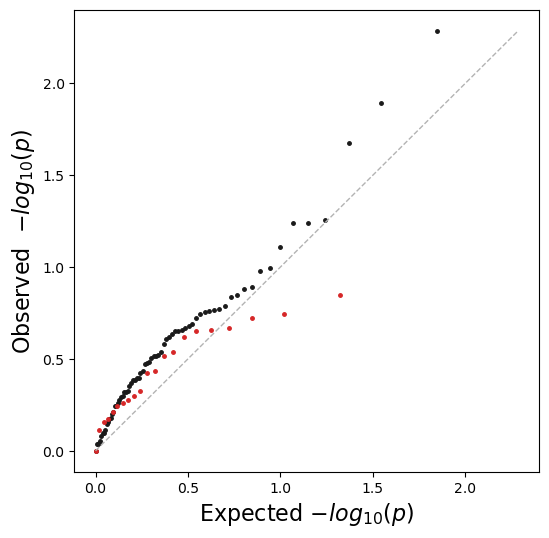

In [115]:
# Q-Q plot
tmp_df = ldscperct_df.copy()
tmp_df = tmp_df.sort_values(by='Coefficient_P_value')

fig, ax = plt.subplots(figsize=(6, 6))
observed = -np.log10(tmp_df['Coefficient_P_value'].values)
expected = -np.log10(np.linspace(1/len(observed), 1, len(observed)))
print(len(observed), expected.max())
ax.plot(expected, observed, '.', color='0.1', markersize=5)
tmp_filter = np.isin(tmp_df['trait'], neg_traits)
max_val = max(expected.max(), observed.max())

neg_observed = -np.log10(tmp_df.loc[tmp_filter, 'Coefficient_P_value'].values)
neg_expected = -np.log10(np.linspace(1/len(neg_observed), 1, len(neg_observed)))
ax.plot(neg_expected, neg_observed, '.', color=sns.color_palette()[3], markersize=5)

ax.plot([0, max_val], [0, max_val], color='0.7', linestyle='--', lw=1)
ax.set_xlabel('Expected ' + r'$-log_{10}(p)$', fontsize=fs + 4)
ax.set_ylabel('Observed ' + ' ' + r'$-log_{10}(p)$', fontsize=fs + 4)

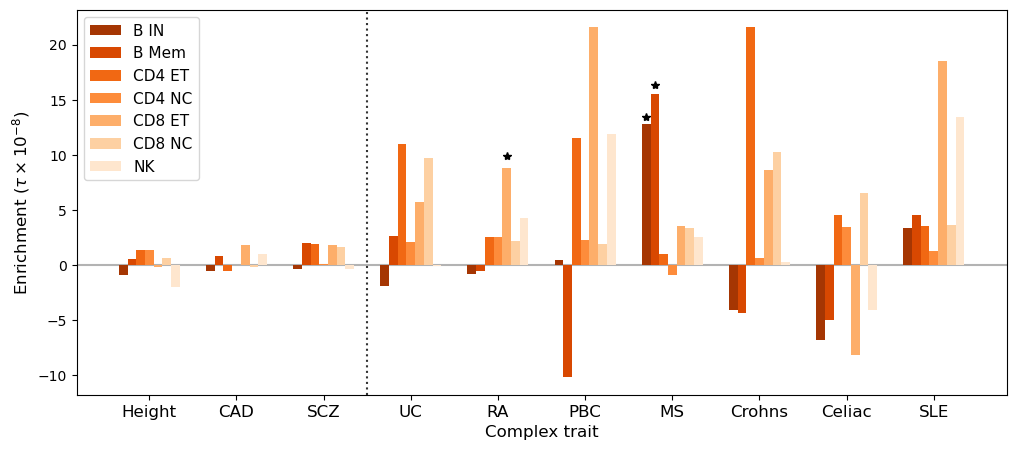

In [116]:
fs = 12

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
gene_set_order = perct_cts.copy()
gene_set_order.sort()

x = np.arange(ldscperct_df['trait'].nunique())
width = 0.1
# colors = [str(0.35 + 0.3 * i / (len(gene_set_order)-1)) for i in range(len(gene_set_order))]
colors = sns.color_palette("Oranges", n_colors=len(gene_set_order))[::-1]
multiplier = -len(gene_set_order) / 2 + 0.5

for i, gene_set in enumerate(gene_set_order):
    label = gene_set
    if gene_set == 'CD4NC':
        label = 'CD4 NC'
    elif gene_set == 'CD4ET':
        label = 'CD4 ET'
    elif gene_set == 'CD8NC':
        label = 'CD8 NC'
    elif gene_set == 'CD8ET':
        label = 'CD8 ET'
    elif gene_set == 'BMem':
        label = 'B Mem'
    elif gene_set == 'BIN':
        label = 'B IN'
    offset = width * multiplier
    set_data = ldscperct_df.loc[ldscperct_df['Name'] == gene_set]
    set_data = set_data.set_index('trait')
    ys = set_data['Coefficient'][perct_traits] * 1e8
    rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=colors[i])
    # add star
    for p, rect in zip(set_data['Coefficient_P_value'][perct_traits], rects):
        if p < 0.05:
            ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                    color='k', markersize=6)

    multiplier += 1

ax.set_ylabel(r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs)
# ax.set_ylabel(r'Regression coefficient, $\tau$ ($\times 10^{-8}$)', fontsize=fs)
ax.set_xlabel('Complex trait', fontsize=fs)

ax.set_xticks(x, perct_traits, fontsize=fs)
ax.legend(loc='upper left', fontsize=fs-1)
ax.axvline(len(neg_traits) - 0.55 + width / 2, linestyle=':', color='0.2')
ax.axhline(0, linestyle='-', color='0.7', zorder=0)


## Random genes

In [117]:
# keep: number of genes per cell type
for ct in cts:
    f = f'../../staging/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldscrandom/top_0_gset_{ct.replace(" ", "")}_bin_500_nearbygene_5e5/var.genes.txt'
    genes = np.loadtxt(f, dtype=str)
    print(f'Number of genes for {ct}: {len(genes)}')

# Number of genes for B IN: 20
# Number of genes for B Mem: 12
# Number of genes for CD4 ET: 14
# Number of genes for CD4 NC: 58
# Number of genes for CD8 ET: 27
# Number of genes for CD8 NC: 22
# Number of genes for NK: 49

Number of genes for B IN: 20
Number of genes for B Mem: 12
Number of genes for CD4 ET: 14
Number of genes for CD4 NC: 58
Number of genes for CD8 ET: 27
Number of genes for CD8 NC: 22
Number of genes for NK: 49


In [118]:
ldscrandom_perct = [pd.read_table(f'../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldscrandom/top_0_gset_{ct.replace(" ", "")}_bin_500_nearbygene_5e5/window_500000/he.cell_type_results.txt').assign(ct=ct) for ct in cts]
ldscrandom_perct = pd.concat(ldscrandom_perct, ignore_index=True)

# compare p values
results = {'ct': [], 'trait': [], 'empirical_p_value_based': [], 'empirical_p_coefficient_based': []}
for ct in cts:
    df = ldscrandom_perct.loc[ldscrandom_perct['ct'] == ct]
    for trait in raw_traits:
        trait_data = df.loc[(df['gwas'] == trait)]
        if trait == 'Lupus':
            trait = 'SLE'
        real_p = ldscperct_df.loc[(ldscperct_df['trait'] == trait) & (ldscperct_df['Name'] == ct.replace(" ", "")), 'Coefficient_P_value'].values[0]
        empirical_p = (trait_data.loc[trait_data['Coefficient_P_value'] <= real_p].shape[0] + 1) / trait_data.shape[0]
        real_coef = ldscperct_df.loc[(ldscperct_df['trait'] == trait) & (ldscperct_df['Name'] == ct.replace(" ", "")), 'Coefficient'].values[0]
        empirical_p2 = (trait_data.loc[trait_data['Coefficient'] >= real_coef].shape[0] + 1) / trait_data.shape[0]
        # print(f'{trait}:\tldsc p-value = {real_p:.3f}\tp-value-based empirical p-value = {empirical_p:.3f}\tcoefficient-based empirical p-value = {empirical_p2:.3f}')
        results['ct'].append(ct)
        results['trait'].append(trait)
        results['empirical_p_value_based'].append(f'{real_coef * 10**8:.2f} ({real_p:.3f}, {empirical_p})')
        results['empirical_p_coefficient_based'].append(f'{real_p:.3f} ({empirical_p2})')
results = pd.DataFrame(results)

# order index by trait list (with Lupus -> SLE)
ordered_traits = ['Height', 'CAD', 'SCZ'] + sorted([t for t in traits if t not in ['Height', 'CAD', 'SCZ']])
results['trait'] = pd.Categorical(results['trait'], categories=ordered_traits, ordered=True)
display(results.pivot(index='trait', columns='ct', values='empirical_p_value_based').sort_index())
display(results.pivot(index='trait', columns='ct', values='empirical_p_coefficient_based'))

ct                      B IN                 B Mem                CD4 ET  \
trait                                                                      
Height  -0.92 (0.768, 0.713)   0.52 (0.377, 0.376)   1.41 (0.291, 0.232)   
CAD     -0.57 (0.673, 0.708)   0.84 (0.305, 0.319)  -0.53 (0.700, 0.686)   
SCZ     -0.31 (0.569, 0.574)   1.99 (0.215, 0.217)   1.87 (0.220, 0.217)   
Celiac  -6.80 (0.922, 0.871)  -4.98 (0.799, 0.727)   4.51 (0.330, 0.235)   
Crohns   -4.05 (0.888, 0.84)  -4.39 (0.801, 0.712)  21.58 (0.101, 0.049)   
MS      12.83 (0.005, 0.005)  15.53 (0.013, 0.008)   1.01 (0.430, 0.482)   
PBC      0.48 (0.477, 0.528)  -10.17 (0.912, 0.86)  11.49 (0.146, 0.138)   
RA      -0.84 (0.631, 0.709)  -0.49 (0.570, 0.605)    2.55 (0.333, 0.43)   
SLE      3.33 (0.306, 0.283)   4.59 (0.339, 0.323)   3.52 (0.411, 0.419)   
UC      -1.93 (0.716, 0.647)   2.66 (0.311, 0.272)  10.99 (0.078, 0.037)   

ct                    CD4 NC                CD8 ET                CD8 NC  \
trait                                                                      
Height   1.38 (0.241, 0.266)  -0.17 (0.529, 0.545)   0.60 (0.369, 0.387)   
CAD     -0.01 (0.505, 0.583)   1.86 (0.142, 0.102)  -0.16 (0.550, 0.568)   
SCZ      0.07 (0.470, 0.498)   1.86 (0.223, 0.295)   1.68 (0.189, 0.194)   
Celiac   3.44 (0.223, 0.171)  -8.11 (0.923, 0.881)   6.54 (0.174, 0.095)   
Crohns    0.61 (0.445, 0.56)   8.64 (0.172, 0.135)  10.27 (0.210, 0.196)   
MS      -0.93 (0.662, 0.795)   3.53 (0.203, 0.263)   3.33 (0.248, 0.299)   
PBC      2.30 (0.300, 0.425)  21.55 (0.128, 0.089)   1.93 (0.400, 0.503)   
RA       2.56 (0.132, 0.245)   8.85 (0.021, 0.012)   2.16 (0.263, 0.335)   
SLE      1.32 (0.410, 0.538)  18.53 (0.058, 0.024)   3.61 (0.400, 0.462)   
UC       2.08 (0.230, 0.258)   5.72 (0.170, 0.138)   9.71 (0.105, 0.067)   

ct                        NK  
trait                         
Height   -1.98 (0.998, 0.99)  
CAD       1.00 (0.181, 0.18)  
SCZ     -0.38 (0.615, 0.658)  
Celiac  -4.04 (0.832, 0.774)  
Crohns   0.26 (0.482, 0.553)  
MS       2.57 (0.176, 0.199)  
PBC     11.90 (0.163, 0.166)  
RA       4.30 (0.058, 0.059)  
SLE     13.45 (0.056, 0.016)  
UC      -0.09 (0.510, 0.558)

ct               B IN          B Mem         CD4 ET         CD4 NC  \
trait                                                                
Height  0.768 (0.703)  0.377 (0.391)   0.291 (0.24)  0.241 (0.167)   
CAD     0.673 (0.729)  0.305 (0.315)  0.700 (0.642)  0.505 (0.585)   
SCZ     0.569 (0.557)  0.215 (0.269)   0.220 (0.29)  0.470 (0.511)   
Celiac  0.922 (0.832)  0.799 (0.679)  0.330 (0.183)  0.223 (0.162)   
Crohns  0.888 (0.779)  0.801 (0.689)  0.101 (0.059)  0.445 (0.566)   
MS      0.005 (0.012)  0.013 (0.013)  0.430 (0.482)  0.662 (0.785)   
PBC      0.477 (0.53)  0.912 (0.861)  0.146 (0.228)  0.300 (0.473)   
RA       0.631 (0.71)  0.570 (0.591)  0.333 (0.354)  0.132 (0.229)   
SLE     0.306 (0.331)  0.339 (0.324)  0.411 (0.383)   0.410 (0.52)   
UC      0.716 (0.639)  0.311 (0.285)  0.078 (0.078)  0.230 (0.288)   

ct             CD8 ET         CD8 NC             NK  
trait                                                
Height  0.529 (0.562)  0.369 (0.386)  0.998 (0.986)  
CAD     0.142 (0.059)  0.550 (0.575)  0.181 (0.122)  
SCZ     0.223 (0.281)  0.189 (0.281)  0.615 (0.652)  
Celiac  0.923 (0.926)  0.174 (0.097)  0.832 (0.798)  
Crohns   0.172 (0.14)  0.210 (0.127)  0.482 (0.552)  
MS      0.203 (0.285)  0.248 (0.293)  0.176 (0.243)  
PBC     0.128 (0.024)   0.400 (0.52)  0.163 (0.038)  
RA      0.021 (0.008)  0.263 (0.329)  0.058 (0.024)  
SLE     0.058 (0.025)   0.400 (0.39)  0.056 (0.016)  
UC      0.170 (0.099)  0.105 (0.046)  0.510 (0.559)

# cCREs

In [5]:
# analyze immune CREs
cres = pd.read_table('../../data/catlas.gz')
assert cres.drop_duplicates(subset=['cre']).shape == cres.drop_duplicates(subset=['chr', 'start', 'end', 'cre']).shape

# extract immune cell types
immune_cell_types = ['Memory_B_Cell', 'Naive_T_cell', 'Natural_Killer_T_Cell', 'T_Lymphocyte_1_CD8+', 'T_lymphocyte_2_CD4+']
immune_cres = cres.loc[cres['cell_type'].isin(immune_cell_types)]
immune_cres_uniq = immune_cres.drop_duplicates(subset=['cre'])
T_cres = cres.loc[cres['cell_type'].isin(['Naive_T_cell', 'T_Lymphocyte_1_CD8+', 'T_lymphocyte_2_CD4+'])]
T_cres_uniq = T_cres.drop_duplicates(subset=['cre'])
perct_cres = {}
for ct in immune_cell_types:
    perct_cres[ct] = cres.loc[cres['cell_type'] == ct].drop_duplicates(subset=['cre'])

print(immune_cres_uniq.shape[0])

# # cres in only one cell type
# T_only_cres = T_cres_uniq.loc[(~T_cres_uniq['cre'].isin(perct_cres['Memory_B_Cell']['cre'])) & (~T_cres_uniq['cre'].isin(perct_cres['Natural_Killer_T_Cell']['cre']))]
# NK_only_cres = perct_cres['Natural_Killer_T_Cell'].loc[(~perct_cres['Natural_Killer_T_Cell']['cre'].isin(perct_cres['Memory_B_Cell']['cre'])) & (~perct_cres['Natural_Killer_T_Cell']['cre'].isin(T_cres_uniq['cre']))]
# B_only_cres = perct_cres['Memory_B_Cell'].loc[(~perct_cres['Memory_B_Cell']['cre'].isin(T_cres_uniq['cre'])) & (~perct_cres['Memory_B_Cell']['cre'].isin(perct_cres['Natural_Killer_T_Cell']['cre']))]
# print(f'Number of CREs in T-cells: {T_cres_uniq.shape[0]}')
# print(f'Number of CREs in NK-cells: {perct_cres["Natural_Killer_T_Cell"].shape[0]}')
# print(f'Number of CREs in B-cells: {perct_cres["Memory_B_Cell"].shape[0]}')
# print(f'Number of T-cell only CREs: {T_only_cres.shape[0]}')
# print(f'Number of NK-cell only CREs: {NK_only_cres.shape[0]}')
# print(f'Number of B-cell only CREs: {B_only_cres.shape[0]}')


# count number of cell types each CRE is active in
tmp_immune_cres = immune_cres.copy()
tmp_immune_cres['score'] = 1
tmp_immune_cres = tmp_immune_cres.pivot(index='cre', columns='cell_type', values='score')
tmp_immune_cres = tmp_immune_cres.fillna(0)
immune_cres_uniq = immune_cres_uniq.merge(tmp_immune_cres.sum(axis=1).rename('n_ct').astype(int), left_on='cre', right_index=True)
immune_cres_uniq = immune_cres_uniq.merge(tmp_immune_cres.var(axis=1).rename('var_ct'), left_on='cre', right_index=True)
print(immune_cres_uniq.shape[0])
n_ct_uniqs = np.unique(immune_cres_uniq['n_ct'])


# read CIGMA results for CREs
cre_df = util.read_out(out, ['gene','free:hom_g2', 'free:v', 'p:free:hom_g2', 'p:free:V', 'p:free:vc'], P.columns.tolist())
cre_df['var_beta'] = out['free']['ct_beta'].var(axis=1)

cre_df['g'] = cre_df['free:hom_g2'] + cre_df['free:v']
cre_df['specificity'] = cre_df['free:v'] / cre_df['g']
cre_df = cre_df.merge(location[['feature', 'chr', 'start', 'end', 'gene_length']], left_on='gene', right_on='feature').drop(columns=['feature'])
cre_df['gene_length (kb)'] = cre_df['gene_length'] / 1000
cre_df = cre_df.merge(op)

# rank gene_length and mean_expr
cre_df['gene_length_rank'] = cre_df['gene_length (kb)'].rank(method='dense')
cre_df['mean_expr_rank'] = cre_df['mean_expr'].rank(method='dense')

# gene sets
specific_genes = cre_df.loc[cre_df['p:free:V'] < p_cut, 'gene'].values
ngene = len(specific_genes)
print(ngene)
shared_genes = cre_df.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene]
deg_genes = cre_df.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene]
all_genes = cre_df['gene'].values

102967
102967
193


In [6]:
print(T_cres_uniq.shape[0])
print(T_cres_uniq.loc[(~T_cres_uniq['cre'].isin(perct_cres['Memory_B_Cell']['cre'])) & (~T_cres_uniq['cre'].isin(perct_cres['Natural_Killer_T_Cell']['cre']))].shape[0])

86294
36659


In [6]:
cre_windows = [1000, 2500, 5000, 10000, 25000, 50000, 100000, 300000, 500000]

# stratify cre according to number of cell types
def count_cres_stratified_by_n_ct(row, tmp_immune_cres_uniq, window):
    chr = row['chr']
    start = row['start']
    end = row['end']
    window_start = start - window
    window_end = end + window
    counts = {}
    # overlap
    filter = (tmp_immune_cres_uniq['chr'] == chr) & \
                (((tmp_immune_cres_uniq['start'] >= window_start) & (tmp_immune_cres_uniq['start'] <= window_end)) | \
                ((tmp_immune_cres_uniq['end'] >= window_start) & (tmp_immune_cres_uniq['end'] <= window_end)) | \
                ((tmp_immune_cres_uniq['start'] <= window_start) & (tmp_immune_cres_uniq['end'] >= window_end)))
    counts[f'n_cres:{window}_total'] = filter.sum()
    if 'n_ct' in tmp_immune_cres_uniq.columns:
        n_ct_uniqs = np.unique(tmp_immune_cres_uniq['n_ct'])
        counts[f'n_cts:{window}_mean'] = tmp_immune_cres_uniq.loc[filter, 'n_ct'].mean()
        counts[f'var_ct:{window}_mean'] = tmp_immune_cres_uniq.loc[filter, 'var_ct'].mean()
        n_ct = tmp_immune_cres_uniq.loc[filter, 'n_ct'].values
        for n in n_ct_uniqs:
            counts[f'n_cres:{window}_{n}'] = (n_ct == n).sum()
    return pd.Series(counts)


for window in cre_windows:
    cre_df = cre_df.assign(**cre_df.apply(count_cres_stratified_by_n_ct, axis=1, args=(immune_cres_uniq, window)))
    # add mean number of CREs per cell type
    for ct in immune_cell_types:
        tmp = cre_df.apply(count_cres_stratified_by_n_ct, axis=1, args=(perct_cres[ct], window))
        cre_df[f'n_cres:{window}_{ct}'] = tmp[f'n_cres:{window}_total']
    tmp = cre_df.apply(count_cres_stratified_by_n_ct, axis=1, args=(T_cres_uniq, window))
    cre_df[f'n_cres:{window}_T'] = tmp[f'n_cres:{window}_total']

In [8]:
print(cre_df.head())

              gene  free:hom_g2    free:v  p:free:hom_g2  p:free:V  \
0  ENSG00000225880     0.023074  0.004838       0.157943  0.688598   
1  ENSG00000230368     0.004668 -0.008027       0.388574  0.986825   
2  ENSG00000188976     0.000356  0.004920       0.478400  0.857726   
3  ENSG00000187961     0.008681 -0.044710       0.292323  0.884645   
4  ENSG00000188290     0.024826  0.093295       0.088533  0.196827   

   p:free:vc_B IN  p:free:vc_B Mem  p:free:vc_CD4 ET  p:free:vc_CD4 NC  \
0        0.552440         0.567665          0.120756          0.911640   
1        0.582777         0.522894          0.440788          0.637562   
2        0.413995         0.275691          0.576782          0.337052   
3        0.788314         0.757657          0.609138          0.625572   
4        0.956892         0.825740          0.547793          0.775186   

   p:free:vc_CD8 ET  ...  n_cres:500000_2  n_cres:500000_3  n_cres:500000_4  \
0          0.398406  ...             12.0              

In [89]:
# Compare with ALL genes # save
df = cre_df.copy()
data = {'window':[], 'Gene set':[], 'n cell types':[], 'fraction':[], 'fraction_folder':[], 
        'fraction_diff':[], 'fraction_se':[], 'fraction_p':[], 'fraction_p2':[]}
rng = np.random.default_rng(seed=12356)

for gene_set in ['CIGMA-Specific', 'CIGMA-Shared', 'DEG', 'All']:
    if gene_set == 'CIGMA-Specific':
        genes = specific_genes
    elif gene_set == 'CIGMA-Shared':
        genes = shared_genes
    elif gene_set == 'DEG':
        genes = deg_genes
    elif gene_set == 'All':
        genes = df['gene'].values

    for window in cre_windows:
        for n_ct in n_ct_uniqs.tolist():
            data['window'].append(window)
            data['Gene set'].append(gene_set)
            data['n cell types'].append(n_ct)

            total_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_total'].mean()
            n_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_{n_ct}'].mean()
            fraction = n_ccres / total_ccres if total_ccres > 0 else np.nan
            data['fraction'].append(fraction)

            # all genes
            total_ccres_all = df[f'n_cres:{window}_total'].mean()
            n_ccres_all = df[f'n_cres:{window}_{n_ct}'].mean()
            fraction_total = n_ccres_all / total_ccres_all if total_ccres_all > 0 else np.nan
            data['fraction_folder'].append(fraction / fraction_total)

            # diff
            if gene_set == 'All':
                data['fraction_diff'].append(0)
                data['fraction_se'].append(0)
                data['fraction_p'].append(1)
                data['fraction_p2'].append(1)
            else:
                data['fraction_diff'].append(fraction - fraction_total)
                fraction_bootstrap = stats.bootstrap((df.loc[df['gene'].isin(genes), f'n_cres:{window}_{n_ct}'], df.loc[df['gene'].isin(genes), f'n_cres:{window}_total']),
                                            statistic=lambda x, y: x.mean() / y.mean(), paired=True, rng=rng)
                fraction_se = fraction_bootstrap.standard_error
                fraction_dist = fraction_bootstrap.bootstrap_distribution
                p_value = ((np.abs(fraction_dist - fraction) > np.abs(fraction - fraction_total)).sum() + 1) / (len(fraction_dist) + 1)
                data['fraction_p'].append(p_value)
                data['fraction_se'].append(fraction_se)
                p_value = 2 * stats.norm.sf(np.abs(fraction - fraction_total) / fraction_se)
                data['fraction_p2'].append(p_value)

data = pd.DataFrame(data)
data['window (kb)'] = (data['window'] / 1000).astype(int).astype(str)
display(data.loc[data['window'] == 1000, ['Gene set', 'n cell types', 'fraction_folder', 'fraction_p', 'fraction_p2']])

Gene set  n cell types  fraction_folder  fraction_p  fraction_p2
0    CIGMA-Specific             1         1.048207      0.4699     0.481729
1    CIGMA-Specific             2         1.192549      0.0803     0.077653
2    CIGMA-Specific             3         1.008254      0.9436     0.937962
3    CIGMA-Specific             4         1.161968      0.1650     0.166536
4    CIGMA-Specific             5         0.767005      0.0052     0.004292
45     CIGMA-Shared             1         0.978935      0.7869     0.783220
46     CIGMA-Shared             2         0.994433      0.9586     0.960129
47     CIGMA-Shared             3         1.320923      0.0285     0.028686
48     CIGMA-Shared             4         0.914501      0.5190     0.520696
49     CIGMA-Shared             5         0.940641      0.4784     0.475064
90              DEG             1         1.232419      0.0013     0.001018
91              DEG             2         1.041042      0.6419     0.646065
92              DEG             3         0.986691      0.9001     0.897549
93              DEG             4         0.969699      0.7981     0.799507
94              DEG             5         0.689915      0.0002     0.000015
135             All             1         1.000000      1.0000     1.000000
136             All             2         1.000000      1.0000     1.000000
137             All             3         1.000000      1.0000     1.000000
138             All             4         1.000000      1.0000     1.000000
139             All             5         1.000000      1.0000     1.000000

In [88]:
# display(data.loc[data['Gene set'] != 'All'].pivot(index=['window'], columns=['n cell types', 'Gene set'], values='fraction_p'))
df = data.loc[data['Gene set'] != 'All', ['window (kb)', 'Gene set', 'n cell types', 'fraction_p']]
df['window (kb)'] = df['window (kb)'].astype(int)

df = df.sort_values(["window (kb)", "Gene set", "n cell types"])
pd.set_option('display.max_rows', None)
print(df)
pd.reset_option('display.max_rows')

# Group and merge
df_merged = (
    df.groupby(["window (kb)", "n cell types"])["fraction_p"]
      .apply(lambda s: ", ".join(s.astype(str)))
)

display(df_merged.unstack())


     window (kb)        Gene set  n cell types  fraction_p
45             1    CIGMA-Shared             1      0.7869
46             1    CIGMA-Shared             2      0.9586
47             1    CIGMA-Shared             3      0.0285
48             1    CIGMA-Shared             4      0.5190
49             1    CIGMA-Shared             5      0.4784
0              1  CIGMA-Specific             1      0.4699
1              1  CIGMA-Specific             2      0.0803
2              1  CIGMA-Specific             3      0.9436
3              1  CIGMA-Specific             4      0.1650
4              1  CIGMA-Specific             5      0.0052
90             1             DEG             1      0.0013
91             1             DEG             2      0.6419
92             1             DEG             3      0.9001
93             1             DEG             4      0.7981
94             1             DEG             5      0.0002
50             2    CIGMA-Shared             1      0.74

n cell types                       1                       2  \
window (kb)                                                    
1             0.7869, 0.4699, 0.0013  0.9586, 0.0803, 0.6419   
2             0.7468, 0.5326, 0.0006  0.7125, 0.0923, 0.8742   
5             0.8677, 0.3669, 0.0013   0.5811, 0.049, 0.6821   
10            0.9294, 0.3647, 0.0004    0.855, 0.0629, 0.569   
25            0.7293, 0.7326, 0.0001  0.8212, 0.1208, 0.9072   
50            0.9638, 0.8792, 0.0001  0.8591, 0.2749, 0.6031   
100            0.211, 0.8331, 0.0001  0.5218, 0.0301, 0.1015   
300           0.9553, 0.8493, 0.0001  0.8476, 0.5428, 0.0218   
500           0.7581, 0.6842, 0.0001   0.1869, 0.209, 0.0011   

n cell types                       3                       4  \
window (kb)                                                    
1             0.0285, 0.9436, 0.9001    0.519, 0.165, 0.7981   
2              0.0154, 0.839, 0.9907  0.3786, 0.2431, 0.8728   
5             0.0037, 0.9885, 0.6815    0.644, 0.396, 0.8517   
10            0.0154, 0.8013, 0.8869  0.6419, 0.2857, 0.9226   
25            0.0457, 0.6543, 0.8578   0.7186, 0.067, 0.9328   
50            0.0212, 0.2515, 0.8384  0.5038, 0.1342, 0.3476   
100           0.7184, 0.3652, 0.8759  0.4123, 0.2268, 0.4462   
300           0.4531, 0.9402, 0.6051  0.8329, 0.3878, 0.4486   
500            0.672, 0.5874, 0.5661   0.6095, 0.288, 0.9827   

n cell types                       5  
window (kb)                           
1             0.4784, 0.0052, 0.0002  
2             0.6416, 0.0103, 0.0002  
5              0.274, 0.0074, 0.0001  
10            0.1994, 0.0038, 0.0001  
25            0.1314, 0.0337, 0.0001  
50            0.3768, 0.0427, 0.0001  
100           0.5487, 0.0681, 0.0001  
300           0.8523, 0.6317, 0.0001  
500           0.8674, 0.6964, 0.0006

In [62]:
# # Compare with ALL genes # fration = mean(fraction per gene)
# df = cre_df.copy()
# data = {'window':[], 'Gene set':[], 'n_genes':[], 'n cell types':[], 'fraction':[], 'fraction_diff':[], 'fraction_se':[], 'fraction_p':[], 'fraction_p2':[]}
# rng = np.random.default_rng(seed=12356)

# for gene_set in ['CIGMA-Specific', 'CIGMA-Shared', 'DEG', 'All']:
#     if gene_set == 'CIGMA-Specific':
#         genes = specific_genes
#     elif gene_set == 'CIGMA-Shared':
#         genes = shared_genes
#     elif gene_set == 'DEG':
#         genes = deg_genes
#     elif gene_set == 'All':
#         genes = df['gene'].values

#     for window in cre_windows:
#         window_df = df.loc[df[f'n_cres:{window}_total'] > 0].copy()
#         for n_ct in n_ct_uniqs.tolist():
#             data['window'].append(window)
#             data['Gene set'].append(gene_set)
#             data['n_genes'].append(window_df['gene'].isin(genes).sum())
#             data['n cell types'].append(n_ct)

#             window_df[f'fraction_{window}_{n_ct}'] = window_df[f'n_cres:{window}_{n_ct}'] / window_df[f'n_cres:{window}_total']
#             fraction = window_df.loc[window_df['gene'].isin(genes), f'fraction_{window}_{n_ct}'].mean()
#             data['fraction'].append(fraction)

#             # all genes
#             fraction_total = window_df[f'fraction_{window}_{n_ct}'].mean()

#             # diff
#             if gene_set == 'All':
#                 data['fraction_diff'].append(0)
#                 data['fraction_se'].append(0)
#                 data['fraction_p'].append(1)
#                 data['fraction_p2'].append(1)
#             else:
#                 data['fraction_diff'].append(fraction - fraction_total)
#                 fraction_bootstrap = stats.bootstrap((window_df.loc[window_df['gene'].isin(genes), f'fraction_{window}_{n_ct}'], ),
#                                             statistic=lambda x: x.mean(), rng=rng)
#                 fraction_se = fraction_bootstrap.standard_error
#                 fraction_dist = fraction_bootstrap.bootstrap_distribution
#                 p_value = ((np.abs(fraction_dist - fraction) > np.abs(fraction - fraction_total)).sum() + 1) / (len(fraction_dist) + 1)
#                 data['fraction_p'].append(p_value)
#                 data['fraction_se'].append(fraction_se)
#                 p_value2 = 2 * stats.norm.sf(np.abs(fraction - fraction_total) / fraction_se)
#                 data['fraction_p2'].append(p_value2)
#

# data = pd.DataFrame(data)
# data['window (kb)'] = (data['window'] / 1000).astype(int).astype(str)
# display(data.loc[data['window'] == 1000, ['Gene set', 'n_genes', 'n cell types', 'fraction_p', 'fraction_p2']])

In [93]:
# Compare with matched control
df = cre_df.copy()
match_data = {'window':[], 'gene_set':[], 'n_ct':[], 'count_diff':[], 'count_diff_se':[], 'count_diff_p':[], 'count_diff_p2':[],
        'fraction_diff':[], 'fraction_diff_se':[], 'fraction_diff_p':[], 'fraction_diff_p2':[]}
match_data2 = {'window':[], 'gene_set':[], 'mean_n_ct_diff':[], 'mean_var_ct_diff':[], 'mean_n_ct_diff_se':[], 'mean_n_ct_diff_p':[],
        'mean_var_ct_diff_se':[], 'mean_var_ct_diff_p':[],
        'B_count':[], 'B_count_se':[], 'B_count_p':[], 'B_count_diff':[], 'B_count_diff_se':[], 'B_count_diff_p':[],
        'NK_count':[], 'NK_count_se':[], 'NK_count_p':[], 'NK_count_diff':[], 'NK_count_diff_se':[], 'NK_count_diff_p':[],
        'T_count':[], 'T_count_se':[], 'T_count_p':[], 'T_count_diff':[], 'T_count_diff_se':[], 'T_count_diff_p':[]}
rng = np.random.default_rng(seed=1256)


for gene_set in ['CIGMA-Specific', 'CIGMA-Shared', 'DEG']:
    if gene_set == 'CIGMA-Specific':
        genes = specific_genes
    elif gene_set == 'CIGMA-Shared':
        genes = shared_genes
    elif gene_set == 'DEG':
        genes = deg_genes
    random_genes = util.matching_genes(genes, df, rng, 999, 500000, 500)

    for window in cre_windows:
        match_data2['window'].append(window)
        match_data2['gene_set'].append(gene_set)

        mean_n_ct = df.loc[df['gene'].isin(genes), f'n_cts:{window}_mean'].mean()
        mean_var_ct = df.loc[df['gene'].isin(genes), f'var_ct:{window}_mean'].mean()
        
        B_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_Memory_B_Cell'].mean()
        match_data2['B_count'].append(B_count)
        B_count_se = stats.bootstrap((df.loc[df['gene'].isin(genes), f'n_cres:{window}_Memory_B_Cell'],), n_resamples=99, # TODO: tmp
                                    statistic=lambda x: x.mean(), rng=rng).standard_error
        match_data2['B_count_se'].append(B_count_se)
        p_value = 2 * stats.norm.sf(np.abs(B_count - df[f'n_cres:{window}_Memory_B_Cell'].mean()) / B_count_se)
        match_data2['B_count_p'].append(p_value)

        NK_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_Natural_Killer_T_Cell'].mean()
        match_data2['NK_count'].append(NK_count)
        NK_count_se = stats.bootstrap((df.loc[df['gene'].isin(genes), f'n_cres:{window}_Natural_Killer_T_Cell'],), n_resamples=99, # TODO: tmp
                                    statistic=lambda x: x.mean(), rng=rng).standard_error
        match_data2['NK_count_se'].append(NK_count_se)
        p_value = 2 * stats.norm.sf(np.abs(NK_count - df[f'n_cres:{window}_Natural_Killer_T_Cell'].mean()) / NK_count_se)
        match_data2['NK_count_p'].append(p_value)
        
        T_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_T'].mean()
        match_data2['T_count'].append(T_count)
        T_count_se = stats.bootstrap((df.loc[df['gene'].isin(genes), f'n_cres:{window}_T'],), n_resamples=99, # TODO: tmp
                                    statistic=lambda x: x.mean(), rng=rng).standard_error
        match_data2['T_count_se'].append(T_count_se)
        p_value = 2 * stats.norm.sf(np.abs(T_count - df[f'n_cres:{window}_T'].mean()) / T_count_se)
        match_data2['T_count_p'].append(p_value)

        # random genes
        mean_n_ct_rand = []
        mean_var_ct_rand = []
        B_count_rand = []
        NK_count_rand = []
        T_count_rand = []
        for tmp_genes in random_genes:
            tmp_mean_n_ct = df.loc[df['gene'].isin(tmp_genes), f'n_cts:{window}_mean'].mean()
            tmp_mean_var_ct = df.loc[df['gene'].isin(tmp_genes), f'var_ct:{window}_mean'].mean()
            tmp_B_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_Memory_B_Cell'].mean()
            tmp_NK_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_Natural_Killer_T_Cell'].mean()
            tmp_T_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_T'].mean()
            mean_n_ct_rand.append(tmp_mean_n_ct)
            mean_var_ct_rand.append(tmp_mean_var_ct)
            B_count_rand.append(tmp_B_count)
            NK_count_rand.append(tmp_NK_count)
            T_count_rand.append(tmp_T_count)

        mean_n_ct_rand = np.array(mean_n_ct_rand)
        mean_var_ct_rand = np.array(mean_var_ct_rand)
        B_count_rand = np.array(B_count_rand)
        NK_count_rand = np.array(NK_count_rand)
        T_count_rand = np.array(T_count_rand)
        match_data2['mean_n_ct_diff'].append(mean_n_ct - mean_n_ct_rand.mean())
        match_data2['mean_n_ct_diff_se'].append(mean_n_ct_rand.std())
        # p_value = ((mean_n_ct_rand < mean_n_ct).sum() + 1) / (len(mean_n_ct_rand) + 1)
        p_value = 2 * stats.norm.sf(np.abs(mean_n_ct - mean_n_ct_rand.mean()) / mean_n_ct_rand.std())
        match_data2['mean_n_ct_diff_p'].append(p_value)
        match_data2['mean_var_ct_diff'].append(mean_var_ct - mean_var_ct_rand.mean())
        match_data2['mean_var_ct_diff_se'].append(mean_var_ct_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(mean_var_ct - mean_var_ct_rand.mean()) / mean_var_ct_rand.std())
        match_data2['mean_var_ct_diff_p'].append(p_value)
        match_data2['B_count_diff'].append(B_count - B_count_rand.mean())
        match_data2['B_count_diff_se'].append(B_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(B_count - B_count_rand.mean()) / B_count_rand.std())
        match_data2['B_count_diff_p'].append(p_value)
        match_data2['NK_count_diff'].append(NK_count - NK_count_rand.mean())
        match_data2['NK_count_diff_se'].append(NK_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(NK_count - NK_count_rand.mean()) / NK_count_rand.std())
        match_data2['NK_count_diff_p'].append(p_value)
        match_data2['T_count_diff'].append(T_count - T_count_rand.mean())
        match_data2['T_count_diff_se'].append(T_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(T_count - T_count_rand.mean()) / T_count_rand.std())
        match_data2['T_count_diff_p'].append(p_value)
        

        for n_ct in n_ct_uniqs.tolist():
            match_data['window'].append(window)
            match_data['gene_set'].append(gene_set)
            match_data['n_ct'].append(n_ct)

            total_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_total'].mean()
            n_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_{n_ct}'].mean()
            fraction = n_ccres / total_ccres if total_ccres > 0 else np.nan

            # random genes
            n_ccres_rand = []
            fraction_rand = []
            for tmp_genes in random_genes:
                tmp_total_ccres = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_total'].mean()
                tmp_n_ccres = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_{n_ct}'].mean()
                tmp_fraction = tmp_n_ccres / tmp_total_ccres if tmp_total_ccres > 0 else np.nan
                n_ccres_rand.append(tmp_n_ccres)
                fraction_rand.append(tmp_fraction)
            n_ccres_rand = np.array(n_ccres_rand)
            n_ccres_rand_mean = n_ccres_rand.mean()
            fraction_rand = np.array(fraction_rand)
            fraction_rand_mean = fraction_rand.mean()
            match_data['count_diff'].append(n_ccres - n_ccres_rand_mean)
            match_data['count_diff_se'].append(n_ccres_rand.std())
            p_value = ((np.abs(n_ccres_rand - n_ccres_rand_mean) > np.abs(n_ccres - n_ccres_rand_mean)).sum() + 1) / (len(n_ccres_rand) + 1)
            match_data['count_diff_p'].append(p_value)
            p_value = 2 * stats.norm.sf(np.abs(n_ccres - n_ccres_rand_mean) / n_ccres_rand.std())
            match_data['count_diff_p2'].append(p_value)

            match_data['fraction_diff'].append(fraction - fraction_rand_mean)
            match_data['fraction_diff_se'].append(fraction_rand.std())
            p_value = ((np.abs(fraction_rand - fraction_rand_mean) > np.abs(fraction - fraction_rand_mean)).sum() + 1) / (len(fraction_rand) + 1)
            match_data['fraction_diff_p'].append(p_value)
            p_value = 2 * stats.norm.sf(np.abs(fraction - fraction_rand_mean) / fraction_rand.std())
            match_data['fraction_diff_p2'].append(p_value)

match_data = pd.DataFrame(match_data)
match_data['window (kb)'] = (match_data['window'] / 1000).astype(int)
match_data2 = pd.DataFrame(match_data2)
match_data2['window (kb)'] = (match_data2['window'] / 1000).astype(int)

(299700, 193)
(7665, 193)
(7665, 193)
(299700, 193)
(7695, 193)
(7695, 193)
(299700, 193)
(25329, 193)
(25329, 193)


[2025-11-24 21:22:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 21:22:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 21:22:44 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 21:22:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 21:22:45 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

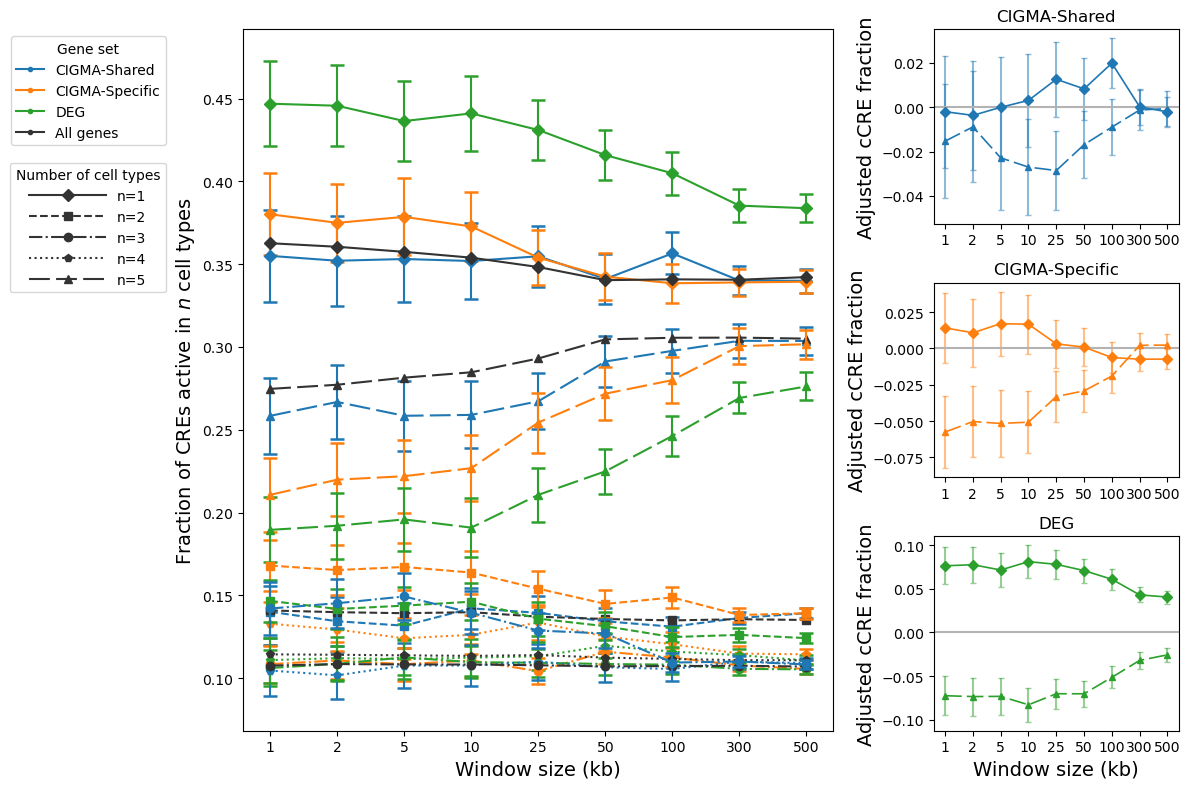

In [115]:
# plot
fs = 12
colors = sns.color_palette()

layout = """
AAB
AAC
AAD
"""

fig, axes = plt.subplot_mosaic(layout, figsize=(12, 8))


ax = axes['A']
markers = ['D', 's', 'o', 'p', '^']
linestyles = ['-', '--', '-.', ':', (0, (10, 3))]

for n_ct in data['n cell types'].unique():
    marker = markers[n_ct - 1]
    linestyle = linestyles[n_ct - 1]
    gset_data = data.loc[(data['Gene set'] == 'All') & (data['n cell types'] == n_ct)]
    ax.errorbar(gset_data['window (kb)'], gset_data['fraction'],
                color='.2', linestyle=linestyle, marker=marker, zorder=5,)
    for gset, color in zip(['CIGMA-Shared', 'CIGMA-Specific', 'DEG'], [colors[0], colors[1], colors[2]]):
        gset_data = data.loc[(data['Gene set'] == gset) & (data['n cell types'] == n_ct)]
        if np.any(gset_data['fraction_p'] < 0.05):
            zorder = 10
            alpha = 1
        else:
            zorder = 1 # 1
            alpha = 1 # 0.3
        ax.errorbar(gset_data['window (kb)'], gset_data['fraction'], yerr=gset_data['fraction_se'],
                    color=color, linestyle=linestyle, marker=marker, 
                    alpha=alpha, capsize=5, capthick=1.8, zorder=zorder)
# make legend
handles = []
labels = []
for n_ct in data['n cell types'].unique():
    marker = markers[n_ct - 1]
    linestyle = linestyles[n_ct - 1]
    handle = Line2D([0], [0], color='.2', marker=marker, linestyle=linestyle, label=f'n={n_ct}')
    handles.append(handle)
    labels.append(f'n={n_ct}')
leg1 = ax.legend(handles, labels, title='Number of cell types', loc='upper right', bbox_to_anchor=(-0.12, 0.82), handlelength=5.5)
ax.add_artist(leg1)
# another legend
handles = []
labels = []
for k, gset in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    color = colors[k]
    handle = Line2D([0], [0], color=color, marker='.', linestyle='-', label=gset)
    handles.append(handle)
    labels.append(gset)
color = '.2'
handle = Line2D([0], [0], color=color, marker='.', linestyle='-', label='All genes')
handles.append(handle)
labels.append('All genes')
ax.legend(handles, labels, title='Gene set', loc='upper right', bbox_to_anchor=(-0.12, 1))


ax.set_ylabel('Fraction of CREs active in $n$ cell types', fontsize=fs+2)
ax.set_xlabel('Window size (kb)', fontsize=fs+2)





tmp_data = match_data.copy()
tmp_data['window'] = tmp_data['window (kb)'].astype(str)
for ax, gene_set, color in zip([axes['B'], axes['C'], axes['D']], ['CIGMA-Shared', 'CIGMA-Specific', 'DEG'], colors[:3]):
    # fraction
    set_data = tmp_data.loc[tmp_data['gene_set'] == gene_set]
    # sns.lineplot(data=set_data, x='window', y='fraction_diff', style='n_ct', color=color, alpha=.5,
                    # markers=markers, dashes=linestyles, linewidth=1.2, ax=ax)
    # for k, n in enumerate(np.unique(set_data['n_ct'])):
    #     sub = set_data.loc[set_data['n_ct'] == n]
    #     if sub['fraction_diff_p'].min() < 0.05:
    #         sns.lineplot(data=sub, x='window', y='fraction_diff',
    #                         marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, color=colors[k])
    #     for _, row in sub.iterrows():
    #         if row['fraction_diff_p'] < 0.05:
    #             ax.plot(row['window'], row['fraction_diff'], '*',
    #                     color=colors[k], markersize=10)
    # add pre-calculated SE as error bars
    order = sorted(set_data['window'].unique(), key=lambda x: int(x))
    for n, marker, linestyle in zip(sorted(set_data['n_ct'].unique()), markers, linestyles):
        if n in [2, 3, 4]:
            continue
        sub = set_data.loc[set_data['n_ct'] == n].copy()
        alpha=.5
        # if sub['fraction_diff_p'].min() < 0.05:
        #     alpha = 0.5
        # else:
        #     alpha = 0.2
        sub['window'] = pd.Categorical(sub['window'], categories=order, ordered=True)
        sub = sub.sort_values('window')
        # x_pos = sub['window'].cat.codes.values
        ax.plot(sub['window'], sub['fraction_diff'].values, marker=marker, linestyle=linestyle, markersize=5,
                linewidth=1.2, color=color, zorder=5)
        ax.errorbar(sub['window'], sub['fraction_diff'].values, yerr=sub['fraction_diff_se'].values, fmt='none',
            ecolor=color, elinewidth=1.5, capsize=2, alpha=alpha, zorder=-1)
    ax.set_title(gene_set, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)
    ax.set_ylabel('Adjusted cCRE fraction', fontsize=fs+2)

axes['D'].set_xlabel('Window size (kb)', fontsize=fs+2)

fig.tight_layout()

/tmp/ipykernel_331106/3562970984.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(data=set_data, x='window', y='fraction_diff', hue='n_ct', alpha=.5,
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-24 10:17:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

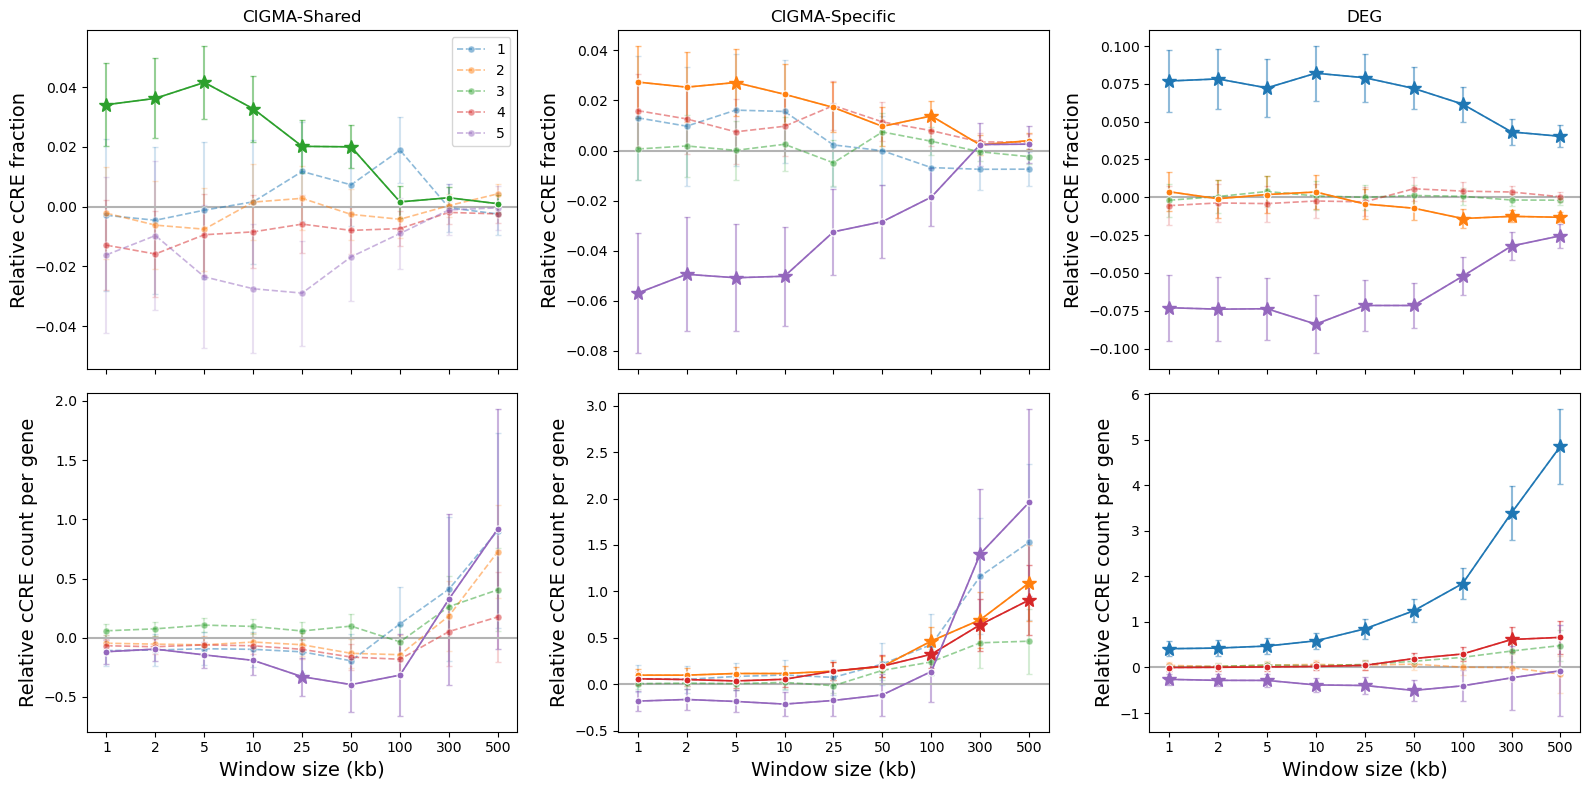

In [ ]:
# plot
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True,)

tmp_data = match_data.copy()
tmp_data['window'] = tmp_data['window (kb)'].astype(str)
for i, gene_set in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    # fraction
    ax = axes[0, i]
    set_data = tmp_data.loc[tmp_data['gene_set'] == gene_set]
    sns.lineplot(data=set_data, x='window', y='fraction_diff', hue='n_ct', alpha=.5,
                    marker='o', markersize=5, linestyle='--', linewidth=1.2, ax=ax, palette=colors)
    for k, n in enumerate(np.unique(set_data['n_ct'])):
        sub = set_data.loc[set_data['n_ct'] == n]
        if sub['fraction_diff_p'].min() < 0.05:
            sns.lineplot(data=sub, x='window', y='fraction_diff',
                            marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, color=colors[k])
        for _, row in sub.iterrows():
            if row['fraction_diff_p'] < 0.05:
                ax.plot(row['window'], row['fraction_diff'], '*',
                        color=colors[k], markersize=10)
    # add pre-calculated SE as error bars
    order = sorted(set_data['window'].unique(), key=lambda x: int(x))
    j = 0
    for n in sorted(set_data['n_ct'].unique()):
        sub = set_data.loc[set_data['n_ct'] == n].copy()
        if sub['fraction_diff_p'].min() < 0.05:
            alpha = 0.5
        else:
            alpha = 0.2
        sub['window'] = pd.Categorical(sub['window'], categories=order, ordered=True)
        sub = sub.sort_values('window')
        x_pos = sub['window'].cat.codes.values
        ax.errorbar(x_pos, sub['fraction_diff'].values, yerr=sub['fraction_diff_se'].values, fmt='none',
            ecolor=colors[j], elinewidth=1.5, capsize=2, alpha=alpha, zorder=-1)
        j += 1
    ax.set_title(gene_set, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)
    ax.set_ylabel('Relative cCRE fraction', fontsize=fs+2)

    # count
    ax = axes[1, i]
    sns.lineplot(data=set_data, x='window', y='count_diff', hue='n_ct', alpha=0.5,
                    marker='o', markersize=5, linestyle='--', linewidth=1.2, ax=ax, palette=colors)
    for k, n in enumerate(np.unique(set_data['n_ct'])):
        sub = set_data.loc[set_data['n_ct'] == n]
        if sub['count_diff_p'].min() < 0.05:
            sns.lineplot(data=sub, x='window', y='count_diff', 
                            marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, color=colors[k])
        for _, row in sub.iterrows():
            if row['count_diff_p'] < 0.05:
                ax.plot(row['window'], row['count_diff'], '*',
                        color=colors[k], markersize=10)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)
    ax.set_xlabel('Window size (kb)', fontsize=fs+2)
    ax.set_ylabel('Relative cCRE count per gene', fontsize=fs+2)
    # add pre-calculated SE as error bars
    order = sorted(set_data['window'].unique(), key=lambda x: int(x))
    j = 0
    for n in sorted(set_data['n_ct'].unique()):
        sub = set_data.loc[set_data['n_ct'] == n].copy()
        if sub['count_diff_p'].min() < 0.05:
            alpha = 0.5
        else:
            alpha = 0.2
        sub['window'] = pd.Categorical(sub['window'], categories=order, ordered=True)
        sub = sub.sort_values('window')
        x_pos = sub['window'].cat.codes.values
        ax.errorbar(x_pos, sub['count_diff'].values, yerr=sub['count_diff_se'].values, fmt='none',
            ecolor=colors[j], elinewidth=1.5, capsize=2, alpha=alpha, zorder=-1)
        j += 1
    

axes[0, 0].legend().set_visible(True)

fig.tight_layout()

/tmp/ipykernel_539401/1173004550.py:15: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=melt_data, x='window', y='Count diff', hue='Cell type', alpha=.8,
[2025-11-11 10:58:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. I

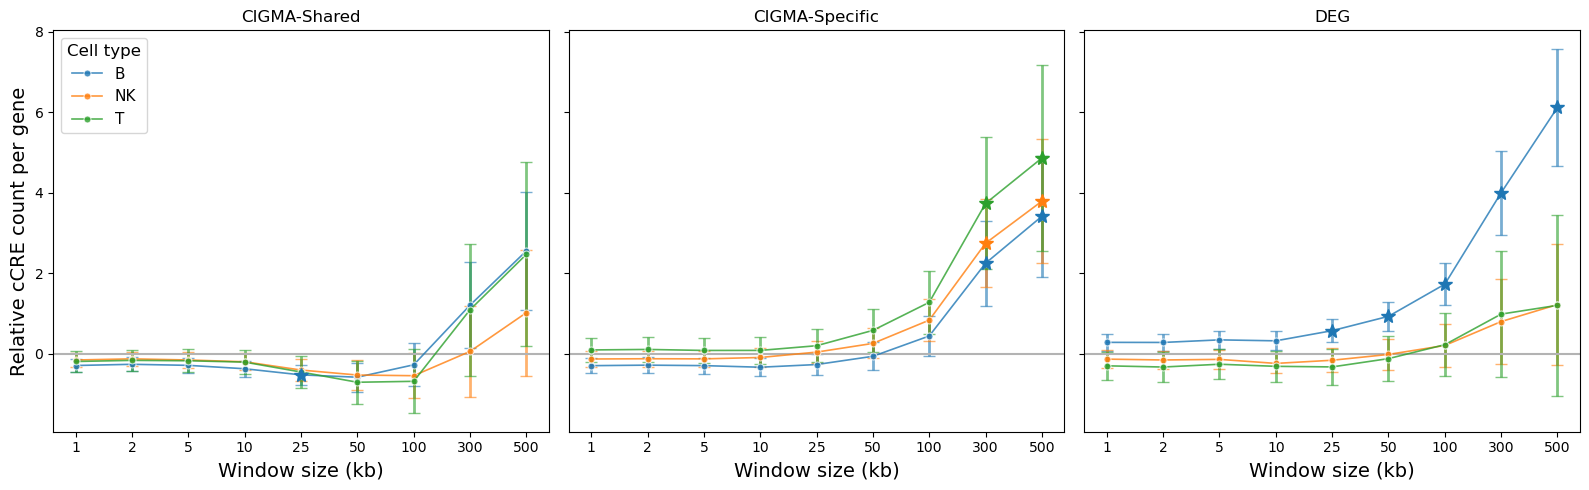

In [ ]:
# plot for B NK T cells
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

tmp_data = match_data2.copy()
tmp_data['window'] = tmp_data['window (kb)'].astype(str)
for i, gene_set in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    # fraction
    ax = axes[i]
    set_data = tmp_data.loc[tmp_data['gene_set'] == gene_set]
    melt_data = set_data.melt(id_vars=['window'], value_vars=['B_count_diff', 'NK_count_diff', 'T_count_diff'], 
                            var_name='Cell type', value_name='Count diff')
    sns.lineplot(data=melt_data, x='window', y='Count diff', hue='Cell type', alpha=.8,
                    marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, palette=colors)
    for k, ct in enumerate(np.unique(melt_data['Cell type'])):
        for _, row in set_data.iterrows():
            if row[f'{ct}_p'] < 0.05:
                ax.plot(row['window'], row[ct], '*',
                        color=colors[k], markersize=10)
    # add pre-calculated SE as error bars
    order = sorted(set_data['window'].unique(), key=lambda x: int(x))
    for k, ct in enumerate(np.unique(melt_data['Cell type'])):
        ax.errorbar(set_data['window'], set_data[ct], yerr=set_data[f'{ct}_se'], fmt='none',
            ecolor=colors[k], elinewidth=2, capsize=4, alpha=.6, zorder=-1)
    ax.set_title(gene_set, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)
    ax.set_xlabel('Window size (kb)', fontsize=fs+2)


axes[0].set_ylabel('Relative cCRE count per gene', fontsize=fs+2)
axes[0].legend().set_visible(True)
# customize legend labels on the first axis
handles, labels = axes[0].get_legend_handles_labels()
label_map = {
    'B_count_diff': 'B',
    'NK_count_diff': 'NK',
    'T_count_diff': 'T',
}
axes[0].legend(
    handles,
    [label_map.get(l, l) for l in labels],
    title='Cell type',
    fontsize=fs-1,
    title_fontsize=fs,
    loc='upper left'
)

fig.tight_layout()

/tmp/ipykernel_539401/3438929101.py:15: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=tmp_data2, x='window', y='mean_n_ct_diff', hue='gene_set', alpha=.8, hue_order=['CIGMA-Shared', 'CIGMA-Specific', 'DEG'],
[2025-11-11 10:58:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 10:58:12 - INFO] Using categorical units to plot a lis

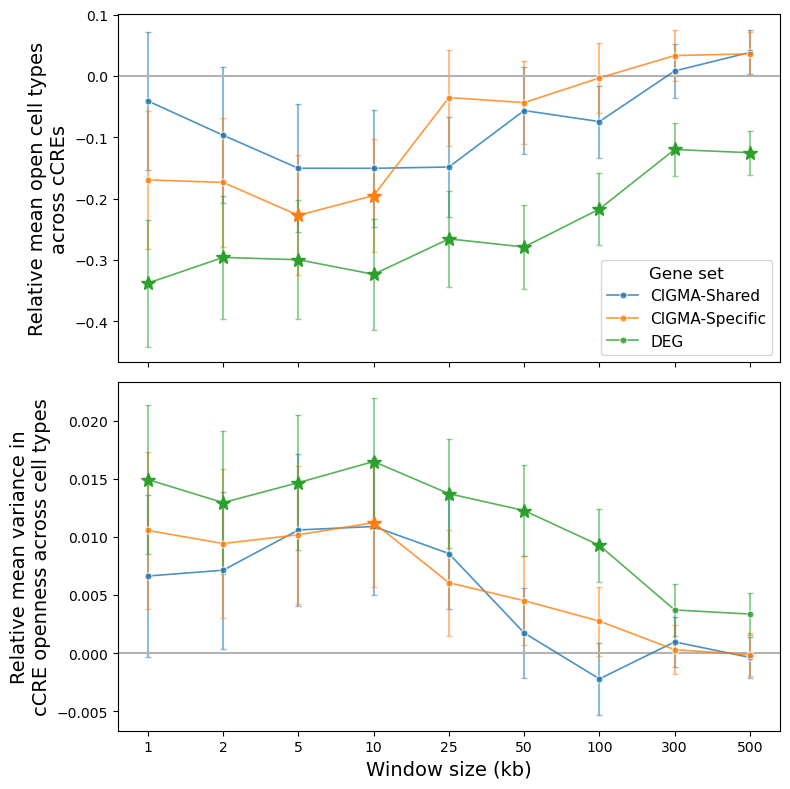

In [ ]:
# mean n_ct and var_ct
tmp_data2 = data2.copy()
tmp_data2['window'] = tmp_data2['window (kb)'].astype(str)
order = sorted(tmp_data2['window'].unique(), key=lambda x: int(x))
tmp_data2['window'] = pd.Categorical(tmp_data2['window'], categories=order, ordered=True)
tmp_data2 = tmp_data2.sort_values('window')

# plot
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True,)

ax = axes[0]
sns.lineplot(data=tmp_data2, x='window', y='mean_n_ct_diff', hue='gene_set', alpha=.8, hue_order=['CIGMA-Shared', 'CIGMA-Specific', 'DEG'],
                marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, palette=colors)
for i, gene_set in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    set_data = tmp_data2.loc[tmp_data2['gene_set'] == gene_set]
    x_pos = set_data['window'].cat.codes.values
    for _, row in set_data.iterrows():
        if row['mean_n_ct_diff_p'] < 0.05:
            ax.plot(row['window'], row['mean_n_ct_diff'], '*',
                    color=colors[i], markersize=10)
    # add pre-calculated SE as error bars
    ax.errorbar(x_pos, set_data['mean_n_ct_diff'].values, yerr=set_data['mean_n_ct_diff_se'].values, fmt='none',
        ecolor=colors[i], elinewidth=1.5, capsize=2, alpha=0.5, zorder=-1,)
ax.axhline(0, linestyle='-', color='0.7', zorder=0)
ax.set_ylabel('Relative mean open cell types\nacross cCREs', fontsize=fs+2)
ax.legend(title='Gene set', fontsize=fs-1, title_fontsize=fs)

# var_ct
ax2 = axes[1]
sns.lineplot(data=tmp_data2, x='window', y='mean_var_ct_diff', hue='gene_set', alpha=.8, hue_order=['CIGMA-Shared', 'CIGMA-Specific', 'DEG'],
                marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax2, palette=colors)
for i, gene_set in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    set_data = tmp_data2.loc[tmp_data2['gene_set'] == gene_set]
    x_pos = set_data['window'].cat.codes.values
    for _, row in set_data.iterrows():
        if row['mean_var_ct_diff_p'] < 0.05:
            ax2.plot(row['window'], row['mean_var_ct_diff'], '*',
                    color=colors[i], markersize=10)
    # add pre-calculated SE as error bars
    ax2.errorbar(x_pos, set_data['mean_var_ct_diff'].values, yerr=set_data['mean_var_ct_diff_se'].values, fmt='none',
        ecolor=colors[i], elinewidth=1.5, capsize=2, alpha=0.5, zorder=-1)
ax2.axhline(0, linestyle='-', color='0.7', zorder=0)
ax2.set_xlabel('Window size (kb)', fontsize=fs+2)
ax2.set_ylabel('Relative mean variance in\ncCRE openness across cell types', fontsize=fs+2)
ax2.legend().set_visible(False)

fig.tight_layout()


(299700, 193)
(7505, 193)
(7505, 193)
(299700, 193)
(7495, 193)
(7495, 193)
(299700, 193)
(24960, 193)
(24960, 193)


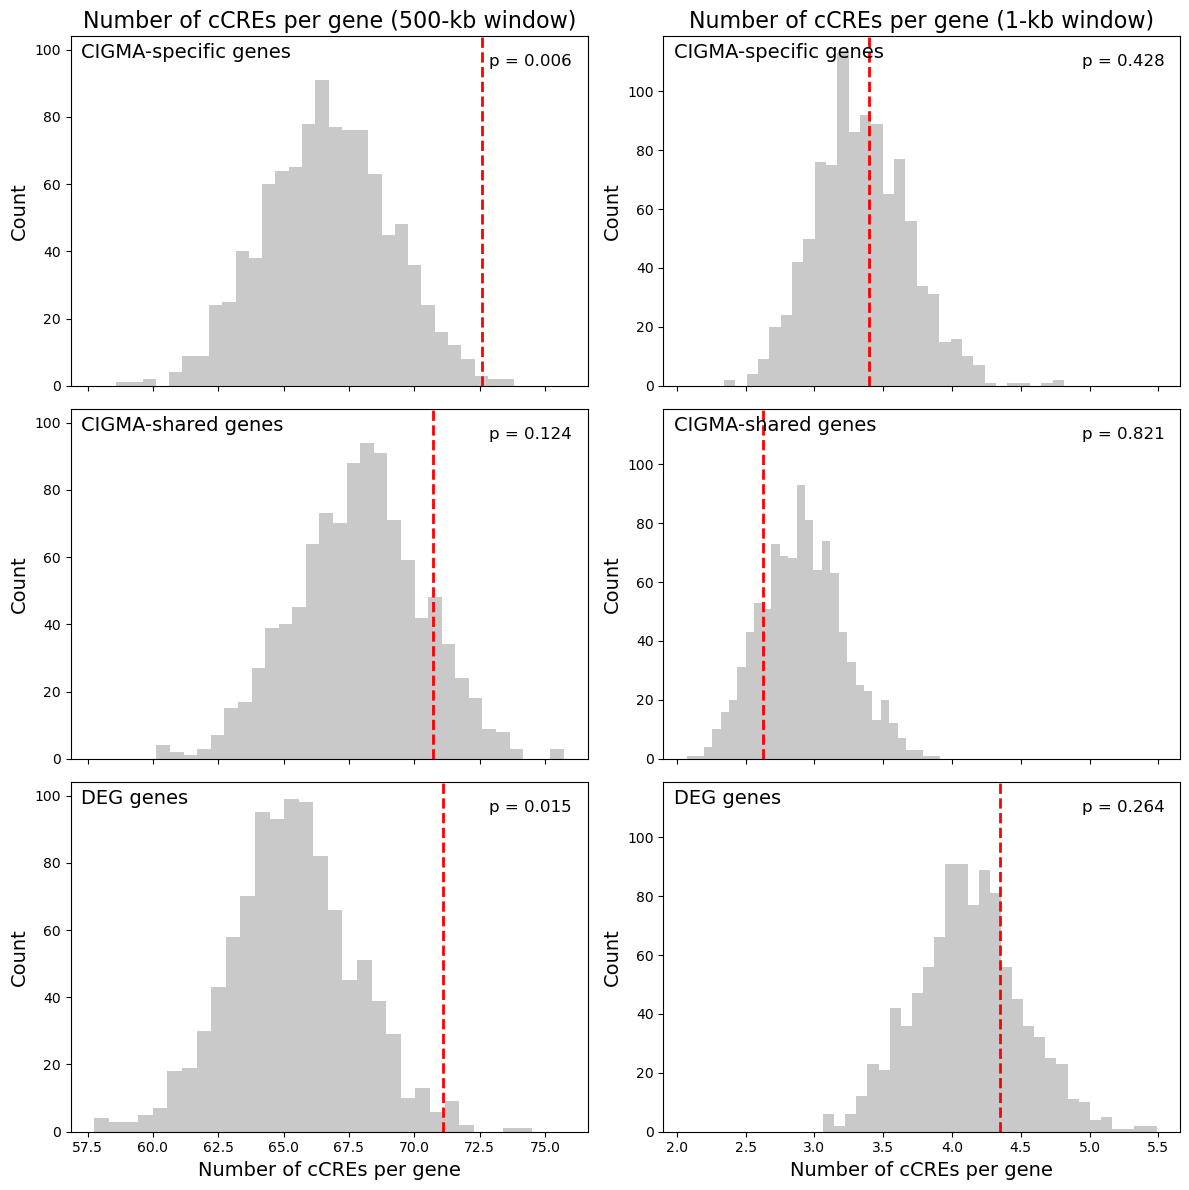

In [113]:
# par
window = 500000
rng = np.random.default_rng(seed=12465)
k = 999
bin_size = 500
fs = 12

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex='col', sharey='col')

for j, target_genes in enumerate([specific_genes, shared_genes, deg_genes]):
    target_n_cre = cre_df.loc[cre_df['gene'].isin(target_genes), f'n_cres:{window}_total'].mean()
    target_n_cre_100k = cre_df.loc[cre_df['gene'].isin(target_genes), 'n_cres:1000_total'].mean()

    # random control genes
    randoms = util.matching_genes(target_genes, cre_df, rng, k, window, bin_size)

    random_n_cre = []
    random_n_cre_100k = []
    for genes in randoms:
        random_n_cre.append(cre_df.loc[cre_df['gene'].isin(genes), f'n_cres:{window}_total'].mean())
        random_n_cre_100k.append(cre_df.loc[cre_df['gene'].isin(genes), 'n_cres:1000_total'].mean())
    random_n_cre = np.array(random_n_cre)
    random_n_cre_100k = np.array(random_n_cre_100k)

    # plot
    axes[j, 0].hist(random_n_cre, bins=30, color='0.7', alpha=0.7)
    axes[j, 0].axvline(target_n_cre, color='r', linestyle='--', lw=2)
    axes[j, 0].set_ylabel('Count', fontsize=fs+2)
    if target_genes is specific_genes:
        label = 'CIGMA-specific genes'
    elif target_genes is shared_genes:
        label = 'CIGMA-shared genes'
    elif target_genes is deg_genes:
        label = 'DEG genes'
    axes[j, 0].text(0.02, .98, f'{label}', fontsize=fs+2, ha='left', va='top', transform=axes[j, 0].transAxes)
    # empirical p value
    ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)
    axes[j, 0].text(0.97, 0.95, f'p = {ncre_p:.3f}', ha='right', va='top', fontsize=fs, transform=axes[j, 0].transAxes)

    axes[j, 1].hist(random_n_cre_100k, bins=30, color='0.7', alpha=0.7)
    axes[j, 1].axvline(target_n_cre_100k, color='r', linestyle='--', lw=2)
    axes[j, 1].set_ylabel('Count', fontsize=fs+2)
    axes[j, 1].text(0.02, .98, f'{label}', fontsize=fs+2, ha='left', va='top', transform=axes[j, 1].transAxes)
    ncre_p = ((random_n_cre_100k >= target_n_cre_100k).sum() + 1) / (k + 1)
    axes[j, 1].text(0.97, 0.95, f'p = {ncre_p:.3f}', ha='right', va='top', fontsize=fs, transform=axes[j, 1].transAxes)

axes[0, 0].set_title('Number of cCREs per gene (500-kb window)', fontsize=fs+4)
axes[0, 1].set_title('Number of cCREs per gene (1-kb window)', fontsize=fs+4)
axes[-1, 0].set_xlabel('Number of cCREs per gene', fontsize=fs+2)
axes[-1, 1].set_xlabel('Number of cCREs per gene', fontsize=fs+2)

fig.tight_layout()

181
(299700, 181)
(15350, 181)
(15350, 181)


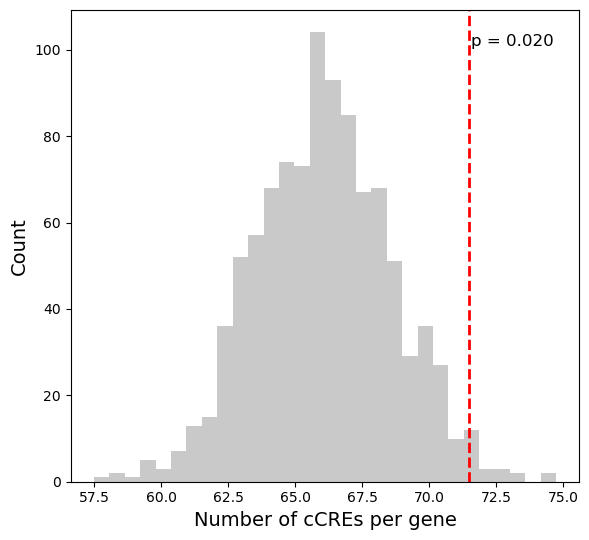

In [ ]:
# exclude MHC
tmp_cre_df = cre_df.copy()

mhc_start = 28477797
mhc_end = 33448354
filter = (tmp_cre_df['chr'] == 6) & \
          (((tmp_cre_df['start'] <= mhc_end) & (tmp_cre_df['start'] >= mhc_start)) | \
          ((tmp_cre_df['end'] <= mhc_end) & (tmp_cre_df['end'] >= mhc_start)) | \
          ((tmp_cre_df['end'] >= mhc_end) & (tmp_cre_df['start'] <= mhc_start)))
tmp_cre_df = tmp_cre_df.loc[~filter]

sig_cre_df = tmp_cre_df.loc[tmp_cre_df['p:free:V'] < p_cut]
target_genes = sig_cre_df['gene'].values
ngene = sig_cre_df.shape[0]
print(ngene)
target_n_cre = sig_cre_df['n_cres:500000_total'].mean()

randoms = util.matching_genes(target_genes, tmp_cre_df, np.random.default_rng(seed=12465), 999, 500000, 500)


random_n_cre = []
for genes in randoms:
    random_n_cre.append(tmp_cre_df.loc[tmp_cre_df['gene'].isin(genes), 'n_cres:500000_total'].mean())
random_n_cre = np.array(random_n_cre)

# plot
fs = 12
fig, ax = plt.subplots(figsize=(6, 5.5))
ax.hist(random_n_cre, bins=30, color='0.7', alpha=0.7)
ax.axvline(target_n_cre, color='r', linestyle='--', lw=2)
ax.set_xlabel('Number of cCREs per gene', fontsize=fs+2)
ax.set_ylabel('Count', fontsize=fs+2)
ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)
ax.text(0.95, 0.95, f'p = {ncre_p:.3f}', ha='right', va='top', fontsize=fs, transform=ax.transAxes)
fig.tight_layout()

In [ ]:
# count overlapping cres for each gene in cre_df
def count_overlapping_cres(row, cres_uniq_tmp, window):
    chr = row['chr']
    start = row['start']
    end = row['end']
    overlap = cres_uniq_tmp.loc[(cres_uniq_tmp['chr'] == chr) & 
                            (((cres_uniq_tmp['start'] >= start - window) & (cres_uniq_tmp['start'] <= end + window)) |
                             ((cres_uniq_tmp['end'] >= start - window) & (cres_uniq_tmp['end'] <= end + window)) |
                             ((cres_uniq_tmp['start'] <= start - window) & (cres_uniq_tmp['end'] >= end + window))
                            )].shape[0]
    return overlap

# cre_df['n_cre'] = cre_df.apply(count_overlapping_cres, axis=1, cres_uniq_tmp=immune_cres_uniq, window=500000)
# cre_df['n_cre_100k'] = cre_df.apply(count_overlapping_cres, axis=1, cres_uniq_tmp=immune_cres_uniq, window=100000)
# cre_df['n_cre_25k'] = cre_df.apply(count_overlapping_cres, axis=1, cres_uniq_tmp=immune_cres_uniq, window=25000)
for ct in immune_cell_types:
    cre_df[f'n_{ct}_cre'] = cre_df.apply(count_overlapping_cres, axis=1, cres_uniq_tmp=perct_cres[ct], window=500000)

In [ ]:
# Per cell type
rng = np.random.default_rng(seed=124654)
k = 999
bin_size = 500
window = 500000

results = {'ct1':[], 'ct2':[], 'target_n_cre':[], 'ncre_p':[]}
for ct1 in P.columns:
    sig_cre_df = cre_df.loc[(cre_df['p:free:V'] < p_cut) & (cre_df[f'p:free:vc_{ct1}'] < p_cut)]
    ngene = sig_cre_df.shape[0]
    # print(f'{ngene} genes', cre_df.loc[cre_df[f'p:free:vc_{ct1}'] < p_cut].shape[0])
    print(f'{ngene} significant genes in {ct1} from OneK1K')

    target_genes = sig_cre_df['gene'].values
    randoms = util.matching_genes(target_genes, cre_df, rng, k, window, bin_size)


    # count cres
    for ct2 in immune_cell_types:
        target_n_cre = sig_cre_df[f'n_{ct2}_cre'].mean()

        random_n_cre = []
        for genes in randoms:
            random_n_cre.append(cre_df.loc[cre_df['gene'].isin(genes), f'n_{ct2}_cre'].mean())
        random_n_cre = np.array(random_n_cre)
        ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)

        # print(f'{ct1}\t{ct2}\t{target_n_cre:.2f}\t{ncre_p:.3f}')
        results['ct1'].append(ct1)
        results['ct2'].append(ct2)
        results['target_n_cre'].append(target_n_cre)
        results['ncre_p'].append(ncre_p)

        # # plot
        # fs = 12
        # fig, ax = plt.subplots(figsize=(6, 5.5))
        # ax.hist(random_n_cre, bins=30, color='0.7', alpha=0.7)
        # ax.axvline(target_n_cre, color='r', linestyle='--', lw=2)
        # ax.set_xlabel('Number of cCREs per gene', fontsize=fs+2)
        # ax.set_ylabel('Count', fontsize=fs+2)
        # ax.text(0.95, 0.95, f'p = {ncre_p:.3f}', ha='right', va='top', fontsize=fs, transform=ax.transAxes)
        # fig.tight_layout()

results_df = pd.DataFrame(results)
results_df.pivot(index='ct1', columns='ct2', values='ncre_p')

In [ ]:
# Per cell type
rng = np.random.default_rng(seed=124654)
results = {'ct1':[], 'ct2':[], 'target_n_cre':[], 'ncre_diff':[], 'ncre_se':[], 'ncre_p':[], 'window':[]}
for ct1 in P.columns:
    sig_cre_df = cre_df.loc[(cre_df['p:free:V'] < p_cut) & (cre_df[f'p:free:vc_{ct1}'] < p_cut)]
    ngene = sig_cre_df.shape[0]
    # print(f'{ngene} genes', cre_df.loc[cre_df[f'p:free:vc_{ct1}'] < p_cut].shape[0])
    print(f'{ngene} significant genes in {ct1} from OneK1K')

    target_genes = sig_cre_df['gene'].values
    randoms = util.matching_genes(target_genes, cre_df, rng, 1000, 500000, 500)

    # count cres
    for ct2 in immune_cell_types:
        for window in cre_windows:
            target_n_cre = sig_cre_df[f'n_cres:{window}_{ct2}'].mean()

            random_n_cre = []
            for genes in randoms:
                random_n_cre.append(cre_df.loc[cre_df['gene'].isin(genes), f'n_cres:{window}_{ct2}'].mean())
            random_n_cre = np.array(random_n_cre)
            se = random_n_cre.std()
            zscore = (target_n_cre - random_n_cre.mean()) / se 
            ncre_p = 2 * stats.norm.sf(np.abs(zscore))
            # ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)

            # print(f'{ct1}\t{ct2}\t{target_n_cre:.2f}\t{ncre_p:.3f}')
            results['ct1'].append(ct1)
            results['ct2'].append(ct2)
            results['target_n_cre'].append(target_n_cre)
            results['ncre_diff'].append(target_n_cre - random_n_cre.mean())
            results['ncre_se'].append(se)
            results['ncre_p'].append(ncre_p)
            results['window'].append(window)
        
results_df = pd.DataFrame(results)
results_df['window (kb)'] = (results_df['window'] / 1000).astype(int)
# results_df.loc[results_df['window'] == 500000].pivot(index='ct1', columns='ct2', values='ncre_p')

29 significant genes in B IN from OneK1K
(300000, 29)
(266817, 29)
(266817, 29)
18 significant genes in B Mem from OneK1K
(300000, 18)
(281721, 18)
(281721, 18)
14 significant genes in CD4 ET from OneK1K
(300000, 14)
(290202, 14)
(290202, 14)
58 significant genes in CD4 NC from OneK1K
(300000, 58)
(242335, 58)
(242335, 58)
30 significant genes in CD8 ET from OneK1K
(300000, 30)
(279782, 30)
(279782, 30)
22 significant genes in CD8 NC from OneK1K
(300000, 22)
(287796, 22)
(287796, 22)
51 significant genes in NK from OneK1K
(300000, 51)
(248873, 51)
(248873, 51)


/tmp/ipykernel_539401/2446661588.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:01:48 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

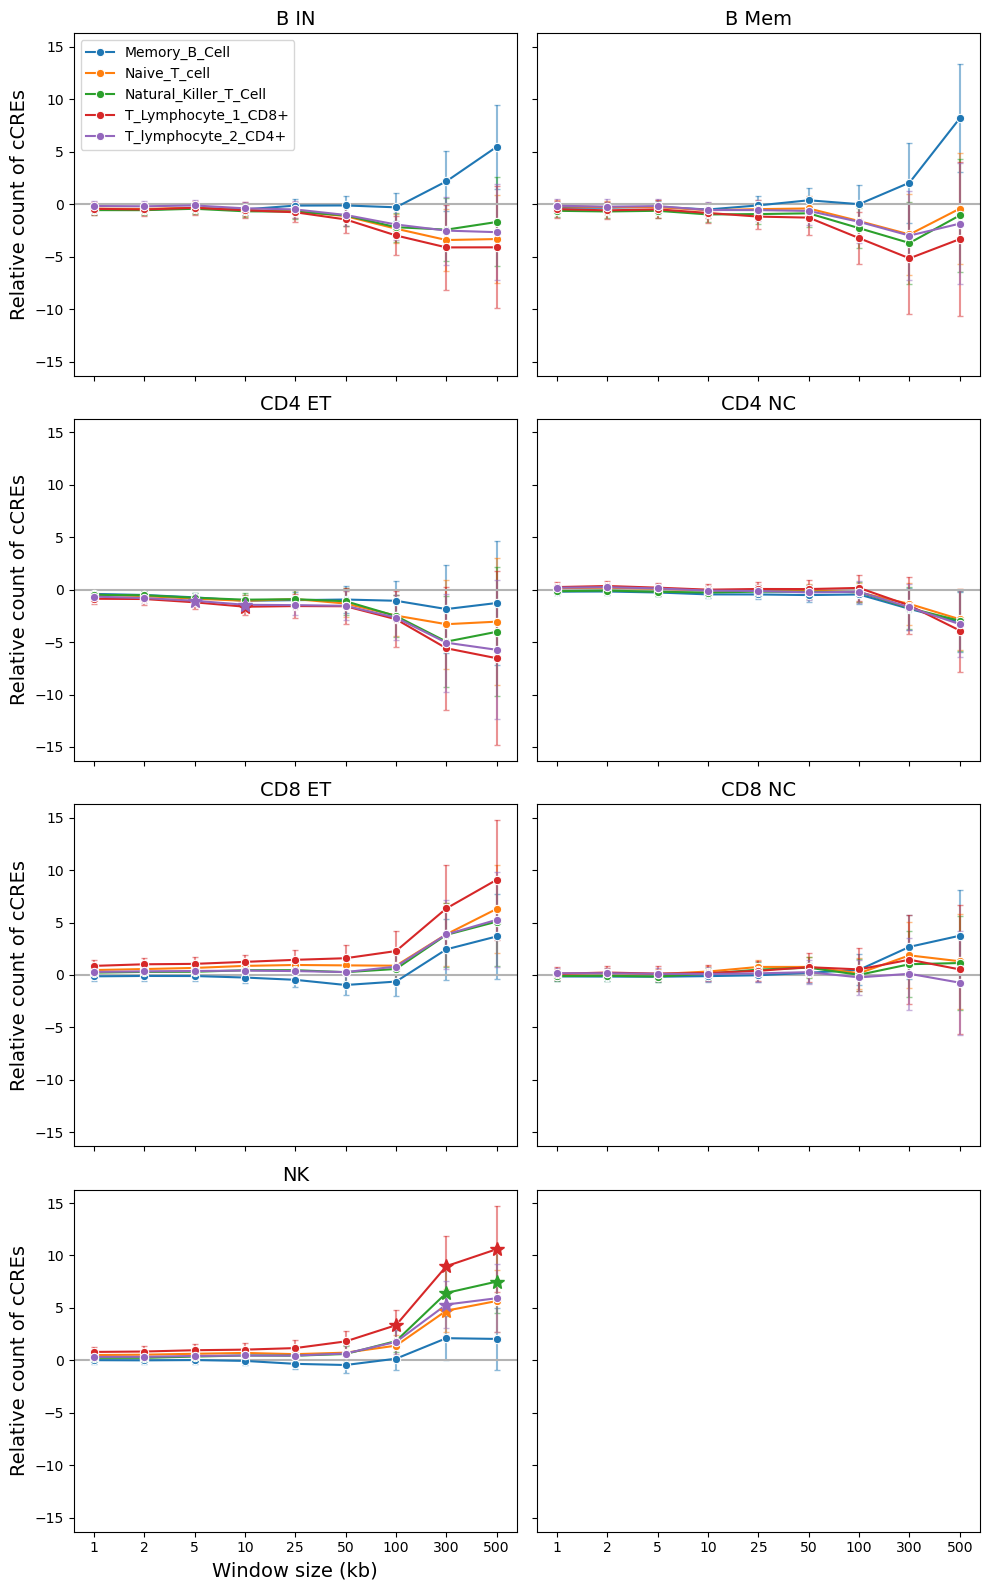

In [ ]:
df = results_df.copy()
df['window (kb)'] = df['window (kb)'].astype(str)
order = sorted(df['window (kb)'].unique(), key=lambda x: int(x))
df['window (kb)'] = pd.Categorical(df['window (kb)'], categories=order, ordered=True)

# lineplots
fs = 14
colors = sns.color_palette()

fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharex=True, sharey=True)
for i, ct1 in enumerate(P.columns):
    ax = axes.flatten()[i]
    set_data = df.loc[df['ct1'] == ct1]
    sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
    for j, ct2 in enumerate(immune_cell_types):
        sub = set_data.loc[set_data['ct2'] == ct2]
        # error bar
        ax.errorbar(sub['window (kb)'], sub['ncre_diff'], yerr=sub['ncre_se'], fmt='none',
            ecolor=colors[j], elinewidth=1.5, capsize=2, alpha=0.5, zorder=-1)
        # highlight significant points
        for _, row in sub.iterrows():
            if row['ncre_p'] < 0.05:
                ax.plot(row['window (kb)'], row['ncre_diff'], '*',
                        color=colors[j], markersize=10)
    
    ax.set_title(ct1, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)

axes[0, 0].legend().set_visible(True)

axes[3, 0].set_xlabel('Window size (kb)', fontsize=fs)

axes[0, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
axes[1, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
axes[2, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
axes[3, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
fig.tight_layout()

In [ ]:
# compile cell types
rng = np.random.default_rng(seed=124654)
compiled_ct_results = {'ct1':[], 'ct2':[], 'target_n_cre':[], 'ncre_diff':[], 'ncre_se':[], 'ncre_p':[], 'window':[]}
for ct1 in ['B', 'T', 'NK']:
    if ct1 == 'B':
        sig_cre_df = cre_df.loc[(cre_df['p:free:V'] < p_cut) & ((cre_df[f'p:free:vc_B IN'] < p_cut) | (cre_df[f'p:free:vc_B Mem'] < p_cut))]
    elif ct1 == 'T':
        sig_cre_df = cre_df.loc[(cre_df['p:free:V'] < p_cut) & ((cre_df[f'p:free:vc_CD4 ET'] < p_cut) | (cre_df[f'p:free:vc_CD4 NC'] < p_cut) | (cre_df[f'p:free:vc_CD8 ET'] < p_cut) | (cre_df[f'p:free:vc_CD8 NC'] < p_cut))]
    elif ct1 == 'NK':
        sig_cre_df = cre_df.loc[(cre_df['p:free:V'] < p_cut) & (cre_df[f'p:free:vc_NK'] < p_cut)]

    ngene = sig_cre_df.shape[0]
    # print(f'{ngene} genes', cre_df.loc[cre_df[f'p:free:vc_{ct1}'] < p_cut].shape[0])
    print(f'{ngene} significant genes in {ct1} from OneK1K')

    target_genes = sig_cre_df['gene'].values
    randoms = util.matching_genes(target_genes, cre_df, rng, 1000, 500000, 500)

    # count cres
    for ct2 in ['Memory_B_Cell', 'T', 'Natural_Killer_T_Cell']:
        for window in cre_windows:
            target_n_cre = sig_cre_df[f'n_cres:{window}_{ct2}'].mean()

            random_n_cre = []
            for genes in randoms:
                random_n_cre.append(cre_df.loc[cre_df['gene'].isin(genes), f'n_cres:{window}_{ct2}'].mean())
            random_n_cre = np.array(random_n_cre)
            se = random_n_cre.std()
            zscore = (target_n_cre - random_n_cre.mean()) / se 
            ncre_p = 2 * stats.norm.sf(np.abs(zscore))
            # ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)

            # print(f'{ct1}\t{ct2}\t{target_n_cre:.2f}\t{ncre_p:.3f}')
            compiled_ct_results['ct1'].append(ct1)
            compiled_ct_results['ct2'].append(ct2)
            compiled_ct_results['target_n_cre'].append(target_n_cre)
            compiled_ct_results['ncre_diff'].append(target_n_cre - random_n_cre.mean())
            compiled_ct_results['ncre_se'].append(se)
            compiled_ct_results['ncre_p'].append(ncre_p)
            compiled_ct_results['window'].append(window)

compiled_ct_results_df = pd.DataFrame(compiled_ct_results)
compiled_ct_results_df['window (kb)'] = (compiled_ct_results_df['window'] / 1000).astype(int)
# compiled_ct_results_df.loc[compiled_ct_results_df['window'] == 500000].pivot(index='ct1', columns='ct2', values='ncre_p')

29 significant genes in B from OneK1K


(300000, 29)
(266817, 29)
(266817, 29)
89 significant genes in T from OneK1K
(300000, 89)
(156551, 89)
(156551, 89)
51 significant genes in NK from OneK1K
(300000, 51)
(249020, 51)
(249020, 51)


/tmp/ipykernel_539401/2680287448.py:14: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
[2025-11-11 11:02:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:02:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:02:47 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:02:47 - INFO] Using categorical units to plot a list of strings that are all parsable

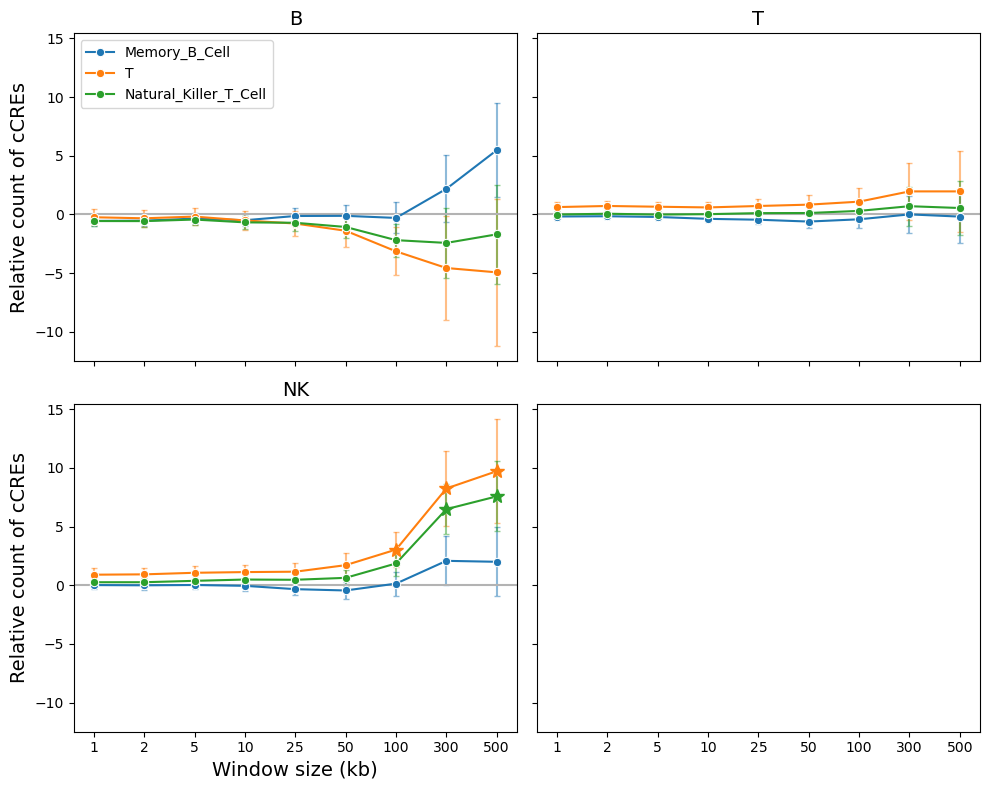

In [ ]:
df = compiled_ct_results_df.copy()
df['window (kb)'] = df['window (kb)'].astype(str)
order = sorted(df['window (kb)'].unique(), key=lambda x: int(x))
df['window (kb)'] = pd.Categorical(df['window (kb)'], categories=order, ordered=True)

# lineplots
fs = 14
colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for i, ct1 in enumerate(['B', 'T', 'NK']):
    ax = axes.flatten()[i]
    set_data = df.loc[df['ct1'] == ct1]
    sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
    for j, ct2 in enumerate(['Memory_B_Cell', 'T', 'Natural_Killer_T_Cell']):
        sub = set_data.loc[set_data['ct2'] == ct2]
        # error bar
        ax.errorbar(sub['window (kb)'], sub['ncre_diff'], yerr=sub['ncre_se'], fmt='none',
            ecolor=colors[j], elinewidth=1.5, capsize=2, alpha=0.5, zorder=-1)
        # highlight significant points
        for _, row in sub.iterrows():
            if row['ncre_p'] < 0.05:
                ax.plot(row['window (kb)'], row['ncre_diff'], '*',
                        color=colors[j], markersize=10)
    
    ax.set_title(ct1, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)

axes[0, 0].legend().set_visible(True)

axes[1, 0].set_xlabel('Window size (kb)', fontsize=fs)

axes[0, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
axes[1, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
fig.tight_layout()

## MHC excluded

In [ ]:
cre_df_mhc_excluded = cre_df.copy()
filter = (cre_df_mhc_excluded['chr'] == MHC_chr) & \
          (((cre_df_mhc_excluded['start'] >= MHC_start) & (cre_df_mhc_excluded['start'] <= MHC_end)) | \
          ((cre_df_mhc_excluded['end'] >= MHC_start) & (cre_df_mhc_excluded['end'] <= MHC_end)) | \
          ((cre_df_mhc_excluded['end'] >= MHC_end) & (cre_df_mhc_excluded['start'] <= MHC_start)))
cre_df_mhc_excluded = cre_df_mhc_excluded.loc[~filter]

# gene sets
specific_genes_mhc_excluded = cre_df_mhc_excluded.loc[cre_df_mhc_excluded['p:free:V'] < p_cut, 'gene'].values
ngene_mhc_excluded = len(specific_genes_mhc_excluded)
print(ngene_mhc_excluded)
shared_genes_mhc_excluded = cre_df_mhc_excluded.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene_mhc_excluded]
deg_genes_mhc_excluded = cre_df_mhc_excluded.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene_mhc_excluded]

181


In [ ]:
# Compare with matched control
df = cre_df_mhc_excluded.copy()
data = {'window':[], 'gene_set':[], 'n_ct':[], 'count_diff':[], 'count_diff_se':[], 'count_diff_p':[],
        'fraction_diff':[], 'fraction_diff_se':[], 'fraction_diff_p':[]}
data2 = {'window':[], 'gene_set':[], 'mean_n_ct_diff':[], 'mean_var_ct_diff':[], 'mean_n_ct_diff_se':[], 'mean_n_ct_diff_p':[],
        'mean_var_ct_diff_se':[], 'mean_var_ct_diff_p':[],
        'B_count_diff':[], 'B_count_diff_se':[], 'B_count_diff_p':[],
        'NK_count_diff':[], 'NK_count_diff_se':[], 'NK_count_diff_p':[],
        'T_count_diff':[], 'T_count_diff_se':[], 'T_count_diff_p':[]}
rng = np.random.default_rng(seed=1256)


for gene_set in ['CIGMA-Specific', 'CIGMA-Shared', 'DEG']:
    if gene_set == 'CIGMA-Specific':
        genes = specific_genes_mhc_excluded
    elif gene_set == 'CIGMA-Shared':
        genes = shared_genes_mhc_excluded
    elif gene_set == 'DEG':
        genes = deg_genes_mhc_excluded
    random_genes = util.matching_genes(genes, df, rng, 1000, 500000, 500)

    for window in cre_windows:
        data2['window'].append(window)
        data2['gene_set'].append(gene_set)

        mean_n_ct = df.loc[df['gene'].isin(genes), f'n_cts:{window}_mean'].mean()
        mean_var_ct = df.loc[df['gene'].isin(genes), f'var_ct:{window}_mean'].mean()
        B_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_Memory_B_Cell'].mean()
        NK_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_Natural_Killer_T_Cell'].mean()
        T_count = df.loc[df['gene'].isin(genes), f'n_cres:{window}_T'].mean()
        # random genes
        mean_n_ct_rand = []
        mean_var_ct_rand = []
        B_count_rand = []
        NK_count_rand = []
        T_count_rand = []
        for tmp_genes in random_genes:
            tmp_mean_n_ct = df.loc[df['gene'].isin(tmp_genes), f'n_cts:{window}_mean'].mean()
            tmp_mean_var_ct = df.loc[df['gene'].isin(tmp_genes), f'var_ct:{window}_mean'].mean()
            tmp_B_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_Memory_B_Cell'].mean()
            tmp_NK_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_Natural_Killer_T_Cell'].mean()
            tmp_T_count = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_T'].mean()
            mean_n_ct_rand.append(tmp_mean_n_ct)
            mean_var_ct_rand.append(tmp_mean_var_ct)
            B_count_rand.append(tmp_B_count)
            NK_count_rand.append(tmp_NK_count)
            T_count_rand.append(tmp_T_count)

        mean_n_ct_rand = np.array(mean_n_ct_rand)
        mean_var_ct_rand = np.array(mean_var_ct_rand)
        B_count_rand = np.array(B_count_rand)
        NK_count_rand = np.array(NK_count_rand)
        T_count_rand = np.array(T_count_rand)
        data2['mean_n_ct_diff'].append(mean_n_ct - mean_n_ct_rand.mean())
        data2['mean_n_ct_diff_se'].append(mean_n_ct_rand.std())
        # p_value = ((mean_n_ct_rand < mean_n_ct).sum() + 1) / (len(mean_n_ct_rand) + 1)
        p_value = 2 * stats.norm.sf(np.abs(mean_n_ct - mean_n_ct_rand.mean()) / mean_n_ct_rand.std())
        data2['mean_n_ct_diff_p'].append(p_value)
        data2['mean_var_ct_diff'].append(mean_var_ct - mean_var_ct_rand.mean())
        data2['mean_var_ct_diff_se'].append(mean_var_ct_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(mean_var_ct - mean_var_ct_rand.mean()) / mean_var_ct_rand.std())
        data2['mean_var_ct_diff_p'].append(p_value)
        data2['B_count_diff'].append(B_count - B_count_rand.mean())
        data2['B_count_diff_se'].append(B_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(B_count - B_count_rand.mean()) / B_count_rand.std())
        data2['B_count_diff_p'].append(p_value)
        data2['NK_count_diff'].append(NK_count - NK_count_rand.mean())
        data2['NK_count_diff_se'].append(NK_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(NK_count - NK_count_rand.mean()) / NK_count_rand.std())
        data2['NK_count_diff_p'].append(p_value)
        data2['T_count_diff'].append(T_count - T_count_rand.mean())
        data2['T_count_diff_se'].append(T_count_rand.std())
        p_value = 2 * stats.norm.sf(np.abs(T_count - T_count_rand.mean()) / T_count_rand.std())
        data2['T_count_diff_p'].append(p_value)
        

        for n_ct in n_ct_uniqs.tolist():
            data['window'].append(window)
            data['gene_set'].append(gene_set)
            data['n_ct'].append(n_ct)

            total_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_total'].sum()
            n_ccres = df.loc[df['gene'].isin(genes), f'n_cres:{window}_{n_ct}'].sum()
            fraction = n_ccres / total_ccres if total_ccres > 0 else 0

            # random genes
            n_ccres_rand = []
            fraction_rand = []
            for tmp_genes in random_genes:
                tmp_total_ccres = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_total'].sum()
                tmp_n_ccres = df.loc[df['gene'].isin(tmp_genes), f'n_cres:{window}_{n_ct}'].sum()
                tmp_fraction = tmp_n_ccres / tmp_total_ccres if tmp_total_ccres > 0 else 0
                n_ccres_rand.append(tmp_n_ccres / len(tmp_genes))
                fraction_rand.append(tmp_fraction)
            n_ccres_rand = np.array(n_ccres_rand)
            fraction_rand = np.array(fraction_rand)
            data['count_diff'].append((n_ccres / len(genes)) - n_ccres_rand.mean())
            data['count_diff_se'].append(n_ccres_rand.std())
            # p_value = ((n_ccres_rand > (n_ccres / len(genes))).sum() + 1) / (len(n_ccres_rand) + 1)
            p_value = 2 * stats.norm.sf(np.abs((n_ccres / len(genes)) - n_ccres_rand.mean()) / n_ccres_rand.std())
            data['count_diff_p'].append(p_value)
            data['fraction_diff'].append(fraction - fraction_rand.mean())
            data['fraction_diff_se'].append(fraction_rand.std())
            # p_value = ((fraction_rand > fraction).sum() + 1) / (len(fraction_rand) + 1)
            p_value = 2 * stats.norm.sf(np.abs(fraction - fraction_rand.mean()) / fraction_rand.std())
            data['fraction_diff_p'].append(p_value)

data = pd.DataFrame(data)
data['window (kb)'] = (data['window'] / 1000).astype(int)
data2 = pd.DataFrame(data2)
data2['window (kb)'] = (data2['window'] / 1000).astype(int)

(300000, 181)
(15347, 181)
(15347, 181)
(300000, 181)
(13337, 181)
(13337, 181)
(300000, 181)
(35510, 181)
(35510, 181)


/tmp/ipykernel_539401/1173004550.py:15: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=melt_data, x='window', y='Count diff', hue='Cell type', alpha=.8,
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. I

[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:08:23 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

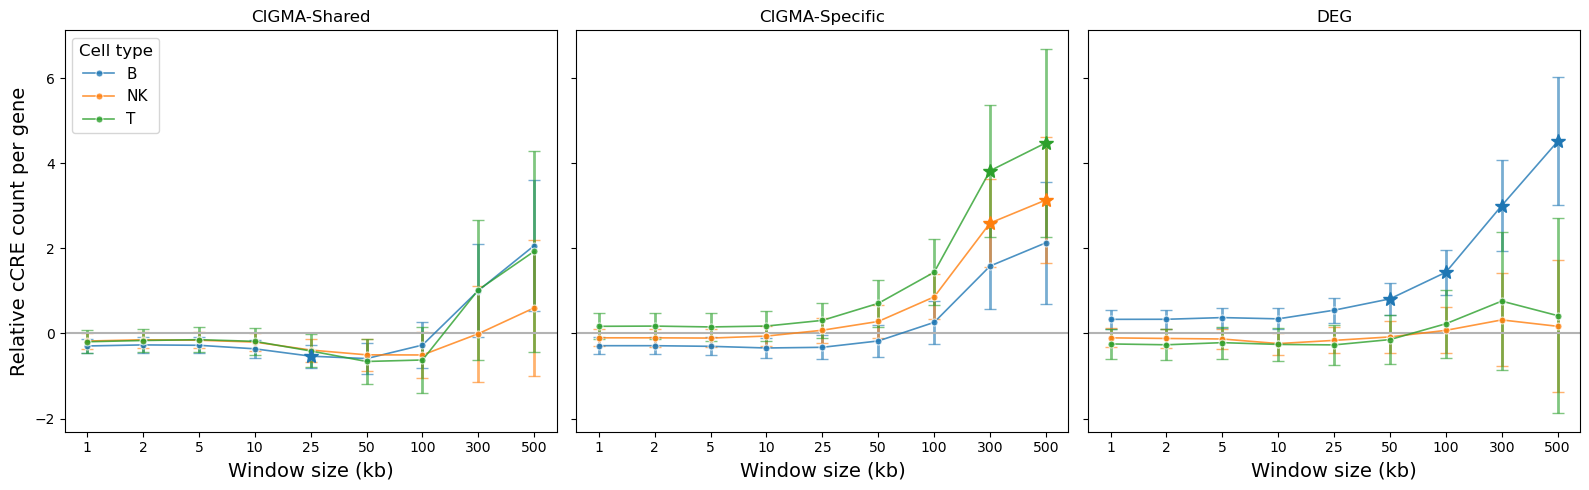

In [ ]:
# plot for B NK T cells
fs = 12
colors = sns.color_palette()

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

tmp_data = data2.copy()
tmp_data['window'] = tmp_data['window (kb)'].astype(str)
for i, gene_set in enumerate(['CIGMA-Shared', 'CIGMA-Specific', 'DEG']):
    # fraction
    ax = axes[i]
    set_data = tmp_data.loc[tmp_data['gene_set'] == gene_set]
    melt_data = set_data.melt(id_vars=['window'], value_vars=['B_count_diff', 'NK_count_diff', 'T_count_diff'], 
                            var_name='Cell type', value_name='Count diff')
    sns.lineplot(data=melt_data, x='window', y='Count diff', hue='Cell type', alpha=.8,
                    marker='o', markersize=5, linestyle='-', linewidth=1.2, ax=ax, palette=colors)
    for k, ct in enumerate(np.unique(melt_data['Cell type'])):
        for _, row in set_data.iterrows():
            if row[f'{ct}_p'] < 0.05:
                ax.plot(row['window'], row[ct], '*',
                        color=colors[k], markersize=10)
    # add pre-calculated SE as error bars
    order = sorted(set_data['window'].unique(), key=lambda x: int(x))
    for k, ct in enumerate(np.unique(melt_data['Cell type'])):
        ax.errorbar(set_data['window'], set_data[ct], yerr=set_data[f'{ct}_se'], fmt='none',
            ecolor=colors[k], elinewidth=2, capsize=4, alpha=.6, zorder=-1)
    ax.set_title(gene_set, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)
    ax.set_xlabel('Window size (kb)', fontsize=fs+2)


axes[0].set_ylabel('Relative cCRE count per gene', fontsize=fs+2)
axes[0].legend().set_visible(True)
# customize legend labels on the first axis
handles, labels = axes[0].get_legend_handles_labels()
label_map = {
    'B_count_diff': 'B',
    'NK_count_diff': 'NK',
    'T_count_diff': 'T',
}
axes[0].legend(
    handles,
    [label_map.get(l, l) for l in labels],
    title='Cell type',
    fontsize=fs-1,
    title_fontsize=fs,
    loc='upper left'
)

fig.tight_layout()

In [ ]:
# compile cell types
df = cre_df_mhc_excluded.copy()
rng = np.random.default_rng(seed=124654)

compiled_ct_results = {'ct1':[], 'ct2':[], 'target_n_cre':[], 'ncre_diff':[], 'ncre_se':[], 'ncre_p':[], 'window':[]}
for ct1 in ['B', 'T', 'NK']:
    if ct1 == 'B':
        sig_cre_df = df.loc[(df['p:free:V'] < p_cut) & ((df[f'p:free:vc_B IN'] < p_cut) | (df[f'p:free:vc_B Mem'] < p_cut))]
    elif ct1 == 'T':
        sig_cre_df = df.loc[(df['p:free:V'] < p_cut) & ((df[f'p:free:vc_CD4 ET'] < p_cut) | (df[f'p:free:vc_CD4 NC'] < p_cut) | (df[f'p:free:vc_CD8 ET'] < p_cut) | (df[f'p:free:vc_CD8 NC'] < p_cut))]
    elif ct1 == 'NK':
        sig_cre_df = df.loc[(df['p:free:V'] < p_cut) & (df[f'p:free:vc_NK'] < p_cut)]

    ngene = sig_cre_df.shape[0]
    # print(f'{ngene} genes', cre_df.loc[cre_df[f'p:free:vc_{ct1}'] < p_cut].shape[0])
    print(f'{ngene} significant genes in {ct1} from OneK1K')

    target_genes = sig_cre_df['gene'].values
    randoms = util.matching_genes(target_genes, df, rng, 1000, 500000, 500)

    # count cres
    for ct2 in ['Memory_B_Cell', 'T', 'Natural_Killer_T_Cell']:
        for window in cre_windows:
            target_n_cre = sig_cre_df[f'n_cres:{window}_{ct2}'].mean()

            random_n_cre = []
            for genes in randoms:
                random_n_cre.append(df.loc[df['gene'].isin(genes), f'n_cres:{window}_{ct2}'].mean())
            random_n_cre = np.array(random_n_cre)
            se = random_n_cre.std()
            zscore = (target_n_cre - random_n_cre.mean()) / se 
            ncre_p = 2 * stats.norm.sf(np.abs(zscore))
            # ncre_p = ((random_n_cre >= target_n_cre).sum() + 1) / (k + 1)

            # print(f'{ct1}\t{ct2}\t{target_n_cre:.2f}\t{ncre_p:.3f}')
            compiled_ct_results['ct1'].append(ct1)
            compiled_ct_results['ct2'].append(ct2)
            compiled_ct_results['target_n_cre'].append(target_n_cre)
            compiled_ct_results['ncre_diff'].append(target_n_cre - random_n_cre.mean())
            compiled_ct_results['ncre_se'].append(se)
            compiled_ct_results['ncre_p'].append(ncre_p)
            compiled_ct_results['window'].append(window)

compiled_ct_results_df = pd.DataFrame(compiled_ct_results)
compiled_ct_results_df['window (kb)'] = (compiled_ct_results_df['window'] / 1000).astype(int)
# compiled_ct_results_df.loc[compiled_ct_results_df['window'] == 500000].pivot(index='ct1', columns='ct2', values='ncre_p')

20 significant genes in B from OneK1K
(300000, 20)
(287872, 20)
(287872, 20)
86 significant genes in T from OneK1K
(300000, 86)
(169240, 86)
(169240, 86)
49 significant genes in NK from OneK1K
(300000, 49)
(247277, 49)
(247277, 49)


/tmp/ipykernel_539401/2680287448.py:14: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:31 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

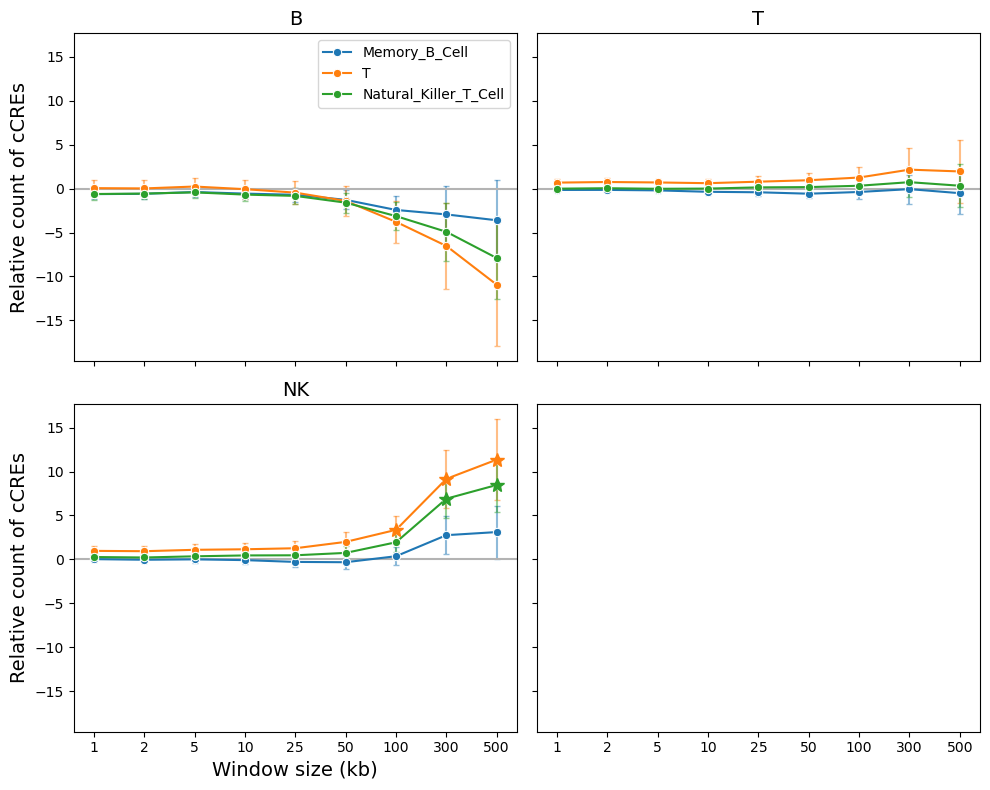

In [ ]:
df = compiled_ct_results_df.copy()
df['window (kb)'] = df['window (kb)'].astype(str)
order = sorted(df['window (kb)'].unique(), key=lambda x: int(x))
df['window (kb)'] = pd.Categorical(df['window (kb)'], categories=order, ordered=True)

# lineplots
fs = 14
colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for i, ct1 in enumerate(['B', 'T', 'NK']):
    ax = axes.flatten()[i]
    set_data = df.loc[df['ct1'] == ct1]
    sns.lineplot(data=set_data, x='window (kb)', y='ncre_diff', hue='ct2', marker='o', palette=colors, ax=ax)
    for j, ct2 in enumerate(['Memory_B_Cell', 'T', 'Natural_Killer_T_Cell']):
        sub = set_data.loc[set_data['ct2'] == ct2]
        # error bar
        ax.errorbar(sub['window (kb)'], sub['ncre_diff'], yerr=sub['ncre_se'], fmt='none',
            ecolor=colors[j], elinewidth=1.5, capsize=2, alpha=0.5, zorder=-1)
        # highlight significant points
        for _, row in sub.iterrows():
            if row['ncre_p'] < 0.05:
                ax.plot(row['window (kb)'], row['ncre_diff'], '*',
                        color=colors[j], markersize=10)
    
    ax.set_title(ct1, fontsize=fs)
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    ax.legend().set_visible(False)

axes[0, 0].legend().set_visible(True)

axes[1, 0].set_xlabel('Window size (kb)', fontsize=fs)

axes[0, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
axes[1, 0].set_ylabel('Relative count of cCREs', fontsize=fs)
fig.tight_layout()

In [ ]:
# # count mean active cell types across cres within each gene
# def count_mean_n_ct(row, cres_uniq_tmp, window):
#     chr = row['chr']
#     start = row['start']
#     end = row['end']
#     overlap = cres_uniq_tmp.loc[(cres_uniq_tmp['chr'] == chr) & 
#                             (((cres_uniq_tmp['start'] >= start - window) & (cres_uniq_tmp['start'] <= end + window)) |
#                              ((cres_uniq_tmp['end'] >= start - window) & (cres_uniq_tmp['end'] <= end + window)) |
#                              ((cres_uniq_tmp['start'] <= start - window) & (cres_uniq_tmp['end'] >= end + window))
#                             )]
#     if overlap.shape[0] == 0:
#         return 0
#     else:
#         overlap = overlap['n_ct'].mean()
#     return overlap

# # calculate mean var active cell types across cres within each gene
# def count_mean_var_ct(row, cres_uniq_tmp, window):
#     chr = row['chr']
#     start = row['start']
#     end = row['end']
#     overlap = cres_uniq_tmp.loc[(cres_uniq_tmp['chr'] == chr) & 
#                             (((cres_uniq_tmp['start'] >= start - window) & (cres_uniq_tmp['start'] <= end + window)) |
#                              ((cres_uniq_tmp['end'] >= start - window) & (cres_uniq_tmp['end'] <= end + window)) |
#                              ((cres_uniq_tmp['start'] <= start - window) & (cres_uniq_tmp['end'] >= end + window))
#                             )]
#     overlap = overlap['var_ct'].mean()
#     return overlap

# cre_df['mean_n_ct'] = cre_df.apply(count_mean_n_ct, axis=1, cres_uniq_tmp=immune_cres_uniq, window=500000)
# cre_df['mean_var_ct'] = cre_df.apply(count_mean_var_ct, axis=1, cres_uniq_tmp=immune_cres_uniq, window=500000)

In [ ]:
# print((cre_df['n_cts:500000_mean'] == cre_df['mean_n_ct']).all())  # should be True
# tmp_cre_df = cre_df.loc[~(cre_df['n_cts:500000_mean'].isna() & cre_df['mean_n_ct'].isna())]
# print((tmp_cre_df['n_cts:500000_mean'] == tmp_cre_df['mean_n_ct']).all())  # should be True
# print((tmp_cre_df[['n_cts:500000_mean','mean_n_ct']]).head())  # should be True

In [ ]:
# specific_genes = cre_df.loc[cre_df['p:free:V'] < p_cut, 'gene'].values
# ngene = len(specific_genes)
# print(ngene)
# shared_genes = cre_df.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene]
# deg_genes = cre_df.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene]

# # par
# window = 500000
# rng = np.random.default_rng(seed=123465)
# k = 999
# bin_size = 500
# fs = 12
# fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)

# for ax, target_genes in zip(axes, [specific_genes, shared_genes, deg_genes]):
#     target_mean_n_ct = cre_df.loc[cre_df['gene'].isin(target_genes), 'mean_n_ct'].mean()
#     print(target_mean_n_ct)

#     # nearby genes
#     nearby_genes = []
#     for gene in target_genes:
#         chr = cre_df.loc[cre_df['gene'] == gene, 'chr'].values[0]
#         start = cre_df.loc[cre_df['gene'] == gene, 'start'].values[0]
#         end = cre_df.loc[cre_df['gene'] == gene, 'end'].values[0]
#         window_start = start - window
#         window_end = end + window
#         # overlap
#         filter = (cre_df['chr'] == chr) & \
#                     (((cre_df['start'] >= window_start) & (cre_df['start'] <= window_end)) | \
#                     ((cre_df['end'] >= window_start) & (cre_df['end'] <= window_end)) | \
#                     ((cre_df['start'] <= window_start) & (cre_df['end'] >= window_end)))
#         nearby = cre_df.loc[filter, 'gene'].values
#         nearby_genes.append(nearby)
#     nearby_genes = np.unique(np.concatenate(nearby_genes))

#     # random sampling: matching mean expression and gene length
#     randoms = []

#     # scheme 1
#     for gene in target_genes:
#         rank = cre_df.loc[cre_df['gene'] == gene, 'mean_expr_rank'].values[0]
#         length = cre_df.loc[cre_df['gene'] == gene, 'gene_length_rank'].values[0]
#         filter = (cre_df['mean_expr_rank'] >= rank - bin_size) & (cre_df['mean_expr_rank'] <= rank + bin_size) & \
#                     (cre_df['gene_length_rank'] >= length - bin_size) & (cre_df['gene_length_rank'] <= length + bin_size) & \
#                     (~cre_df['gene'].isin(nearby_genes))
#         candidates = cre_df.loc[filter, 'gene'].values
#         assert len(candidates) > 0
#         selected = rng.choice(candidates, size=300 * k, replace=True)
#         randoms.append(selected)
#     randoms = np.array(randoms).T  # k x ngene
#     print(randoms.shape)

#     # remove gene sets with duplicates
#     filters = [len(set(randoms[i])) == len(randoms[i]) for i in range(randoms.shape[0])]
#     randoms = randoms[filters]
#     print(randoms.shape)
#     # check uniqueness
#     unique_sets = set()
#     filters = []
#     for i in range(randoms.shape[0]):
#         gene_tuple = tuple(sorted(randoms[i]))
#         if gene_tuple in unique_sets:
#             filters.append(False)
#         else:
#             unique_sets.add(gene_tuple)
#             filters.append(True)
#     randoms = randoms[filters]
#     print(randoms.shape)

#     assert randoms.shape[0] >= k, f'Not enough random sets: {randoms.shape[0]} < {k}'
#     randoms = randoms[:k]

#     random_mean_n_ct = []
#     for genes in randoms:
#         random_mean_n_ct.append(cre_df.loc[cre_df['gene'].isin(genes), 'mean_n_ct'].mean())
#     random_mean_n_ct = np.array(random_mean_n_ct)

#     # plot
#     ax.hist(random_mean_n_ct, bins=30, color='0.7', alpha=0.7)
#     ax.axvline(target_mean_n_ct, color='r', linestyle='--', lw=2)
#     ax.set_ylabel('Count', fontsize=fs+2)
#     if target_genes is specific_genes:
#         label = 'CIGMA-specific genes'
#     elif target_genes is shared_genes:
#         label = 'CIGMA-shared genes'
#     elif target_genes is deg_genes:
#         label = 'DEG genes'
#     ax.text(0.98, .98, f'{label}', fontsize=fs+2, ha='right', va='top', transform=ax.transAxes)
#     # empirical p value
#     ncre_p = ((random_mean_n_ct <= target_mean_n_ct).sum() + 1) / (k + 1)
#     ax.text(0.04, 0.95, f'p = {ncre_p:.3f}', ha='left', va='top', fontsize=fs, transform=ax.transAxes)

# axes[-1].set_xlabel('Average number of active cell types per cCRE', fontsize=fs+2)

# fig.tight_layout()

In [ ]:
# specific_genes = cre_df.loc[cre_df['p:free:V'] < p_cut, 'gene'].values
# ngene = len(specific_genes)
# print(ngene)
# shared_genes = cre_df.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene]
# deg_genes = cre_df.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene]

# # par
# window = 500000
# rng = np.random.default_rng(seed=1234565)
# k = 999
# bin_size = 500
# fs = 12
# fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)

# for ax, target_genes in zip(axes, [specific_genes, shared_genes, deg_genes]):
#     target_mean_var_ct = cre_df.loc[cre_df['gene'].isin(target_genes), 'mean_var_ct'].mean()

#     # nearby genes
#     nearby_genes = []
#     for gene in target_genes:
#         chr = cre_df.loc[cre_df['gene'] == gene, 'chr'].values[0]
#         start = cre_df.loc[cre_df['gene'] == gene, 'start'].values[0]
#         end = cre_df.loc[cre_df['gene'] == gene, 'end'].values[0]
#         window_start = start - window
#         window_end = end + window
#         # overlap
#         filter = (cre_df['chr'] == chr) & \
#                     (((cre_df['start'] >= window_start) & (cre_df['start'] <= window_end)) | \
#                     ((cre_df['end'] >= window_start) & (cre_df['end'] <= window_end)) | \
#                     ((cre_df['start'] <= window_start) & (cre_df['end'] >= window_end)))
#         nearby = cre_df.loc[filter, 'gene'].values
#         nearby_genes.append(nearby)
#     nearby_genes = np.unique(np.concatenate(nearby_genes))

#     # random sampling: matching mean expression and gene length
#     randoms = []

#     # scheme 1
#     for gene in target_genes:
#         rank = cre_df.loc[cre_df['gene'] == gene, 'mean_expr_rank'].values[0]
#         length = cre_df.loc[cre_df['gene'] == gene, 'gene_length_rank'].values[0]
#         filter = (cre_df['mean_expr_rank'] >= rank - bin_size) & (cre_df['mean_expr_rank'] <= rank + bin_size) & \
#                     (cre_df['gene_length_rank'] >= length - bin_size) & (cre_df['gene_length_rank'] <= length + bin_size) & \
#                     (~cre_df['gene'].isin(nearby_genes))
#         candidates = cre_df.loc[filter, 'gene'].values
#         assert len(candidates) > 0
#         selected = rng.choice(candidates, size=300 * k, replace=True)
#         randoms.append(selected)
#     randoms = np.array(randoms).T  # k x ngene
#     print(randoms.shape)

#     # remove gene sets with duplicates
#     filters = [len(set(randoms[i])) == len(randoms[i]) for i in range(randoms.shape[0])]
#     randoms = randoms[filters]
#     print(randoms.shape)
#     # check uniqueness
#     unique_sets = set()
#     filters = []
#     for i in range(randoms.shape[0]):
#         gene_tuple = tuple(sorted(randoms[i]))
#         if gene_tuple in unique_sets:
#             filters.append(False)
#         else:
#             unique_sets.add(gene_tuple)
#             filters.append(True)
#     randoms = randoms[filters]
#     print(randoms.shape)

#     assert randoms.shape[0] >= k, f'Not enough random sets: {randoms.shape[0]} < {k}'
#     randoms = randoms[:k]

#     random_mean_var_ct = []
#     for genes in randoms:
#         random_mean_var_ct.append(cre_df.loc[cre_df['gene'].isin(genes), 'mean_var_ct'].mean())
#     random_mean_var_ct = np.array(random_mean_var_ct)

#     # plot
#     ax.hist(random_mean_var_ct, bins=30, color='0.7', alpha=0.7)
#     ax.axvline(target_mean_var_ct, color='r', linestyle='--', lw=2)
#     ax.set_ylabel('Count', fontsize=fs+2)
#     if target_genes is specific_genes:
#         label = 'CIGMA-specific genes'
#     elif target_genes is shared_genes:
#         label = 'CIGMA-shared genes'
#     elif target_genes is deg_genes:
#         label = 'DEG genes'
#     ax.text(0.98, .98, f'{label}', fontsize=fs+2, ha='right', va='top', transform=ax.transAxes)
#     # empirical p value
#     ncre_p = ((random_mean_var_ct <= target_mean_var_ct).sum() + 1) / (k + 1)
#     ax.text(0.04, 0.95, f'p = {ncre_p:.3f}', ha='left', va='top', fontsize=fs, transform=ax.transAxes)

# axes[-1].set_xlabel('Average variance of active cell types per cCRE', fontsize=fs+2)

# fig.tight_layout()

In [ ]:
# # scatter plot of specificity vs n_cre
# data = cre_df.loc[cre_df['g'] > 0].copy()
# data = data.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
# data['specificity'] = data['specificity'].clip(-10, 10)

# fs = 12
# fig, axes = plt.subplots(nrows=2, figsize=(6, 10))
# alpha = 0.7
# lw = 1.5
# format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
# colors = sns.color_palette('bright')


# # divide gene annotation into bins
# annotation = 'n_cre'
# data = plot.bin_gene_annotation(data, annotation, 10)

# annotation_data = data[['hom_g2', 'V', 'specificity', annotation]].dropna()
# X = sm.add_constant(annotation_data[annotation])
# for y in ['hom_g2', 'V', 'specificity']:
#     model = sm.OLS(annotation_data[y], X).fit()
#     print(f'Mega regression of {y}:\n', model.params, '\n', model.pvalues)
#     # print(model.summary())
# model = sm.OLS(annotation_data['specificity'].rank(), X).fit()
# print(f'Mega regression of specificity rank:\n', model.params, '\n', model.pvalues)

# # meta-regression
# grouped = data.groupby(annotation + '_bin', observed=True)

# line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
# line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

# ax = axes[0]
# # point plot
# sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
#             markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
#             label=r'Shared', ax=ax)
# xs = np.array(ax.get_xlim())
# ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
# sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
#             markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
#             label=r'Specific', ax=ax)
# ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')

# ax.set_xlabel('')
# ax.tick_params(axis='x', labelbottom=False)

# # add p values
# x = 0.9
# y = 0.98
# ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
# y -= .08
# ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)

# ax2 = axes[1]
# line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

# # pointplot
# sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
# xs = np.array(ax2.get_xlim())
# ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

# ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)


# fig.tight_layout()

In [ ]:
# # scatter plot of specificity vs n_cre: correct for mean expression and gene length
# data = cre_df.loc[cre_df['g'] > 0].copy()
# data = data.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
# data['specificity'] = data['specificity'].clip(-10, 10)

# fs = 12
# fig, axes = plt.subplots(nrows=2, figsize=(6, 10))
# alpha = 0.7
# lw = 1.5
# format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'
# colors = sns.color_palette('bright')


# # divide gene annotation into bins
# annotation = 'n_cre'
# data = plot.bin_gene_annotation(data, annotation, 10)

# annotation_data = data[['hom_g2', 'V', 'specificity', annotation, 'gene_length (kb)', 'mean_expr', 'var_beta']].dropna()
# # correct for gene length and mean expression
# X = sm.add_constant(data[['gene_length (kb)', 'mean_expr', 'var_beta']])
# for y in ['hom_g2', 'V', 'specificity']:
#     model = sm.OLS(data[y], X).fit()
#     data[y] = model.resid


# # meta-regression
# grouped = data.groupby(annotation + '_bin', observed=True)

# line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
# line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

# ax = axes[0]
# # point plot
# sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
#             markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
#             label=r'Shared', ax=ax)
# xs = np.array(ax.get_xlim())
# ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
# sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
#             markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
#             label=r'Specific', ax=ax)
# ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')

# ax.set_xlabel('')
# ax.tick_params(axis='x', labelbottom=False)

# # add p values
# x = 0.9
# y = 0.98
# ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
# y -= .08
# ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)

# ax2 = axes[1]
# line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

# # pointplot
# sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
#                 markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
# xs = np.array(ax2.get_xlim())
# ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

# ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)


# fig.tight_layout()

# LOEUF distribution

184


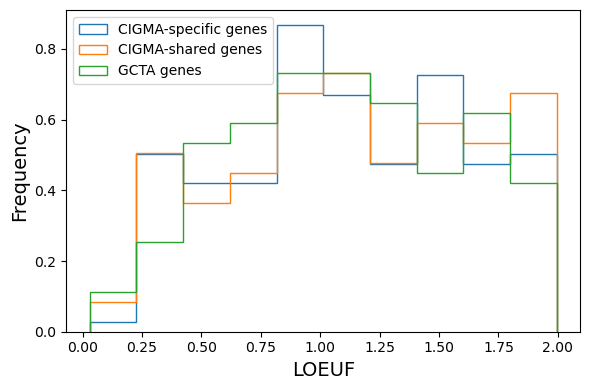

In [12]:
tmp_df = util.read_out(out, ['gene', 'p:free:V', 'p:free:hom_g2'])
tmp_df['var_beta'] = out['free']['ct_beta'].var(axis=1)
tmp_df = tmp_df.merge(eds[['gene', 'LOEUF']])
tmp_df = tmp_df.merge(gcta[['gene', 'p']].rename(columns={'p': 'p_GCTA'}))

specific_genes = tmp_df.loc[tmp_df['p:free:V'] < 0.05/len(out['gene'])]['gene'].values
ngene = len(specific_genes)
print(ngene)
shared_genes = tmp_df.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene]
deg_genes = tmp_df.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene]
gcta_genes = tmp_df.sort_values(by=['p_GCTA'])['gene'].values[:ngene]

fig, ax = plt.subplots(figsize=(6, 4),)
bins = np.histogram_bin_edges(tmp_df['LOEUF'].dropna(), bins=10)
# ax.hist(tmp_df['LOEUF'], bins=bins, color='gray', alpha=0.7, density=True, label='All genes')

# for label in ['CIGMA-specific genes', 'CIGMA-shared genes', 'DEG genes', 'GCTA genes']:
for label in ['CIGMA-specific genes', 'CIGMA-shared genes', 'GCTA genes']:

    if label == 'CIGMA-shared genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(shared_genes)]
    elif label == 'CIGMA-specific genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(specific_genes)]
    elif label == 'DEG genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(deg_genes)]
    elif label == 'GCTA genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(gcta_genes)]

    ax.hist(subset['LOEUF'], bins=bins, histtype='step', density=True, label=label)
    ax.legend()

ax.set_xlabel('LOEUF', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)


fig.tight_layout()

184


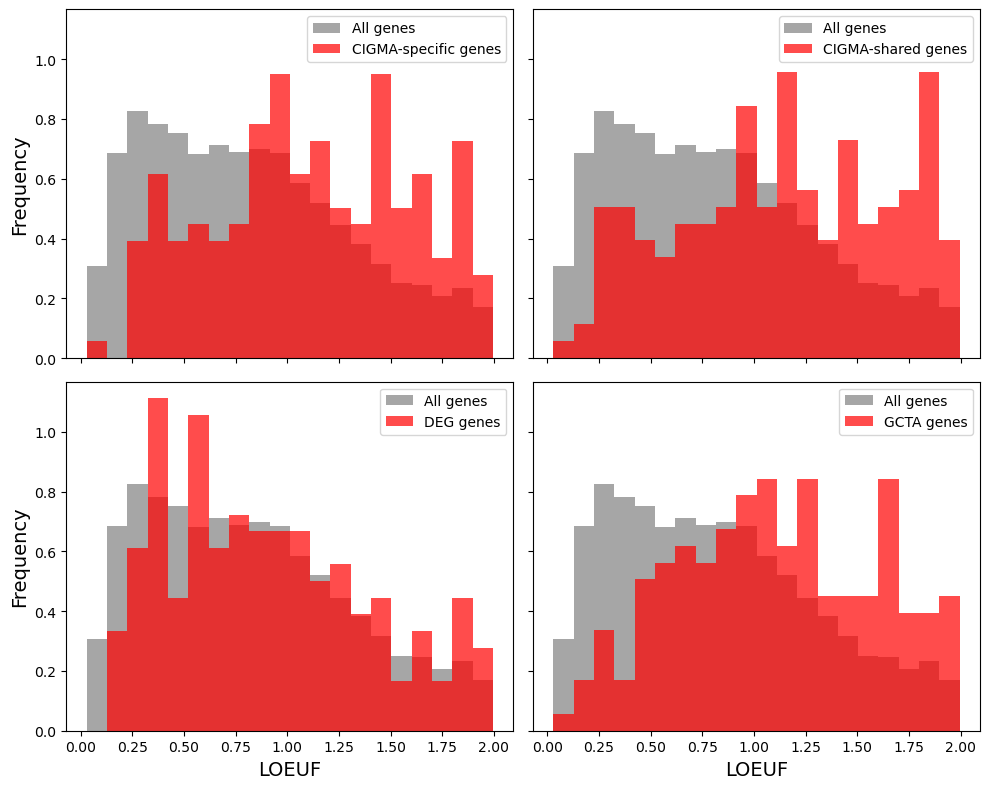

In [ ]:
tmp_df = util.read_out(out, ['gene', 'p:free:V', 'p:free:hom_g2'])
tmp_df['var_beta'] = out['free']['ct_beta'].var(axis=1)
tmp_df = tmp_df.merge(eds[['gene', 'LOEUF']])
tmp_df = tmp_df.merge(gcta[['gene', 'p']].rename(columns={'p': 'p_GCTA'}))

specific_genes = tmp_df.loc[tmp_df['p:free:V'] < 0.05/len(out['gene'])]['gene'].values
ngene = len(specific_genes)
print(ngene)
shared_genes = tmp_df.sort_values(by=['p:free:hom_g2'])['gene'].values[:ngene]
deg_genes = tmp_df.sort_values(by=['var_beta'], ascending=False)['gene'].values[:ngene]
gcta_genes = tmp_df.sort_values(by=['p_GCTA'])['gene'].values[:ngene]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
bins = np.histogram_bin_edges(tmp_df['LOEUF'].dropna(), bins=20)

for ax, label in zip(axes.flatten(), ['CIGMA-specific genes', 'CIGMA-shared genes', 'DEG genes', 'GCTA genes']):
    ax.hist(tmp_df['LOEUF'], bins=bins, color='gray', alpha=0.7, density=True, label='All genes')

    if label == 'CIGMA-shared genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(shared_genes)]
    elif label == 'CIGMA-specific genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(specific_genes)]
    elif label == 'DEG genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(deg_genes)]
    elif label == 'GCTA genes':
        subset = tmp_df.loc[tmp_df['gene'].isin(gcta_genes)]

    ax.hist(subset['LOEUF'], bins=bins, color='red', alpha=0.7, density=True, label=label)
    ax.legend()

axes[1, 0].set_xlabel('LOEUF', fontsize=14)
axes[1, 1].set_xlabel('LOEUF', fontsize=14)
axes[0, 0].set_ylabel('Frequency', fontsize=14)
axes[1, 0].set_ylabel('Frequency', fontsize=14)

fig.tight_layout()

# CIGMA cis-window size

In [ ]:
# windows = [5, 20, 50, 100, 300, 700]

# out_dfs = {}
# for window in windows:
#     out_f = f'../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/cis_window_{window}000/he.free.jk.npy'
#     tmp_out = np.load(out_f, allow_pickle=True).item()
#     out_dfs[window] = util.read_out(tmp_out, ['gene','free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v'})
#     out_dfs[window]['g'] = out_dfs[window]['hom_g2'] + out_dfs[window]['v']
#     out_dfs[window]['specificity'] = out_dfs[window]['v'] / out_dfs[window]['g']

# out_df = util.read_out(out, ['gene','free:hom_g2', 'free:v', 'p:free:hom_g2', 'p:free:V']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'v'})
# out_df['g'] = out_df['hom_g2'] + out_df['v']
# out_df['specificity'] = out_df['v'] / out_df['g']

# # merge all windows
# df = out_df.copy()
# df = df.loc[df['g'] > 0]

# for window in windows:
#     tmp_df = out_dfs[window]
#     tmp_df = tmp_df.loc[tmp_df['g'] > 0, ['gene', 'g', 'specificity', 'hom_g2', 'v']]
#     df = df.merge(tmp_df, on='gene', suffixes=('', f'_{window}'))
# df = df.rename(columns={'hom_g2': 'hom_g2_500', 'v': 'v_500', 'g': 'g_500', 'specificity': 'specificity_500'})
# windows.append(500)
# windows = sorted(windows)
# print(df.shape[0], 'genes with g > 0 in all windows')

5438 genes with g > 0 in all windows


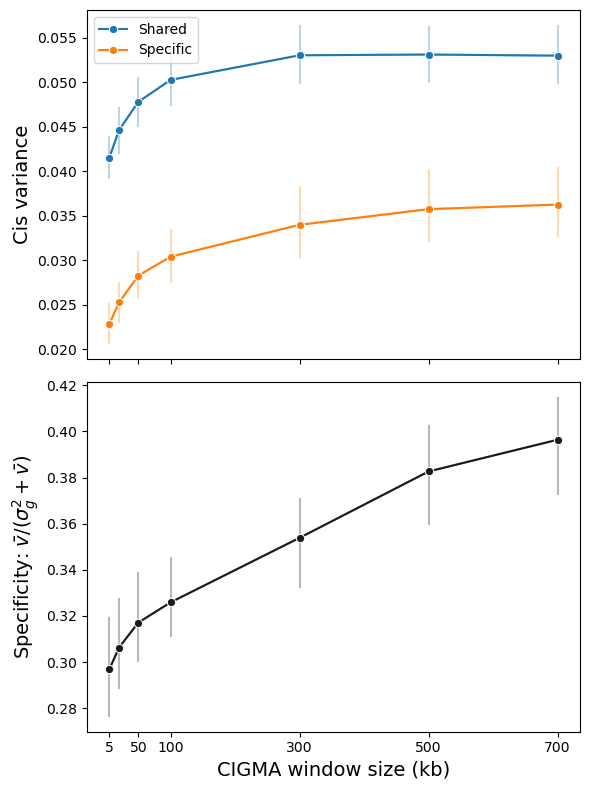

In [ ]:
# # plot
# colors = sns.color_palette()
# alpha = 0.3
# fs = 12

# fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# for x in ['hom_g2', 'v', 'specificity']:
#     if x == 'hom_g2':
#         ax = axes[0]
#         color = colors[0]
#         label = 'Shared'
#         estimator = 'mean'
#     elif x == 'v':
#         ax = axes[0]
#         color = colors[1]
#         label = 'Specific'
#         estimator = 'mean'
#     elif x == 'specificity':
#         ax = axes[1]
#         color = '0.1'
#         label = 'Specificity'
#         estimator = 'median'
#     tmp_df = df.copy()
#     melt_df = tmp_df.melt(id_vars=['gene'], value_vars=[f'{x}_{w}' for w in windows],
#                     var_name='window', value_name=x)
#     melt_df['window'] = melt_df['window'].str.replace(f'{x}_', '')
#     melt_df['window'] = melt_df['window'].astype(int)

#     # all genes
#     sns.lineplot(data=melt_df, x='window', y=x, err_style='bars',
#                     marker=False, estimator=estimator, alpha=alpha, color=color, ax=ax)
#     sns.lineplot(data=melt_df, x='window', y=x, errorbar=None,
#                     marker='o', estimator=estimator, label=label, color=color, ax=ax)



# # change x ticks to windows
# xticks = windows.copy()
# xticks.remove(20)
# axes[1].set_xticks(ticks=xticks, labels=[str(w) for w in xticks])

# axes[1].set_xlabel('CIGMA window size (kb)', fontsize=14)
# axes[0].set_ylabel('Cis variance', fontsize=14)
# axes[1].set_ylabel('Specificity: ' r'$\bar{v} / (\sigma_g^2 + \bar{v})$', fontsize=14)
# axes[0].legend()
# axes[1].legend().set_visible(False)

# fig.tight_layout()

hom_g2
window
5      0.041492
20     0.044599
50     0.047783
100    0.050252
300    0.053018
500    0.053101
700    0.052977
Name: hom_g2, dtype: float64
v
window
5      0.022794
20     0.025241
50     0.028254
100    0.030389
300    0.033969
500    0.035727
700    0.036243
Name: v, dtype: float64
specificity
window
5      0.296817
20     0.306288
50     0.317134
100    0.325903
300    0.353872
500    0.382627
700    0.396380
Name: specificity, dtype: float64


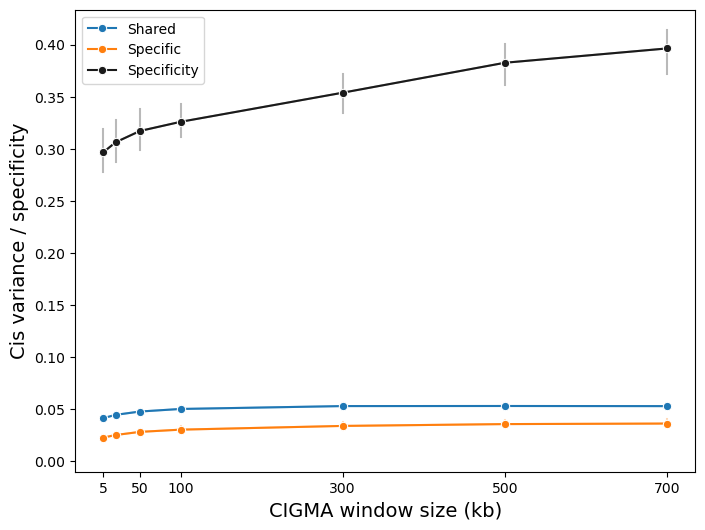

In [ ]:
# # plot
# colors = sns.color_palette()
# alpha = 0.3
# fs = 12

# plt.figure(figsize=(8, 6))

# for x in ['hom_g2', 'v', 'specificity']:
#     if x == 'hom_g2':
#         color = colors[0]
#         label = 'Shared'
#         estimator = 'mean'
#     elif x == 'v':
#         color = colors[1]
#         label = 'Specific'
#         estimator = 'mean'
#     elif x == 'specificity':
#         color = '0.1'
#         label = 'Specificity'
#         estimator = 'median'
#     tmp_df = df.copy()
#     melt_df = tmp_df.melt(id_vars=['gene'], value_vars=[f'{x}_{w}' for w in windows],
#                     var_name='window', value_name=x)
#     melt_df['window'] = melt_df['window'].str.replace(f'{x}_', '')
#     melt_df['window'] = melt_df['window'].astype(int)
#     print(x)
#     if x in ['hom_g2', 'v']:
#         print(melt_df.groupby('window')[x].mean())
#     else:
#         print(melt_df.groupby('window')[x].median())

#     # all genes
#     sns.lineplot(data=melt_df, x='window', y=x, err_style='bars',
#                     marker=False, estimator=estimator, alpha=alpha, color=color)
#     sns.lineplot(data=melt_df, x='window', y=x, errorbar=None,
#                     marker='o', estimator=estimator, label=label, color=color)




# # change x ticks to windows
# xticks = windows.copy()
# xticks.remove(20)
# plt.xticks(ticks=xticks, labels=[str(x0) for x0 in xticks])


# plt.xlabel('CIGMA window size (kb)', fontsize=14)
# plt.ylabel('Cis variance / specificity', fontsize=14)
# # plt.grid()
# plt.legend()
# plt.ylim(bottom=-.01)
# plt.show()

# Coding variants

[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

Feature: specificity
50 40
Pos trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0    -0.543637        0.279366  0.051659
1   1     0.054580        0.292939  0.852194
2   2    -0.466743        0.286876  0.103740
3   3    -0.515840        0.284816  0.070120
4   4    -0.062614        0.319229  0.844500
  bin  Coefficient  Coefficient_se         p
0   1     0.463707        0.271608  0.087773
1   2     0.642656        0.319337  0.044170
2   3     0.362886        0.323332  0.261721
3   4     0.413275        0.375070  0.270523
Neg trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0     0.088118        0.192623  0.647340
1   1    -0.013530        0.194678  0.944591
2   2    -0.212150        0.228440  0.353049
3   3    -0.042932        0.221033  0.845994
4   4    -0.318022        0.176251  0.071173
  bin  Coefficient  Coefficient_se         p
0   1    -0.087775        0.228803  0.701254
1   2     0.153698        0.208448  0.460914
2   3    -0.020874     

[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

Pos trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0     0.033329        0.332105  0.920062
1   1     0.058223        0.350971  0.868243
2   2    -0.254680        0.277286  0.358369
3   3    -0.490865        0.255376  0.054590
4   4    -0.298615        0.289589  0.302463
  bin  Coefficient  Coefficient_se         p
0   1     0.346615        0.287396  0.227798
1   2     0.536181        0.327419  0.101506
2   3     0.268797        0.311050  0.387501
3   4     0.357356        0.389997  0.359507
Neg trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0    -0.324654        0.173191  0.060855
1   1    -0.121321        0.237961  0.610167
2   2     0.003872        0.198159  0.984409
3   3    -0.032588        0.203630  0.872854
4   4    -0.095093        0.206648  0.645395
  bin  Coefficient  Coefficient_se         p
0   1    -0.151488        0.220965  0.492983
1   2     0.157242        0.211310  0.456800
2   3    -0.022869        0.227263  0.919844
3   4

[2025-11-18 14:51:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-18 14:51:22 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

Feature: var_beta
50 40
Pos trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0     0.043391        0.300939  0.885355
1   1    -0.295105        0.294600  0.316481
2   2    -0.550879        0.229510  0.016384
3   3    -0.012881        0.328334  0.968707
4   4    -0.030900        0.333093  0.926089
  bin  Coefficient  Coefficient_se         p
0   1     0.179884        0.303776  0.553744
1   2     0.428810        0.328279  0.191472
2   3     0.161352        0.331285  0.626224
3   4     0.234453        0.400595  0.558371
Neg trait meta-analysis:
  bin  Coefficient  Coefficient_se         p
0   0     0.046740        0.199558  0.814818
1   1    -0.007504        0.208612  0.971307
2   2    -0.084246        0.155771  0.588622
3   3    -0.435647        0.167981  0.009502
4   4     0.200367        0.323840  0.536100
  bin  Coefficient  Coefficient_se         p
0   1    -0.162011        0.244059  0.506807
1   2     0.074128        0.221075  0.737393
2   3    -0.015027        

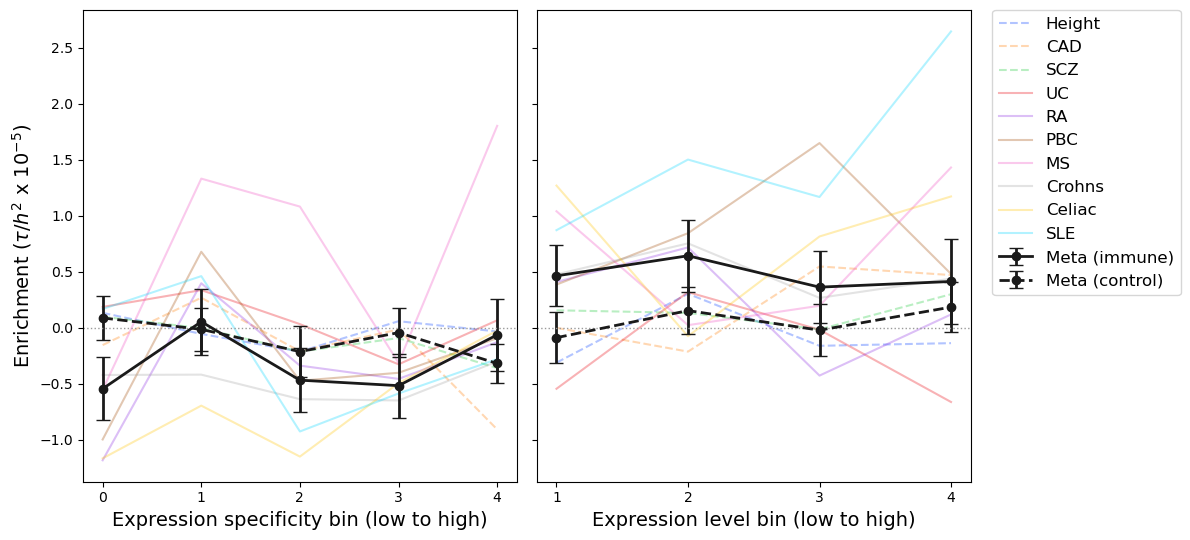

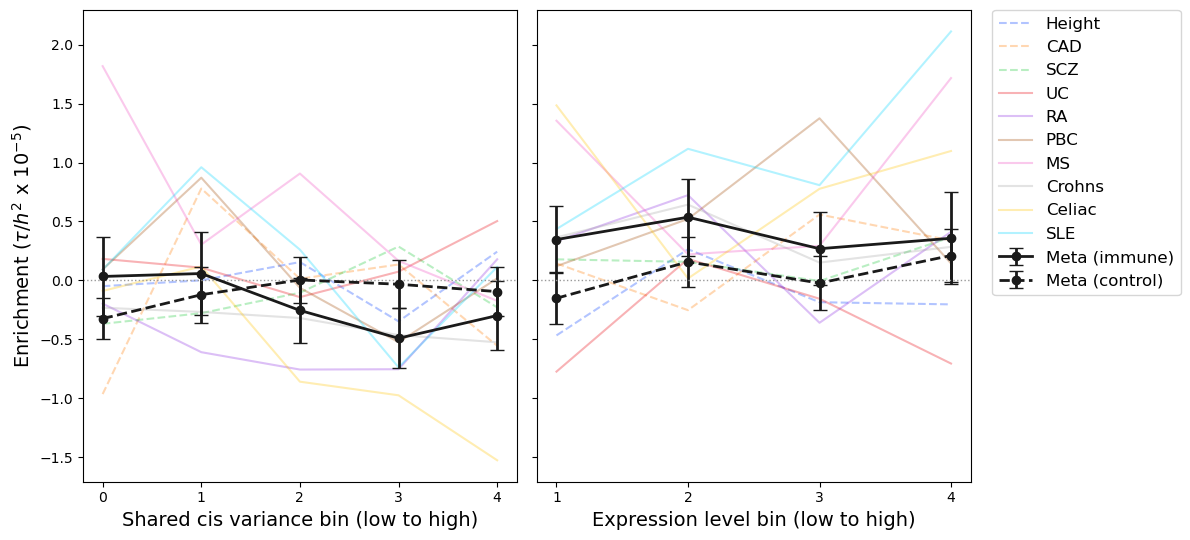

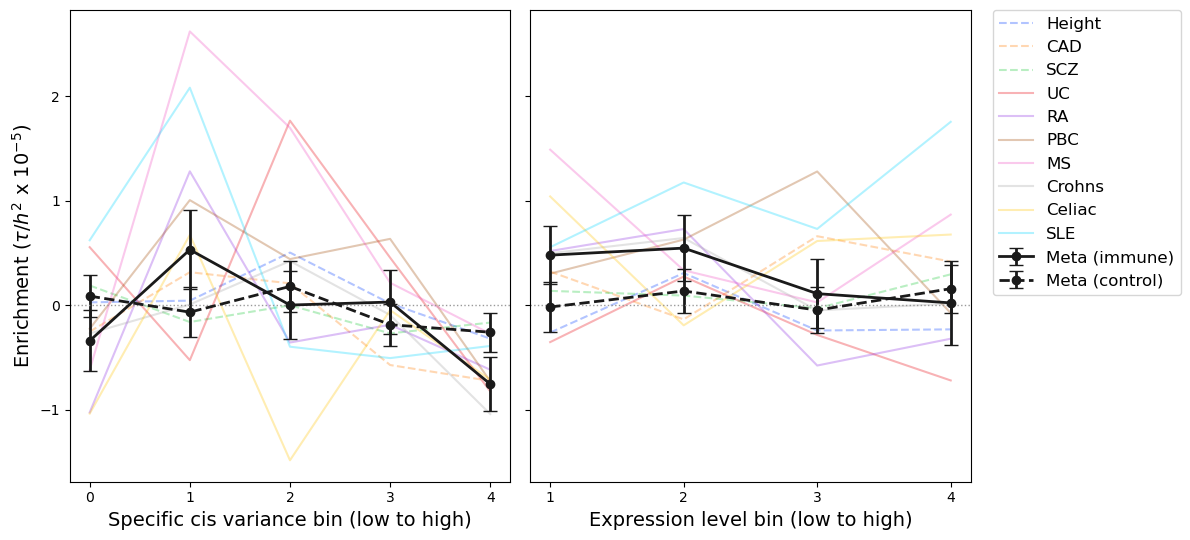

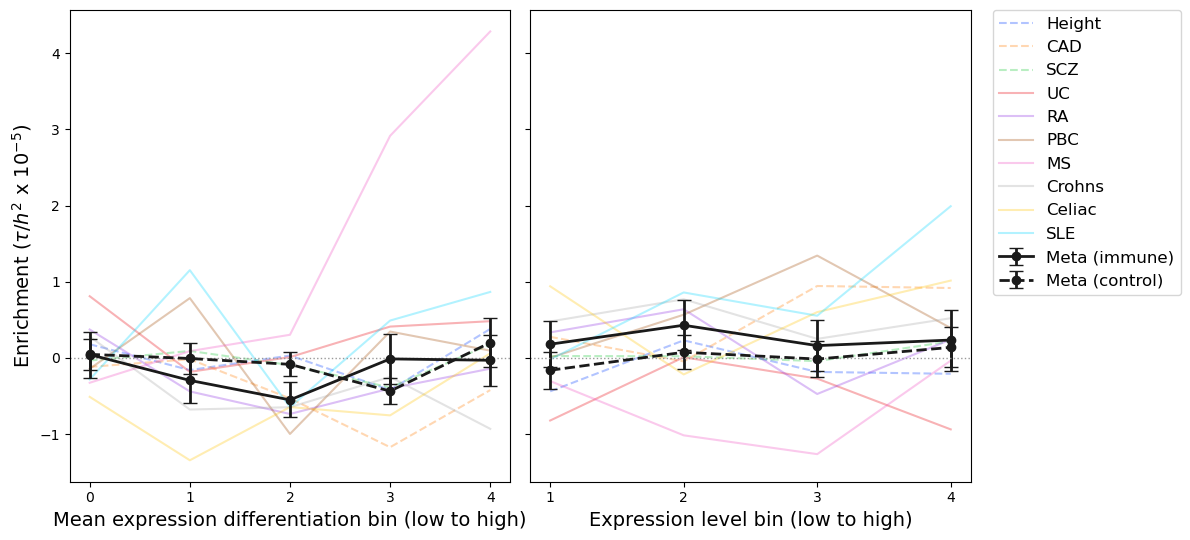

In [15]:
coding_var = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc_coding/var.results')
# coding_mean = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc_coding/mean.results')

coding_var['gwas'] = coding_var['gwas'].replace({'Lupus': 'SLE'})

# change coefficient to tau / h2
coding_var['Coefficient'] = coding_var['Coefficient'] / coding_var['h2']
coding_var['Coefficient_std_error'] = coding_var['Coefficient_std_error'] / coding_var['h2']

colors = sns.color_palette('bright')[:len(traits)]
lines = ['-' if trait in pos_traits else '--' for trait in traits]
nbin = 5

for feature in ['specificity', 'hom_g2', 'v', 'var_beta']:
    print(f'Feature: {feature}')
    coding_var_feature = coding_var.loc[coding_var['feature'] == feature].copy()
    # coding_mean_tmp = coding_mean.loc[coding_mean['feature'] == feature].copy()

    coding_var_tmp = coding_var_feature.loc[coding_var_feature['Category'].isin([f'coding_{feature}_bin_{i}L2_0' for i in range(nbin)])].copy()
    coding_var_tmp = coding_var_tmp.loc[coding_var_tmp['nbin'] == nbin]

    coding_mean_tmp = coding_var_feature.loc[coding_var_feature['Category'].isin([f'coding_mean_expr_bin_{i}L2_0' for i in range(1, nbin)])].copy()
    coding_mean_tmp = coding_mean_tmp.loc[coding_mean_tmp['nbin'] == nbin]
    print(coding_var_tmp.shape[0], coding_mean_tmp.shape[0])

    coding_var_tmp.loc[coding_var_tmp['Category'] == f'coding_{feature}_bin_0L2_0', 'bin'] = str(0)
    for i in range(1, nbin):
        coding_var_tmp.loc[coding_var_tmp['Category'] == f'coding_{feature}_bin_{i}L2_0', 'bin'] = str(i)
        coding_mean_tmp.loc[coding_mean_tmp['Category'] == f'coding_mean_expr_bin_{i}L2_0', 'bin'] = str(i)
    coding_var_tmp['Coefficient'] = coding_var_tmp['Coefficient'] * 1e5
    coding_var_tmp['Coefficient_std_error'] = coding_var_tmp['Coefficient_std_error'] * 1e5
    coding_mean_tmp['Coefficient'] = coding_mean_tmp['Coefficient'] * 1e5
    coding_mean_tmp['Coefficient_std_error'] = coding_mean_tmp['Coefficient_std_error'] * 1e5

    fig, axes = plt.subplots(1, 2, figsize=(12, 5.5), sharex='col', sharey=True)

    for trait, color, line in zip(traits, colors, lines):
        g1 = coding_var_tmp.loc[coding_var_tmp['gwas'] == trait]
        axes[0].plot(g1["bin"], g1["Coefficient"], label=trait, color=color, alpha=.3, linestyle=line)
        g2 = coding_mean_tmp.loc[coding_mean_tmp['gwas'] == trait]
        axes[1].plot(g2["bin"], g2["Coefficient"], label=trait, color=color, alpha=.3, linestyle=line)

    # inverse-variance weighted meta-analysis
    # pos trait
    meta_var = coding_var_tmp.loc[coding_var_tmp['gwas'].isin(pos_traits)].groupby("bin").apply(
        lambda x: pd.Series({
            "Coefficient": np.sum(x["Coefficient"] / x["Coefficient_std_error"]**2) / np.sum(1 / x["Coefficient_std_error"]**2),
            "Coefficient_se": np.sqrt(1 / np.sum(1 / x["Coefficient_std_error"]**2))
        })
    ).reset_index()
    meta_mean = coding_mean_tmp.loc[coding_mean_tmp['gwas'].isin(pos_traits)].groupby("bin").apply(
        lambda x: pd.Series({
            "Coefficient": np.sum(x["Coefficient"] / x["Coefficient_std_error"]**2) / np.sum(1 / x["Coefficient_std_error"]**2),
            "Coefficient_se": np.sqrt(1 / np.sum(1 / x["Coefficient_std_error"]**2))
        })
    ).reset_index()
    meta_var['p'] = 2 * stats.norm.sf(np.abs(meta_var['Coefficient'] / meta_var['Coefficient_se']))
    meta_mean['p'] = 2 * stats.norm.sf(np.abs(meta_mean['Coefficient'] / meta_mean['Coefficient_se']))
    print('Pos trait meta-analysis:')
    print(meta_var)
    print(meta_mean)

    axes[0].errorbar(meta_var["bin"], meta_var["Coefficient"], yerr=meta_var["Coefficient_se"], label='Meta (immune)', color='0.1', fmt='-o', lw=2, capsize=5)
    axes[1].errorbar(meta_mean["bin"], meta_mean["Coefficient"], yerr=meta_mean["Coefficient_se"], label='Meta (immune)', color='0.1', fmt='-o', lw=2, capsize=5)

    # neg trait
    meta_var = coding_var_tmp.loc[coding_var_tmp['gwas'].isin(neg_traits)].groupby("bin").apply(
        lambda x: pd.Series({
            "Coefficient": np.sum(x["Coefficient"] / x["Coefficient_std_error"]**2) / np.sum(1 / x["Coefficient_std_error"]**2),
            "Coefficient_se": np.sqrt(1 / np.sum(1 / x["Coefficient_std_error"]**2))
        })
    ).reset_index()
    meta_mean = coding_mean_tmp.loc[coding_mean_tmp['gwas'].isin(neg_traits)].groupby("bin").apply(
        lambda x: pd.Series({
            "Coefficient": np.sum(x["Coefficient"] / x["Coefficient_std_error"]**2) / np.sum(1 / x["Coefficient_std_error"]**2),
            "Coefficient_se": np.sqrt(1 / np.sum(1 / x["Coefficient_std_error"]**2))
        })
    ).reset_index()
    meta_var['p'] = 2 * stats.norm.sf(np.abs(meta_var['Coefficient'] / meta_var['Coefficient_se']))
    meta_mean['p'] = 2 * stats.norm.sf(np.abs(meta_mean['Coefficient'] / meta_mean['Coefficient_se']))
    print('Neg trait meta-analysis:')
    print(meta_var)
    print(meta_mean)

    axes[0].errorbar(meta_var["bin"], meta_var["Coefficient"], yerr=meta_var["Coefficient_se"], label='Meta (control)', color='0.1', fmt='--o', lw=2, capsize=5)
    axes[1].errorbar(meta_mean["bin"], meta_mean["Coefficient"], yerr=meta_mean["Coefficient_se"], label='Meta (control)', color='0.1', fmt='--o', lw=2, capsize=5)

    axes[0].axhline(0, color='0.6', linestyle=':', lw=1)
    axes[1].axhline(0, color='0.6', linestyle=':', lw=1)

    if feature == 'specificity':
        label = 'Expression specificity'
    elif feature == 'hom_g2':
        label = 'Shared cis variance'
    elif feature == 'v':
        label = 'Specific cis variance'
    elif feature == 'var_beta':
        label = 'Mean expression differentiation'
    axes[0].set_xlabel(f"{label} bin (low to high)", fontsize=14)
    axes[1].set_xlabel("Expression level bin (low to high)", fontsize=14)
    axes[0].set_ylabel(r"Enrichment ($\tau / h^2$ x $10^{-5}$)", fontsize=14)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    fig.tight_layout()


# Rare variants

In [ ]:
# read data
rare_maf1_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.maf0.01.jk.npy'
rare_maf2_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.maf1e-10.jk.npy'

rare_maf1 = np.load(rare_maf1_f, allow_pickle=True).item()
rare_maf2 = np.load(rare_maf2_f, allow_pickle=True).item()

# rare_jk_df = util.read_out(jk, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2'])
rare_maf1_df = util.read_out(rare_maf1, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2', 'p:free:V'])
rare_maf2_df = util.read_out(rare_maf2, ['gene', 'free:hom_g2', 'free:v', 'free:hom_e2', 'free:w', 'free:shared_h2', 'free:specific_h2', 'p:free:V'])

dfs = [rare_maf1_df, rare_maf2_df]
for i, df in enumerate(dfs):
    df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
    df['g'] = df['V'] + df['hom_g2']
    df['specificity'] = df['V'] / df['g']
    # gf['std_beta'] = np.sqrt(gf['var_beta'])

    ## merge with eds
    print(df.shape)
    df = df.merge(eds, on='gene')

    ## add OP
    op = pd.read_table(op_f, index_col=0).mean(axis=0)
    op.name = 'mean_expr'
    op = op.reset_index().rename(columns={'index': 'gene'})

    df = df.merge(op, on='gene')
    dfs[i] = df
rare_maf1_df, rare_maf2_df = dfs


# LDSC
rare_ldsc = pd.read_table('../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc/he.rare.cell_type_results.txt')
rare_ldsc.loc[rare_ldsc['trait'] == 'Lupus', 'trait'] = 'SLE'
rare_ldsc = rare_ldsc.loc[(rare_ldsc['ngene'] == 200) & (rare_ldsc['window'] == 500000)]

(10288, 10)
(10290, 10)


In [ ]:
print(traits)

['Height', 'CAD', 'SCZ', 'UC', 'RA', 'PBC', 'MS', 'Crohns', 'Celiac', 'SLE']


In [ ]:
print(rare_ldsc.head())
print(rare_ldsc['trait'].unique())
print(rare_ldsc['maf'].unique())
print(rare_ldsc['Name'].unique())
print(rare_maf1_df.head())

       Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait  \
280  shared  3.756786e-09           9.056406e-09             0.339137  Height   
281    gcta  1.837279e-09           6.566187e-09             0.389812  Height   
282     var  1.203133e-10           8.904871e-09             0.494610  Height   
283    mean -1.126715e-08           6.078901e-09             0.968094  Height   
284  shared  4.587934e-09           4.683851e-09             0.163661     CAD   

     ngene  window   maf  
280    200  500000  0.01  
281    200  500000  0.01  
282    200  500000  0.01  
283    200  500000  0.01  
284    200  500000  0.01  
['Height' 'CAD' 'SCZ' 'UC' 'RA' 'PBC' 'MS' 'Crohns' 'Celiac' 'SLE']
[1.e-02 1.e-10]
['shared' 'gcta' 'var' 'mean']
              gene    hom_g2         V  free:hom_e2    free:w  free:shared_h2  \
0  ENSG00000188976  0.004019 -0.001193     0.097406  0.129827        0.017470   
1  ENSG00000187961  0.012103 -0.075863     0.075894 -0.271095       -0.046

[2025-11-11 11:09:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7087, 26) 7037 7073 3844
LOEUF


[2025-11-11 11:09:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:53 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:54 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:09:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:55 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(80, 8) (40, 8)
       Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait  \
280  shared  3.756786e-09           9.056406e-09             0.339137  Height   
281    gcta  1.837279e-09           6.566187e-09             0.389812  Height   
282     var  1.203133e-10           8.904871e-09             0.494610  Height   
283    mean -1.126715e-08           6.078901e-09             0.968094  Height   
284  shared  4.587934e-09           4.683851e-09             0.163661     CAD   
285     var  2.695112e-09           4.404430e-09             0.270299     CAD   
286    mean  1.641685e-09           4.748672e-09             0.364779     CAD   
287    gcta -5.745047e-09           4.397731e-09             0.904286     CAD   
288     var -5.986814e-09           7.033225e-09             0.802676     SCZ   
289    mean -1.005700e-08           7.570243e-09             0.907992     SCZ   
290  shared -1.206623e-08           8.134660e-09             0.931004     SCZ   
291    gcta 

/tmp/ipykernel_539401/3754700804.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


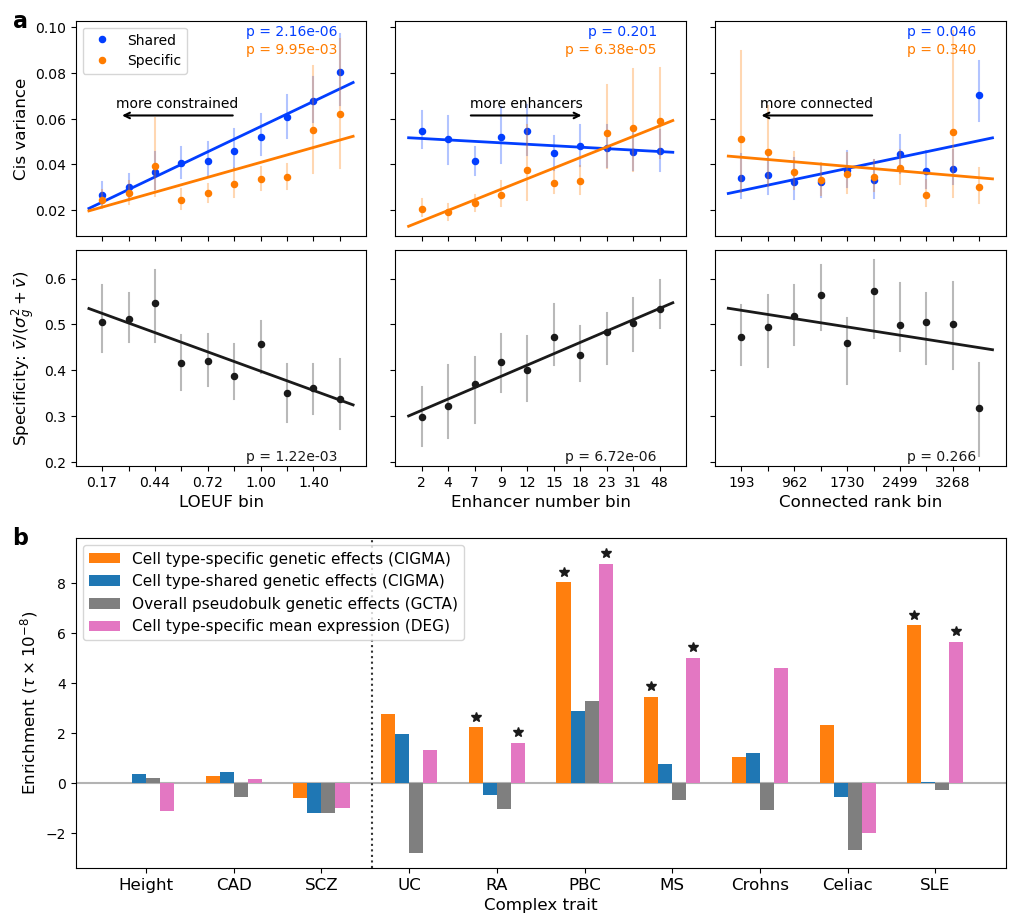

[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7060, 26) 7010 7046 3848
LOEUF


[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:56 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:57 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:09:57 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:57 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:58 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:58 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:58 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:09:58 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:09:58 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(80, 8) (40, 8)
       Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait  \
760  shared  1.531116e-09           9.059389e-09             0.432895  Height   
761     var -3.508538e-11           8.814350e-09             0.501588  Height   
762    gcta -5.426997e-09           5.937651e-09             0.819641  Height   
763    mean -1.126712e-08           6.078901e-09             0.968093  Height   
764     var  3.885472e-09           4.509972e-09             0.194473     CAD   
765  shared  3.224520e-09           4.531482e-09             0.238362     CAD   
766    mean  1.641693e-09           4.748672e-09             0.364778     CAD   
767    gcta -4.790179e-09           4.089338e-09             0.879277     CAD   
768    gcta  2.521370e-09           7.646827e-09             0.370803     SCZ   
769     var -6.667391e-09           6.003426e-09             0.866629     SCZ   
770    mean -1.005696e-08           7.570244e-09             0.907991     SCZ   
771  shared 

/tmp/ipykernel_539401/3754700804.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


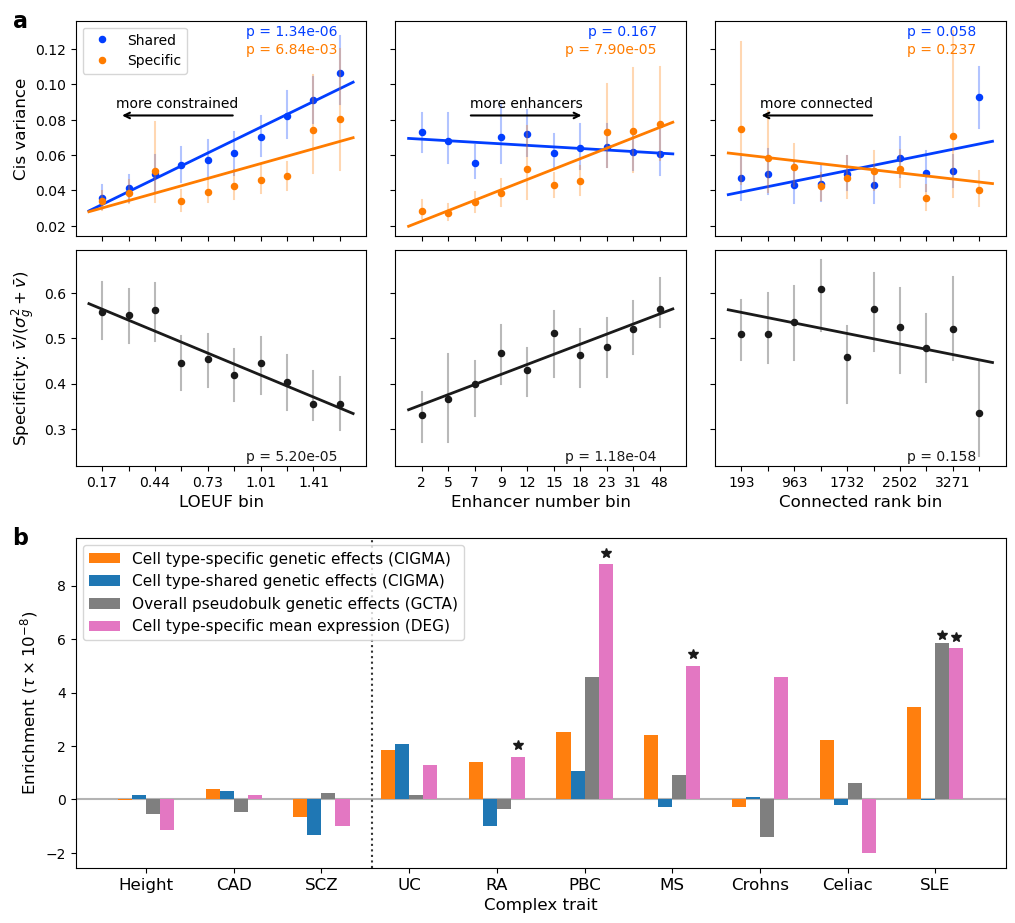

In [ ]:
# Fig 4
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')

for maf, df in zip([0.01, 1e-10], [rare_maf1_df, rare_maf2_df]):
    fig = plt.figure(1, figsize=(12, 11))
    gs = gridspec.GridSpec(30, 3, wspace=0.1, hspace=1)

    # genomic feature
    data = df.copy()
    data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
    filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
    data = data.loc[~filter]
    print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
    # rerank connectness
    data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

    # divide gene annotation into bins
    annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
    for annotation in annotations:
        data = plot.bin_gene_annotation(data, annotation, 10)

    # arrange axes
    ax11 = fig.add_subplot(gs[:8, 0])
    ax12 = fig.add_subplot(gs[:8, 1], sharey=ax11)
    ax13 = fig.add_subplot(gs[:8, 2], sharey=ax11)
    ax21 = fig.add_subplot(gs[8:16, 0], sharex=ax11)
    ax22 = fig.add_subplot(gs[8:16, 1], sharex=ax12, sharey=ax21)
    ax23 = fig.add_subplot(gs[8:16, 2], sharex=ax13, sharey=ax21)
    axes = np.array([[ax11, ax12, ax13],
                    [ax21, ax22, ax23]])


    for j, annotation in enumerate(annotations):
        print(annotation)

        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

        ax = axes[0, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        x = 0.9
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


        ax2 = axes[1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'

        if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
            # set x tick labels
            xticklabels = []
            for i, label in enumerate(ax2.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs)

        if j == 0:
            ax.set_ylabel('Cis variance', fontsize=fs)
            ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if j != 0:
            ax.legend().set_visible(False)
        else:
            ax.legend(loc='upper left', fontsize=fs-2)

    # add arrow
    arrow_position = (0.55, 0.56)
    axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
    axes[0, 0].text(0.35, 0.58, 'more constrained', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 0].transAxes)

    axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.35, 0.58, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

    axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
    axes[0, 1].text(0.45, 0.58, 'more enhancers', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 1].transAxes)



    ## LDSC
    # ax = fig.add_subplot(gs[18:, 0])
    ax = fig.add_subplot(gs[18:, :])
    gene_set_order = ['var', 'shared', 'gcta', 'mean']

    tmp_ldsc_data = rare_ldsc.loc[rare_ldsc['maf'] == maf].copy()
    print(rare_ldsc.shape, tmp_ldsc_data.shape)
    print(tmp_ldsc_data)
    x = np.arange(tmp_ldsc_data['trait'].nunique())
    width = 0.16
    # width = 0.32
    ldsc_colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[7], sns.color_palette()[6]]
    multiplier = -len(gene_set_order) / 2 + 0.5

    for i, gene_set in enumerate(gene_set_order):
        if gene_set == 'mean':
            label = 'Cell type-specific mean expression (DEG)'
        elif gene_set == 'var':
            label = 'Cell type-specific genetic effects (CIGMA)'
        elif gene_set =='shared':
            label = 'Cell type-shared genetic effects (CIGMA)'
        elif gene_set == 'gcta':
            label = 'Overall pseudobulk genetic effects (GCTA)'
        offset = width * multiplier
        set_data = tmp_ldsc_data.loc[tmp_ldsc_data['Name'] == gene_set]
        set_data = set_data.set_index('trait')
        ys = set_data['Coefficient'][traits] * 1e8
        rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=ldsc_colors[i])
        # add star
        for p, rect in zip(set_data['Coefficient_P_value'][traits], rects):
            if p < 0.05:
                ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                        color='0.1', markersize=7)

        multiplier += 1
    ax.set_ylabel(r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs)
    # ax.set_ylabel(r'Regression coefficient, $\tau$ ($\times 10^{-8}$)', fontsize=fs)
    ax.set_xlabel('Complex trait', fontsize=fs)

    ax.set_xticks(x, traits, fontsize=fs)
    ax.legend(loc='upper left', fontsize=fs-1)
    ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    # ax.axhline(-np.log10(0.05), linestyle=(0, (6, 6)), color='0.7', zorder=0)

    fig.text(0.085, .89, 'a', fontsize=fs + 4, fontweight='bold', va='top', ha='right')
    fig.text(0.085, .42, 'b', fontsize=fs + 4, fontweight='bold', va='top', ha='right')

    fig.tight_layout()
    plt.show()

184


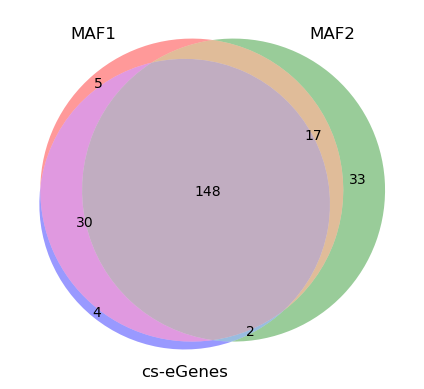

In [ ]:
# venn plot
# %pip install matplotlib-venn
from matplotlib_venn import venn3, venn3_circles

sig_genes = set(gf.loc[gf['p_V'] < p_cut, 'gene'].values)
print(len(sig_genes))
sig_genes1 = set(rare_maf1_df.sort_values(by=['p:free:V'])['gene'].values[:200])
sig_genes2 = set(rare_maf2_df.sort_values(by=['p:free:V'])['gene'].values[:200])

venn3([sig_genes1, sig_genes2, sig_genes], set_labels=('MAF1', 'MAF2', 'cs-eGenes'))

## Joint rare variants

In [ ]:
joint_rare_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.min_maf0.01.max_maf0.05.npy'
joint_rare = np.load(joint_rare_f, allow_pickle=True).item()
joint_rare_df = util.read_out(joint_rare, ['gene', 'free:hom_g2', 'free:v', 'free:hom_g2_b', 'free:v_b'])
joint_rare_df['g'] = joint_rare_df['free:hom_g2'] + joint_rare_df['free:v']
joint_rare_df['g_b'] = joint_rare_df['free:hom_g2_b'] + joint_rare_df['free:v_b']
joint_rare_df['specificity'] = joint_rare_df['free:v'] / joint_rare_df['g']
joint_rare_df['specificity_b'] = joint_rare_df['free:v_b'] / joint_rare_df['g_b']
joint_rare_df = joint_rare_df.merge(eds)

In [ ]:
print(joint_rare_df.shape[0], (joint_rare_df['g'] > 0).sum(), (joint_rare_df['g_b'] > 0).sum(), joint_rare_df.loc[(joint_rare_df['g'] > 0) & (joint_rare_df['g_b'] > 0)].shape[0])

10036 6957 4879 3133


[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(6956, 21) 6911 6943 3782
LOEUF


[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:00 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

(4878, 21) 4835 4865 2672
LOEUF


[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:02 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:03 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:04 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


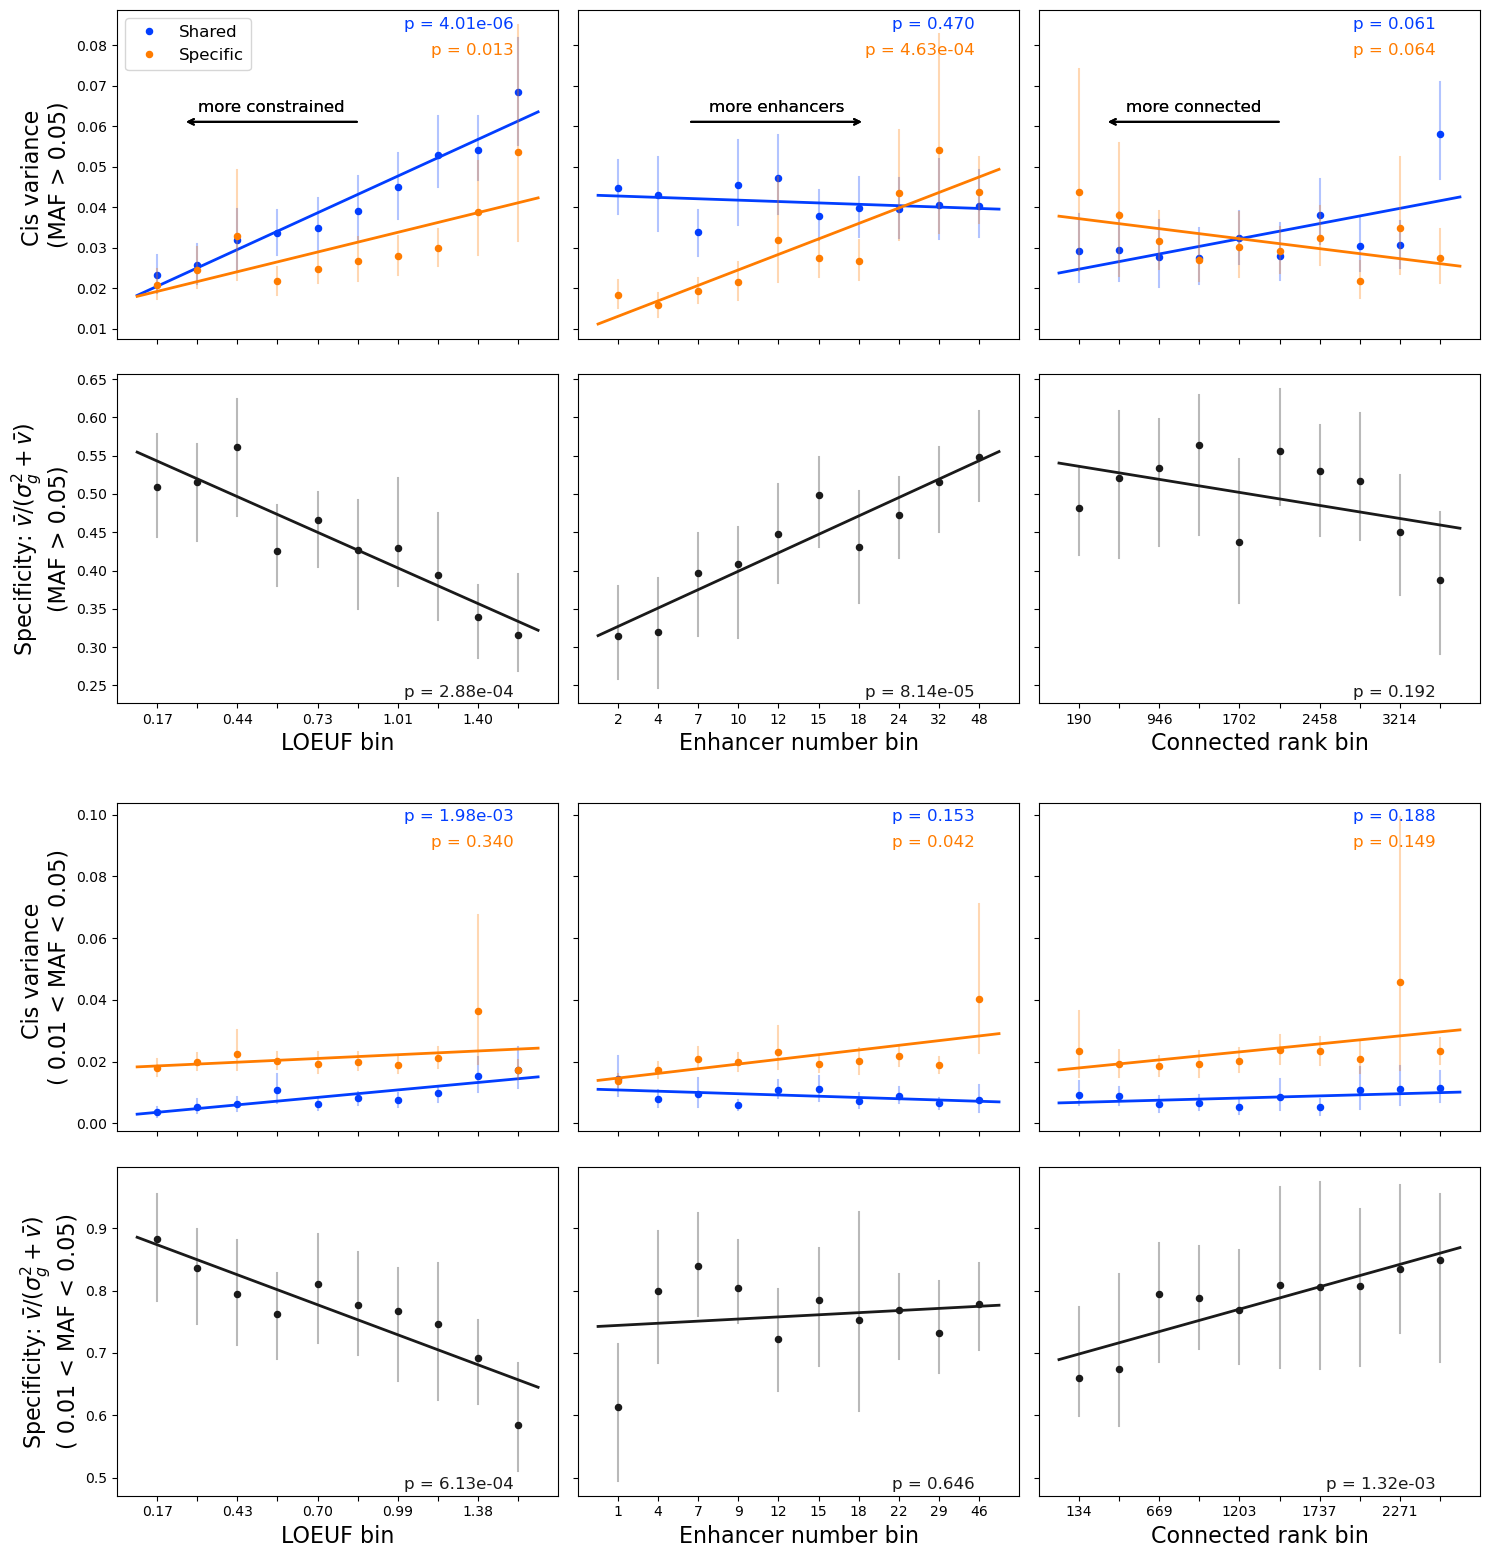

In [ ]:
fs = 14
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')
fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey='row')

for k, variant in enumerate(['common', 'rare']):
    if variant == 'common':
        df = joint_rare_df.copy()[['gene', 'free:hom_g2', 'free:v', 'g', 'specificity']]
        df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
        variant_label = 'MAF > 0.05'
    elif variant == 'rare':
        df = joint_rare_df.copy()[['gene', 'free:hom_g2_b', 'free:v_b', 'g_b', 'specificity_b']]
        df = df.rename(columns={'free:hom_g2_b': 'hom_g2', 'free:v_b': 'V', 'g_b': 'g', 'specificity_b': 'specificity'})
        variant_label = ' 0.01 < MAF < 0.05'

    data = df.merge(eds)
    data = data.merge(op)
    data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
    
    filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
    data = data.loc[~filter]
    print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
    # rerank connectness
    data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

    # divide gene annotation into bins
    annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
    for annotation in annotations:
        data = plot.bin_gene_annotation(data, annotation, 10)


    for j, annotation in enumerate(annotations):
        print(annotation)

        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

        ax = axes[k*2, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        x = 0.9
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


        ax2 = axes[k*2+1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'

        if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
            # set x tick labels
            xticklabels = []
            for i, label in enumerate(ax2.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs+2)

        if j == 0:

            ax.set_ylabel(f'Cis variance \n({variant_label})', fontsize=fs+2)
            ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$' + f' \n({variant_label})', fontsize=fs+2)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if (k == 0) and (j == 0):
            ax.legend(loc='upper left', fontsize=fs-2)
        else:
            ax.legend().set_visible(False)

    # add arrow
    x, y = 0.55, 0.66
    arrow_position = (x, y)
    axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
    axes[0, 0].text(0.35, y+.02, 'more constrained', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 0].transAxes)

    axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.35, y+.02, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

    axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
    axes[0, 1].text(0.45, y+.02, 'more enhancers', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 1].transAxes)


fig.tight_layout()

for ax in np.concatenate([axes[1], axes[3]]):
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])


[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(3132, 21) 3105 3122 1707
LOEUF


[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:05 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:06 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

(3132, 21) 3105 3122 1707
LOEUF


[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:07 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:08 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


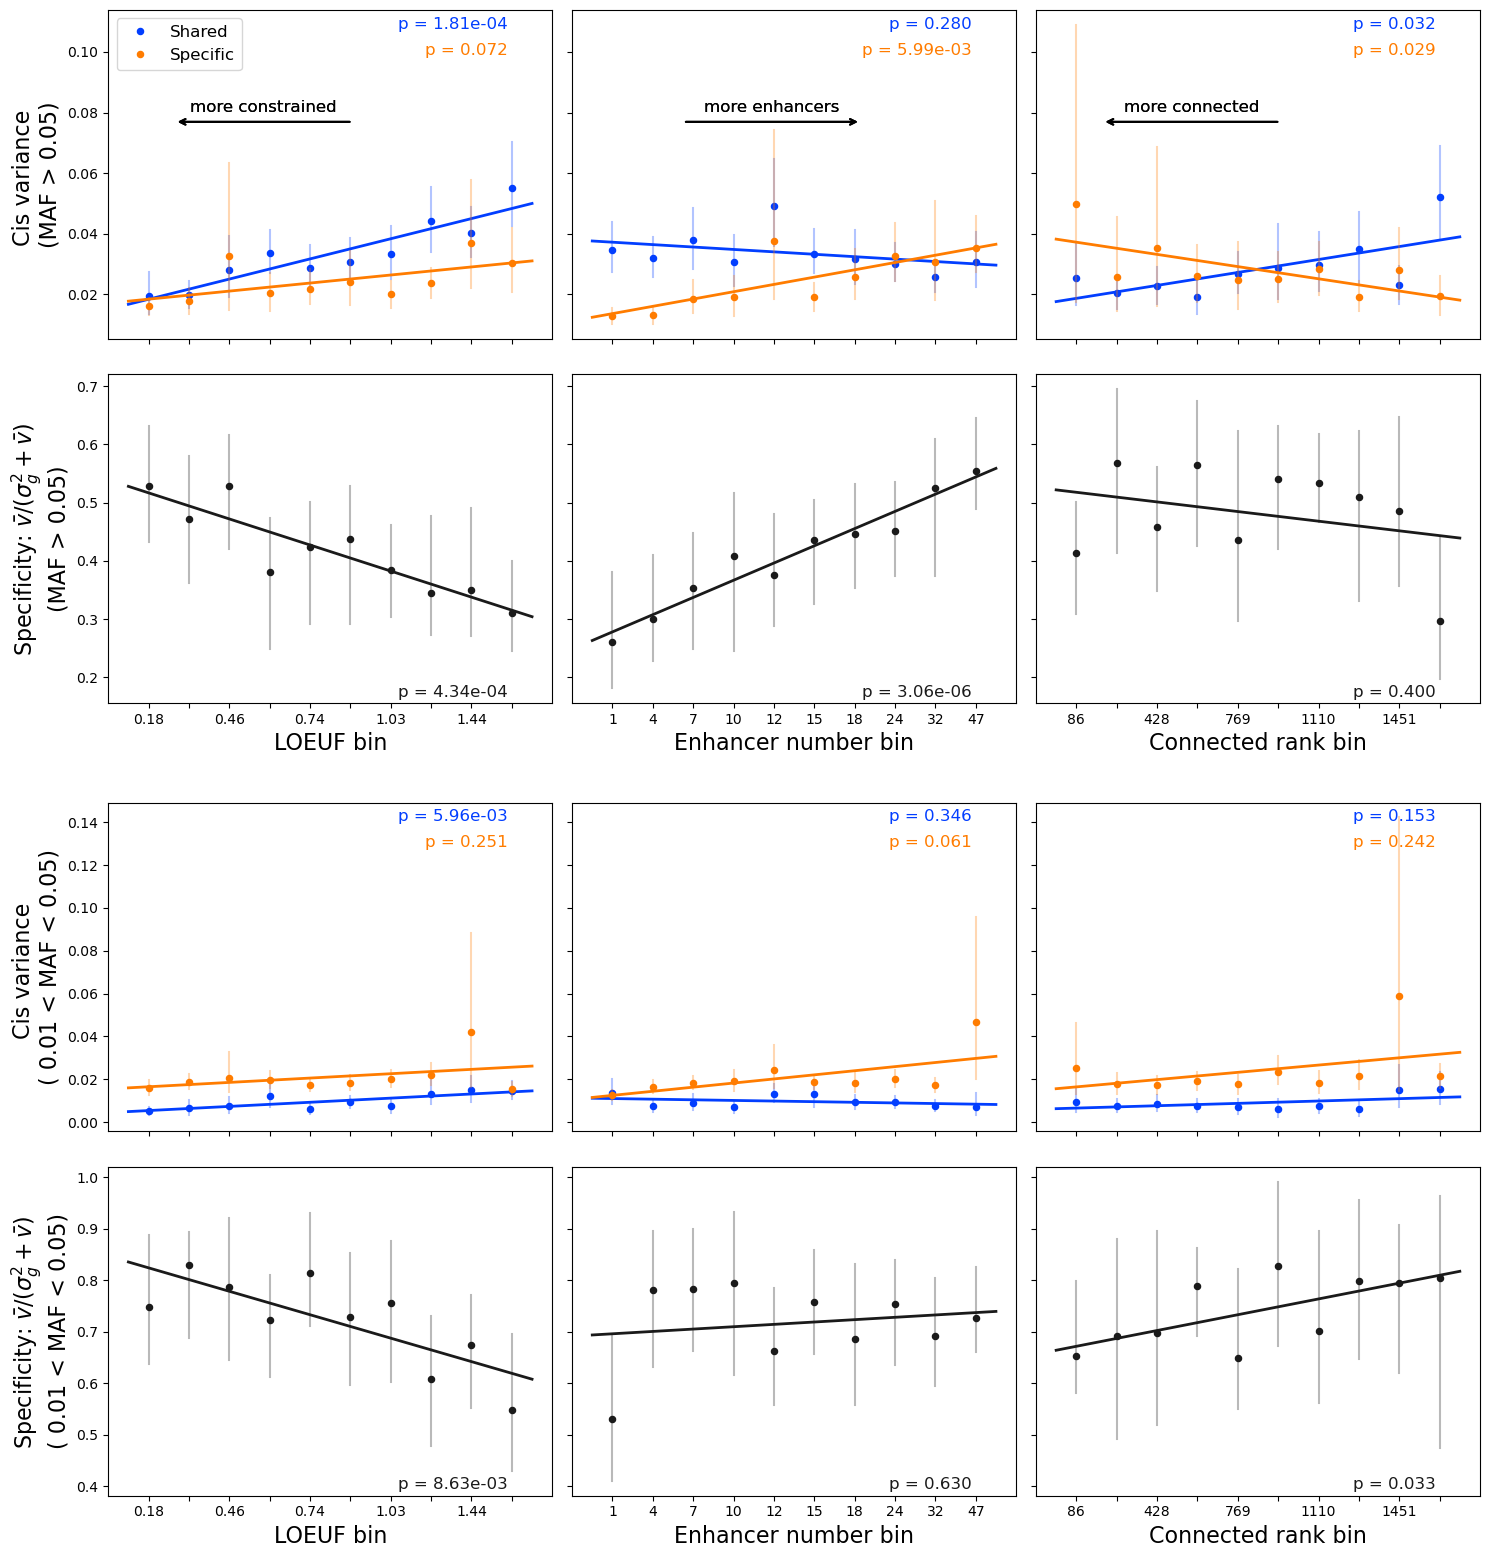

In [ ]:
fs = 14
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')
fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey='row')

for k, variant in enumerate(['common', 'rare']):
    if variant == 'common':
        df = joint_rare_df.loc[(joint_rare_df['g'] > 0) & (joint_rare_df['g_b'] > 0)].copy()[['gene', 'free:hom_g2', 'free:v', 'g', 'specificity']]
        df = df.rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
        variant_label = 'MAF > 0.05'
    elif variant == 'rare':
        df = joint_rare_df.loc[(joint_rare_df['g'] > 0) & (joint_rare_df['g_b'] > 0)].copy()[['gene', 'free:hom_g2_b', 'free:v_b', 'g_b', 'specificity_b']]
        df = df.rename(columns={'free:hom_g2_b': 'hom_g2', 'free:v_b': 'V', 'g_b': 'g', 'specificity_b': 'specificity'})
        variant_label = ' 0.01 < MAF < 0.05'

    data = df.merge(eds)
    data = data.merge(op)
    
    filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
    data = data.loc[~filter]
    print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
    # rerank connectness
    data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

    # divide gene annotation into bins
    annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
    for annotation in annotations:
        data = plot.bin_gene_annotation(data, annotation, 10)


    for j, annotation in enumerate(annotations):
        print(annotation)

        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

        ax = axes[k*2, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        x = 0.9
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


        ax2 = axes[k*2+1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'

        if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
            # set x tick labels
            xticklabels = []
            for i, label in enumerate(ax2.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs+2)

        if j == 0:

            ax.set_ylabel(f'Cis variance \n({variant_label})', fontsize=fs+2)
            ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$' + f' \n({variant_label})', fontsize=fs+2)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if (k == 0) and (j == 0):
            ax.legend(loc='upper left', fontsize=fs-2)
        else:
            ax.legend().set_visible(False)

    # add arrow
    x, y = 0.55, 0.66
    arrow_position = (x, y)
    axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
    axes[0, 0].text(0.35, y+.02, 'more constrained', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 0].transAxes)

    axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.35, y+.02, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

    axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
    axes[0, 1].text(0.45, y+.02, 'more enhancers', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 1].transAxes)


fig.tight_layout()

for ax in np.concatenate([axes[1], axes[3]]):
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])


# Varying cell types

In [ ]:
p5_out = np.load('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.5_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy', allow_pickle=True).item()
p5_P = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.5_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz', index_col=0)
p998_out = np.load('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.998_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy', allow_pickle=True).item()
p998_P = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.998_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz', index_col=0)

p5_df = util.read_out(p5_out, ['gene', 'free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
p998_df = util.read_out(p998_out, ['gene', 'free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})

p5_df['g'] = p5_df['hom_g2'] + p5_df['V']
p5_df['specificity'] = p5_df['V'] / p5_df['g']

p998_df['g'] = p998_df['hom_g2'] + p998_df['V']
p998_df['specificity'] = p998_df['V'] / p998_df['g']

p5_cts = p5_P.columns.tolist()
p998_cts = p998_P.columns.tolist()

In [ ]:
print(p5_cts)
print(p998_cts)
print(p5_P.shape, p998_P.shape)
print(len(p5_out['gene']), len(p998_out['gene']))

['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', 'CD8 ET', 'CD8 NC', 'CD8 S100B', 'Mono C', 'NK']
['CD4 NC', 'CD8 ET', 'CD8 NC', 'NK']
(597, 9) (978, 4)
9757 11476


[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7127, 21) 7073 7113 3822
LOEUF


[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:10 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:11 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:12 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(6391, 21) 6345 6380 3501
LOEUF


[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:13 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:14 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:14 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:14 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:14 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:14 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:15 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


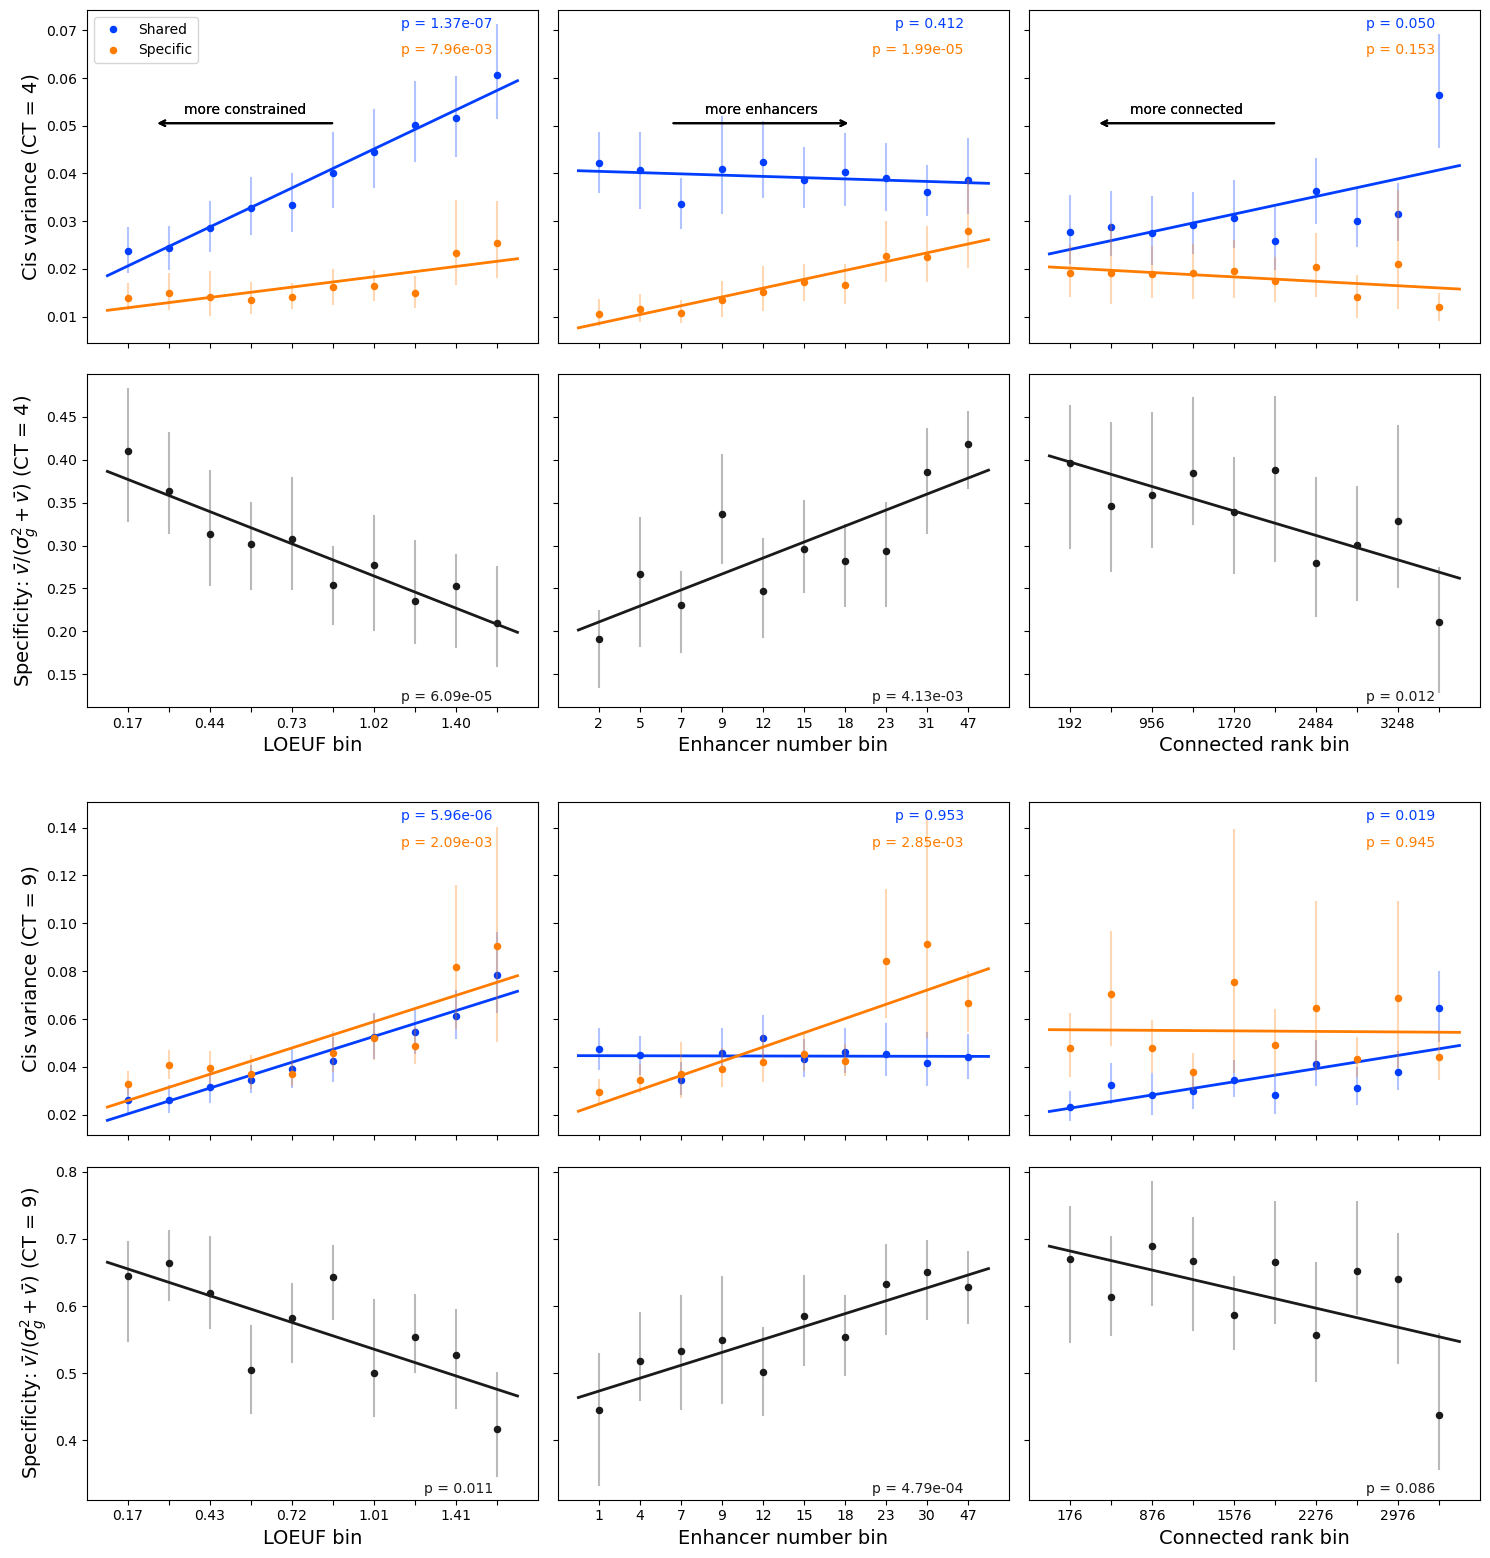

In [ ]:
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')
fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey='row')

for k, df in enumerate([p998_df, p5_df]):
    if df is p5_df:
        n_ct = len(p5_cts)
    elif df is p998_df:
        n_ct = len(p998_cts)

    data = df.merge(eds, on='gene')
    data = data.merge(op, on='gene')
    data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
    
    filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
    data = data.loc[~filter]
    print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
    # rerank connectness
    data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

    # divide gene annotation into bins
    annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
    for annotation in annotations:
        data = plot.bin_gene_annotation(data, annotation, 10)


    for j, annotation in enumerate(annotations):
        print(annotation)

        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

        ax = axes[k*2, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        x = 0.9
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


        ax2 = axes[k*2+1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'

        if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
            # set x tick labels
            xticklabels = []
            for i, label in enumerate(ax2.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs+2)

        if j == 0:
            ax.set_ylabel(f'Cis variance (CT = {n_ct})', fontsize=fs+2)
            ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$' + f' (CT = {n_ct})', fontsize=fs+2)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if (k == 0) and (j == 0):
            ax.legend(loc='upper left', fontsize=fs-2)
        else:
            ax.legend().set_visible(False)

    # add arrow
    x, y = 0.55, 0.66
    arrow_position = (x, y)
    axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
    axes[0, 0].text(0.35, y+.02, 'more constrained', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 0].transAxes)

    axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.35, y+.02, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

    axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
    axes[0, 1].text(0.45, y+.02, 'more enhancers', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 1].transAxes)


fig.tight_layout()

for ax in np.concatenate([axes[1], axes[3]]):
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])


# Lowly and highly expressed genes

In [ ]:
low_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.qcgene0.05.free.jk.npy'
high_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.qcgene0.2.free.jk.npy'

low_out = np.load(low_f, allow_pickle=True).item()
high_out = np.load(high_f, allow_pickle=True).item()

low_df = util.read_out(low_out, ['gene', 'free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
high_df = util.read_out(high_out, ['gene', 'free:hom_g2', 'free:v']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})

low_df['g'] = low_df['hom_g2'] + low_df['V']
high_df['g'] = high_df['hom_g2'] + high_df['V']
low_df['specificity'] = low_df['V'] / low_df['g']
high_df['specificity'] = high_df['V'] / high_df['g']

print(low_df.shape, high_df.shape)
low_df = low_df.merge(eds)
high_df = high_df.merge(eds)
print(low_df.shape, high_df.shape)

# LDSC
low_ldscs = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc_qcgene0.05/top_200/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

low_ldsc_data = []
for stacked_f, trait in zip(low_ldscs, raw_traits):
    tmp = pd.read_table(stacked_f)
    if trait == 'Lupus':
        trait = 'SLE'
    tmp['trait'] = trait
    low_ldsc_data.append(tmp)

low_ldsc_data = pd.concat(low_ldsc_data, ignore_index=True)

high_ldscs = [f'../../results/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ldsc_qcgene0.2/top_200/window_500000/he.{gwas}.cell_type_results.txt'
                    for gwas in raw_traits] 

high_ldsc_data = []
for stacked_f, trait in zip(high_ldscs, raw_traits):
    tmp = pd.read_table(stacked_f)
    if trait == 'Lupus':
        trait = 'SLE'
    tmp['trait'] = trait
    high_ldsc_data.append(tmp)

high_ldsc_data = pd.concat(high_ldsc_data, ignore_index=True)



(11148, 5) (9276, 5)
(10827, 20) (9088, 20)


In [ ]:
# compare with primary analysis
tmp_low_df = util.read_out(low_out, ['gene', 'free:hom_g2', 'free:v', 'p:free:V']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
tmp_low_df = tmp_low_df.loc[~tmp_low_df['gene'].isin(out['gene'])]
tmp_low_df = tmp_low_df.sort_values(by=['p:free:V'])
print(p_cut)
# print(tmp_low_df.head(20))

tmp_df = util.read_out(out, ['gene', 'free:hom_g2', 'free:v', 'p:free:V']).rename(columns={'free:hom_g2': 'hom_g2', 'free:v': 'V'})
tmp_df = tmp_df.loc[tmp_df['gene'].isin(high_out['gene'])]
tmp_df = tmp_df.sort_values(by='p:free:V')
print(tmp_df.loc[tmp_df['p:free:V'] < p_cut].shape[0])

4.860031104199067e-06
173


[2025-11-11 11:10:17 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2025-11-11 11:10:17 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(7533, 20)
(7532, 20) 7479 7517 4103
LOEUF


[2025-11-11 11:10:17 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:17 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:18 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:19 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_539401/743173195.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, c

      Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait
0     gcta  4.949701e-09           5.549196e-09             0.186205  Height
1   shared  3.421362e-09           9.239037e-09             0.355574  Height
2      var  2.966236e-09           9.192557e-09             0.373470  Height
3     mean -1.298391e-08           5.353226e-09             0.992355  Height
4      var  4.069830e-09           4.659112e-09             0.191190     CAD
5   shared  3.904084e-09           4.642287e-09             0.200179     CAD
6     mean  9.937535e-10           3.935779e-09             0.400330     CAD
7     gcta -1.133196e-09           4.019845e-09             0.610990     CAD
8      var -7.075977e-09           7.137082e-09             0.839264     SCZ
9   shared -1.456331e-08           8.385222e-09             0.958787     SCZ
10    mean -1.316404e-08           7.285948e-09             0.964601     SCZ
11    gcta -1.860806e-08           5.664869e-09             0.999490     SCZ

[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:20 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

ActivityLinking_EnhancerNumber


[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

combined_connected_rank


[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-11-11 11:10:21 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


      Name   Coefficient  Coefficient_std_error  Coefficient_P_value   trait
0      var  4.578052e-09           9.165896e-09             0.308726  Height
1   shared  2.775484e-09           8.988497e-09             0.378744  Height
2     gcta -2.989949e-09           6.472357e-09             0.677944  Height
3     mean -1.044156e-08           6.185217e-09             0.954309  Height
4   shared  1.940345e-09           4.696741e-09             0.339757     CAD
5      var  1.239266e-10           4.358022e-09             0.488657     CAD
6     gcta -3.932985e-09           3.901740e-09             0.843275     CAD
7     mean -4.613734e-09           4.070857e-09             0.871468     CAD
8      var -5.212638e-09           7.557314e-09             0.754824     SCZ
9     gcta -7.877813e-09           7.712959e-09             0.846461     SCZ
10    mean -9.353631e-09           8.319233e-09             0.869565     SCZ
11  shared -9.834455e-09           8.527215e-09             0.875607     SCZ

/tmp/ipykernel_539401/743173195.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


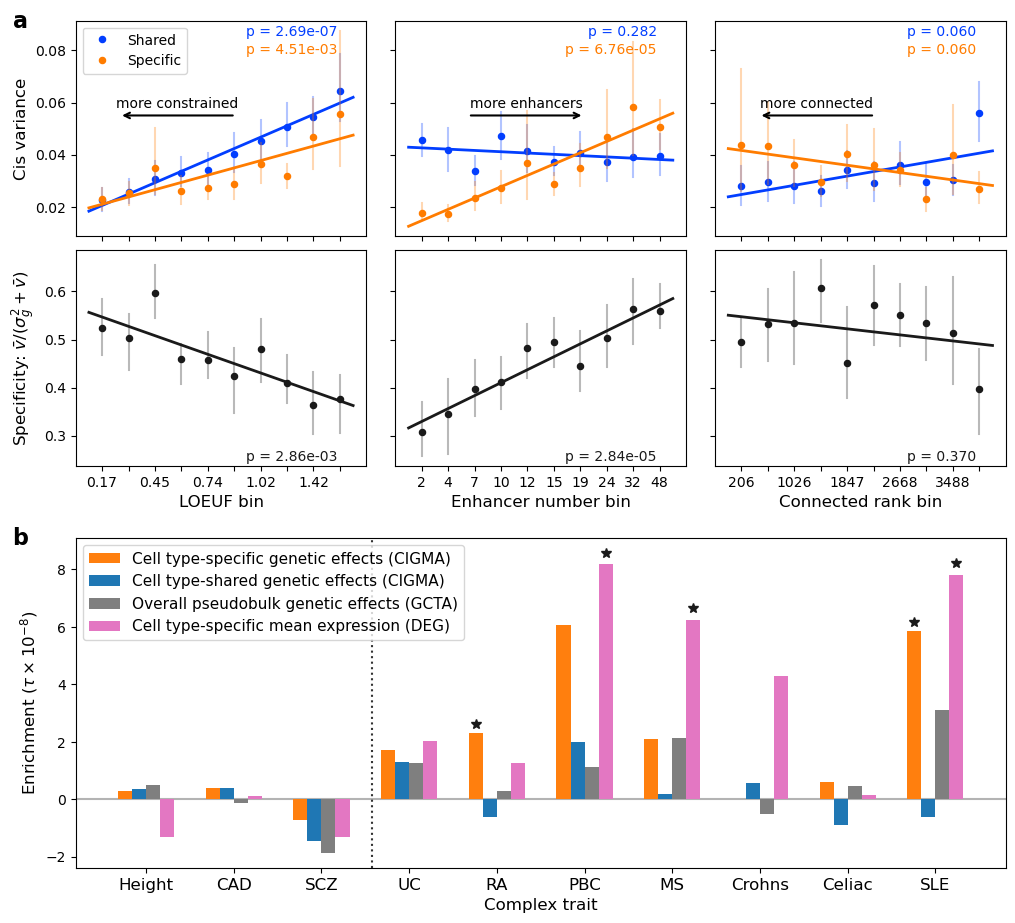

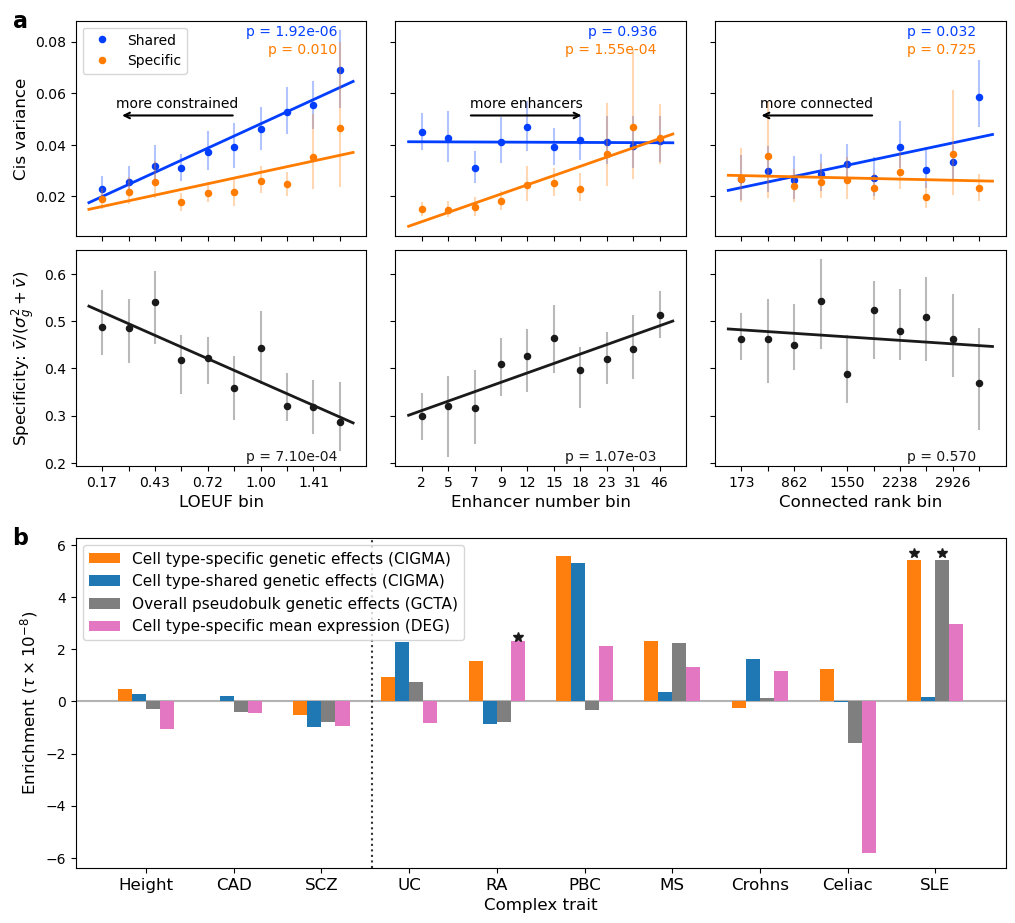

In [ ]:
# Fig 4
fs = 12
lw = 2
alpha = 0.3
format_p = lambda p: f'{p:.2e}' if p < 0.01 else f'{p:.3f}'

colors = sns.color_palette('bright')

for df, tmp_ldsc_data in zip([low_df, high_df], [low_ldsc_data, high_ldsc_data]):
    fig = plt.figure(figsize=(12, 11))
    gs = gridspec.GridSpec(30, 3, wspace=0.1, hspace=1)

    # genomic feature
    data = df.copy()
    data = data.loc[data['g'] > 0]  # NOTE: removed negative gen variance
    print(data.shape)
    filter = data[['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']].isna().all(axis=1)
    data = data.loc[~filter]
    print(data.shape, (~data['LOEUF'].isna()).sum(), (~data['ActivityLinking_EnhancerNumber'].isna()).sum(), (~data['combined_connected_rank'].isna()).sum())
    # rerank connectness
    data['combined_connected_rank'] = data['combined_connected_rank'].rank(method='first')

    # divide gene annotation into bins
    annotations = ['LOEUF', 'ActivityLinking_EnhancerNumber', 'combined_connected_rank']
    for annotation in annotations:
        data = plot.bin_gene_annotation(data, annotation, 10)

    # arrange axes
    ax11 = fig.add_subplot(gs[:8, 0])
    ax12 = fig.add_subplot(gs[:8, 1], sharey=ax11)
    ax13 = fig.add_subplot(gs[:8, 2], sharey=ax11)
    ax21 = fig.add_subplot(gs[8:16, 0], sharex=ax11)
    ax22 = fig.add_subplot(gs[8:16, 1], sharex=ax12, sharey=ax21)
    ax23 = fig.add_subplot(gs[8:16, 2], sharex=ax13, sharey=ax21)
    axes = np.array([[ax11, ax12, ax13],
                    [ax21, ax22, ax23]])


    for j, annotation in enumerate(annotations):
        print(annotation)

        # meta-regression
        grouped = data.groupby(annotation + '_bin', observed=True)

        line1, p1, slope1, intercept1 = plot.meta_regression(grouped, 'hom_g2', 'mean', return_params=True)
        line2, p2, slope2, intercept2 = plot.meta_regression(grouped, 'V', 'mean', return_params=True)

        ax = axes[0, j]
        # point plot
        sns.pointplot(data=data, x=annotation + '_bin', y='hom_g2', estimator='mean',
                    markers='.', linestyles='none', color=colors[0], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Shared', ax=ax)
        xs = np.array(ax.get_xlim())
        ax.plot(xs, slope1 * xs + intercept1, color=colors[0], lw=lw, linestyle='-')
        sns.pointplot(data=data, x=annotation + '_bin', y='V', estimator='mean',
                    markers='.', linestyles='none', color=colors[1], err_kws={'alpha': alpha, 'linewidth': 1.5},
                    label=r'Specific', ax=ax)
        ax.plot(xs, slope2 * xs + intercept2, color=colors[1], lw=lw, linestyle='-')
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)

        # add p values
        x = 0.9
        y = 0.98
        ax.text(x, y, f'p = {format_p(p1)}', fontsize=fs-2, color=colors[0], ha='right', va='top', transform=ax.transAxes)
        y -= .08
        ax.text(x, y, f'p = {format_p(p2)}', fontsize=fs-2, color=colors[1], ha='right', va='top', transform=ax.transAxes)


        ax2 = axes[1, j]
        line, p, slope, intercept = plot.meta_regression(grouped, 'specificity', 'median', return_params=True)

        # pointplot
        sns.pointplot(data=data, x=annotation + '_bin', y='specificity', err_kws={'alpha': alpha, 'linewidth': 1.5},
                        markers='.', estimator='median', linestyles='none', color='0.1', ax=ax2)
        xs = np.array(ax2.get_xlim())
        ax2.plot(xs, slope * xs + intercept, color='0.1', lw=lw, linestyle='-')

        ax2.text(x, 0.01, f'p = {format_p(p)}', fontsize=fs-2, color='0.1', ha='right', va='bottom', transform=ax2.transAxes)

        xlabel = re.sub('_', ' ', annotation + '_bin')
        if annotation == 'ActivityLinking_EnhancerNumber':
            xlabel = 'Enhancer number bin'
        elif annotation == 'combined_connected_rank':
            xlabel = 'Connected rank bin'

        if annotation in ['LOEUF', 'EDS', 'combined_connected_rank']:
            # set x tick labels
            xticklabels = []
            for i, label in enumerate(ax2.get_xticklabels()):
                if i % 2 == 0:
                    xticklabels.append(label.get_text())
                else:
                    xticklabels.append('')
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels(xticklabels)

        ax2.set_xlabel(xlabel, fontsize=fs)

        if j == 0:
            ax.set_ylabel('Cis variance', fontsize=fs)
            ax2.set_ylabel('Specificity: ' + r'$\bar{v}/(\sigma_g^2 + \bar{v})$', fontsize=fs)
        else:
            ax.tick_params(axis='y', labelleft=False)
            ax2.tick_params(axis='y', labelleft=False)
            ax.set_ylabel('')
            ax2.set_ylabel('')
        
        if j != 0:
            ax.legend().set_visible(False)
        else:
            ax.legend(loc='upper left', fontsize=fs-2)

    # add arrow
    arrow_position = (0.55, 0.56)
    axes[0, 0].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 0].transAxes)
    axes[0, 0].text(0.35, 0.58, 'more constrained', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 0].transAxes)

    axes[0, 2].annotate('', xy=(arrow_position[0] - 0.40, arrow_position[1]), xytext=arrow_position,
            arrowprops=dict(arrowstyle='->', lw=1.5),
            fontsize=10, ha='center', va='center', xycoords=axes[0, 2].transAxes)
    axes[0, 2].text(0.35, 0.58, 'more connected', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 2].transAxes)

    axes[0, 1].annotate('', xy=(arrow_position[0] + 0.1, arrow_position[1]), xytext=(arrow_position[0] - 0.40 + 0.1, arrow_position[1]),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=10, ha='center', va='center', xycoords=axes[0, 1].transAxes)
    axes[0, 1].text(0.45, 0.58, 'more enhancers', ha='center', va='bottom', 
                    fontsize=fs-2, transform=axes[0, 1].transAxes)


    ## LDSC
    ax = fig.add_subplot(gs[18:, :])
    gene_set_order = ['var', 'shared', 'gcta', 'mean' ]

    x = np.arange(tmp_ldsc_data['trait'].nunique())
    width = 0.16
    # width = 0.32
    ldsc_colors = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[7], sns.color_palette()[6]]
    # colors = [sns.color_palette()[2], sns.color_palette()[1]] + sns.color_palette()[3:]
    multiplier = -len(gene_set_order) / 2 + 0.5
    print(tmp_ldsc_data)

    for i, gene_set in enumerate(gene_set_order):
        if gene_set == 'mean':
            label = 'Cell type-specific mean expression (DEG)'
        elif gene_set == 'var':
            label = 'Cell type-specific genetic effects (CIGMA)'
        elif gene_set =='shared':
            label = 'Cell type-shared genetic effects (CIGMA)'
        elif gene_set == 'gcta':
            label = 'Overall pseudobulk genetic effects (GCTA)'
        offset = width * multiplier
        set_data = tmp_ldsc_data.loc[tmp_ldsc_data['Name'] == gene_set]
        set_data = set_data.set_index('trait')
        # ys = np.log10(set_data['Coefficient_P_value'][traits]) * (-1)
        ys = set_data['Coefficient'][traits] * 1e8
        rects = ax.bar(x + offset, ys, width, yerr=None, label=label, color=ldsc_colors[i])
        # add star
        for p, rect in zip(set_data['Coefficient_P_value'][traits], rects):
            if p < 0.05:
                ax.plot(rect.get_x() + rect.get_width() / 2, rect.get_height() + ys.max() * .05, '*', 
                        color='0.1', markersize=7)

        multiplier += 1
    ax.set_ylabel(r'Enrichment ($\tau \times 10^{-8}$)', fontsize=fs)
    # ax.set_ylabel(r'Regression coefficient, $\tau$ ($\times 10^{-8}$)', fontsize=fs)
    ax.set_xlabel('Complex trait', fontsize=fs)

    ax.set_xticks(x, traits, fontsize=fs)
    ax.legend(loc='upper left', fontsize=fs-1)
    ax.axvline(len(neg_traits) - 0.5 + width / 2, linestyle=':', color='0.2')
    ax.axhline(0, linestyle='-', color='0.7', zorder=0)
    # ax.axhline(-np.log10(0.05), linestyle=(0, (6, 6)), color='0.7', zorder=0)

    fig.text(0.085, .89, 'a', fontsize=fs + 4, fontweight='bold', va='top', ha='right')
    fig.text(0.085, .42, 'b', fontsize=fs + 4, fontweight='bold', va='top', ha='right')


    fig.tight_layout()